- Student Name: Lisa Arends
- Student pace: full time
- Instructor: Claude Fried
- Blog post URL: https://fromteachingtotech928923879.wordpress.com/2021/10/01/who-buys-the-wine-using-clustering-for-market-segmentation/

# Problem Statement

GA Power is the largest power utility in Georgia, serving over 2.3 million residential customers. A net-metering program was initiated in 2019 that allowed customers with photovoltaic (PV) solar panels on their roof to sell excess electricity to GA Power at competitive rates. The cap of 5,000 customers for the program was recently reached, disincentivizing customers from installing solar power on their homes.  

## Business Value

Eliminating the net metering cap will incentivize more Georgia residents to install PV panels on their homes because they will be able to sell back their excess electricity at competitive market rates, thus decreasing the time it takes for the system to pay for itself. Increasing the number of homes with PV solar panels will benefit the residents of Georgia by helping to moderate energy prices and limit demand on the grid. Furthermore, an increase in residential PV systems will position the state to be more resilient in the face of a changing energy landscape and will ensure that Georgia remains competitive in the U.S. energy market. 

## Questions to Consider

- How will Georgia's dependence on imported electricity change in the coming years?
- How are natural gas prices expected to change and how will that impact Georgia's fuel costs?
- What is the correlation between extreme temperatures and the demand on the residential electrical grid?
- How does Georgia's per capita production of solar from residential systems compare to the U.S.?

## Methodology

Data from the U.S. Energy Administration(EIA) were used to analyze the trends and forecast future changes in Georgia’s residential power demand, natural gas prices and residential solar generation. In addition, the relationship between extreme temperatures and demand on the electrical grid was investigated.


# Obtain the Data

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import joblib
from joblib import dump, load
import os

import statsmodels.api as sm 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.formula.api import ols
from statsmodels.stats.stattools import durbin_watson

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 
from sklearn.pipeline import Pipeline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Bidirectional
from tensorflow.keras import regularizers
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping

from scipy import stats

from datetime import datetime
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%matplotlib inline

sns.set_style('darkgrid')
sns.set_context('talk')
NEUTRAL = '#5f8195'
HIGHLIGHT = '#00c3b1'
DARK_NEUTRAL = '#3d3d3d'
LIGHT_NEUTRAL = '#dff2f7'
BRICK = '#b45f06'
MEDIUM = '#7aa3ad'
GREEN = '#64be3c'
PALETTE = 'deep'

## Reduce Dependence on Imported Electricity

Use forecast of number of future customers and percent of electricity used in Georgia that is imported from other states to show how dependence on outside resources will increase, putting Georgia in a potentially vulnerable position.

In [193]:
#From EIA.gov; Number of residential electricity customers from 2008-2021.
#measured monthly
ym_parser =  lambda x: datetime.strptime(x, "%Y%m")
customers = pd.read_csv(
    'files/number_customers_monthly.csv', 
    skiprows=6, 
    parse_dates=['Source'], 
    date_parser=ym_parser, 
    index_col='Source'
)
customers.columns = ['number_of_residential_customers']
customers = customers.sort_index()
customers.index.freq = 'MS'
customers.head()

number_of_residential_customers
Source                                     
2008-01-01                          4018970
2008-02-01                          4025567
2008-03-01                          4028445
2008-04-01                          4028785
2008-05-01                          4033126

In [3]:
#From EIA.gov; The amount of electricity in GA from various sources from 
#1960-2019, measured annually, in billion btus.
cols_to_use_source = ['Series Key', 'SEDS.RETCB.GA.A', 'SEDS.PMTCB.GA.A',
        'SEDS.NUETB.GA.A','SEDS.NNTCB.GA.A','SEDS.CLTCB.GA.A',
        'SEDS.TETCB.GA.A','SEDS.ELISB.GA.A']
by_source = pd.read_csv(
    'files/ga_annual_by_source.csv',
    usecols=cols_to_use_source,
    )[6:]
by_source.columns = (
    ['date',
     'renewable',
     'petroleum',
     'nuclear',
     'natural_gas',
     'coal',
     'total',
     'imported'])
by_source['date'] = pd.to_datetime(by_source['date'], format='%Y')
by_source = by_source.set_index('date')
by_source = by_source.astype(float)

#Add a column to track the % of electricity that is imported
by_source['percent_imported'] = by_source['imported']/by_source['total']
by_source.head()

renewable  petroleum   nuclear  natural_gas      coal      total  \
date                                                                           
2019-01-01   313981.0  1007518.0  350759.0     787386.0  273109.0  2963080.0   
2018-01-01   303411.0  1009846.0  359262.0     759205.0  340152.0  3010509.0   
2017-01-01   293453.0  1038950.0  352560.0     709671.0  344273.0  2933159.0   
2016-01-01   298083.0   983632.0  360633.0     727336.0  399279.0  2959871.0   
2015-01-01   300816.0  1008952.0  353883.0     712580.0  394665.0  2985813.0   

            imported  percent_imported  
date                                    
2019-01-01  230327.0          0.077732  
2018-01-01  238634.0          0.079267  
2017-01-01  194252.0          0.066226  
2016-01-01  190908.0          0.064499  
2015-01-01  214917.0          0.071979

## Mitigate Impact of Rising Natural Gas Prices

In [4]:
#From EIA.gov; Natural gas futures for 1994-2021, measured daily, in dollars
# per million btu units

cols_to_use = (
    ['Series Key', 
     'NG.RNGC1.D', 
     'NG.RNGC2.D',
     'NG.RNGC3.D',
     'NG.RNGC4.D']
)
gas_price = pd.read_csv(
    'files/natural_gas_daily_price.csv', 
    usecols = cols_to_use)[6:]
gas_price = gas_price.dropna()
gas_price["Series Key"] = pd.to_datetime(
    gas_price["Series Key"], 
    format='%Y%m%d')
gas_price = gas_price.set_index('Series Key')
gas_price = gas_price.astype(float)
gas_price['avg_price'] = (
    gas_price.iloc[:,0]+
    gas_price.iloc[:,1]+
    gas_price.iloc[:,2]+
    gas_price.iloc[:,3])/4

gas_price = gas_price.drop(
    ['NG.RNGC1.D', 
     'NG.RNGC2.D',
     'NG.RNGC3.D',
     'NG.RNGC4.D'], 
    axis=1)
gas_price.head()

avg_price
Series Key           
2021-10-05    6.41825
2021-10-04    5.88975
2021-10-01    5.74425
2021-09-30    5.97050
2021-09-29    5.57675

## Decrease Strain on Power Grid During High Demand Periods

In [5]:
# From EIA.gov; demand in mwh measured hourly from 2015-2021; measurements 
# are for the Southeast region, in mwh
cols_to_use_reg = ([
    'Series Key', 
    'EBA.SE-ALL.D.H', 
    'EBA.TVA-ALL.D.H'
])
regional_demand = pd.read_csv(
    'files/regional_demand.csv', 
    usecols=cols_to_use_reg)[6:]
regional_demand['Series Key'] = pd.to_datetime(regional_demand['Series Key'])
regional_demand = regional_demand.set_index('Series Key')
regional_demand = regional_demand.astype(float)
regional_demand['demand'] = (regional_demand.iloc[:,0] 
                             + regional_demand.iloc[:,1])
regional_demand = regional_demand.drop([
    'EBA.SE-ALL.D.H', 'EBA.TVA-ALL.D.H']
    , axis=1
)
regional_demand.head()

demand
Series Key                        
2021-10-12 11:00:00+00:00  37467.0
2021-10-12 10:00:00+00:00  35361.0
2021-10-12 09:00:00+00:00  34479.0
2021-10-12 08:00:00+00:00  34484.0
2021-10-12 07:00:00+00:00  35288.0

In [6]:
#From NOAA (https://www.ncdc.noaa.gov/cdo-web/confirmation), daily max, min
#and average temperatures from 2016-2021
cols_to_use_clim = ([
    'DATE',
    'DailyMaximumDryBulbTemperature',
    'DailyMinimumDryBulbTemperature',
    'DailyAverageWetBulbTemperature'])
climate = pd.read_csv(
    'files/climate.csv', 
    usecols=cols_to_use_clim, 
    low_memory=False)
climate = climate.dropna()
climate['DATE'] = pd.to_datetime(climate['DATE'])
climate = climate.set_index('DATE')
climate.head()

DailyAverageWetBulbTemperature  \
DATE                                                  
2016-01-01 23:59:00                            38.0   
2016-01-02 23:59:00                            35.0   
2016-01-03 23:59:00                            36.0   
2016-01-04 23:59:00                            33.0   
2016-01-05 23:59:00                            28.0   

                     DailyMaximumDryBulbTemperature  \
DATE                                                  
2016-01-01 23:59:00                            46.0   
2016-01-02 23:59:00                            47.0   
2016-01-03 23:59:00                            53.0   
2016-01-04 23:59:00                            45.0   
2016-01-05 23:59:00                            44.0   

                     DailyMinimumDryBulbTemperature  
DATE                                                 
2016-01-01 23:59:00                            39.0  
2016-01-02 23:59:00                            35.0  
2016-01-03 23:59:00                            35.0  
2016-01-04 23:59:00                            32.0  
2016-01-05 23:59:00                            26.0

## Stay Competitive With U.S. Market

In [7]:
#From EIA.gov, measured monthly, in million kwh
us_solar = pd.read_csv('files/solar_generation.csv')[6:]
us_solar = (us_solar[us_solar['Description'] == 
    'Distributed Solar Photovoltaic Generation: Residential Sector'])
us_solar = us_solar[us_solar['Value'] != 'Not Available']
us_solar['Value'] = us_solar['Value'].astype(float)
us_solar['YYYYMM'] = us_solar['YYYYMM'].astype(str)
us_solar = us_solar[~us_solar['YYYYMM'].str.endswith('13')]
us_solar['YYYYMM'] = pd.to_datetime((us_solar['YYYYMM']), format='%Y%m')
us_solar = us_solar.set_index('YYYYMM')
us_solar = us_solar[['Value']]
us_solar.index.freq = 'MS'
us_solar.head()

Value
YYYYMM           
1989-01-01  0.560
1989-02-01  0.604
1989-03-01  0.832
1989-04-01  0.917
1989-05-01  1.012

In [8]:
#From EIA.gov, measured monthly, in kwh
ga_solar = pd.read_csv('files/ga_solar_production.csv')[6:]
ga_solar['Series Key'] = pd.to_datetime(ga_solar['Series Key'], format='%Y%m')
ga_solar = ga_solar.set_index('Series Key')
ga_solar.columns = ['value']
ga_solar['value'] = ga_solar['value'] .astype(float)
ga_solar = ga_solar.sort_index()
ga_solar.index.freq = 'MS'
ga_solar = ga_solar.sort_index()
ga_solar.head()

value
Series Key          
2014-01-01   6.62759
2014-02-01   6.81839
2014-03-01   8.70972
2014-04-01   9.37660
2014-05-01  10.17159

In [9]:
#From EIA.gov, measured monthly, in millon kwh
net_metering_2020 = pd.read_excel(
    'files/net_metering2020.xlsx', 
    sheet_name = 'Monthly_Totals-States' , 
    header=3)
net_metering_2020 = (net_metering_2020.loc
                     [:,
                      ['State','Residential',
                       'Residential.14',
                       'Residential.15']])
for col in net_metering_2020.columns[1:]:
    net_metering_2020[col] = pd.to_numeric(net_metering_2020[col], 
                                           errors = 'coerce')

net_metering_2020 = net_metering_2020.groupby('State').sum()
net_metering_2020.reset_index(inplace=True)
net_metering_2020.columns = ([
    'state',
    'residential_solar_capacity', 
    'residential_solar_customers',
    'energy_sold'
])

net_metering_2020.head()

state  residential_solar_capacity  residential_solar_customers  energy_sold
0    AK                      61.670                      14562.0      781.821
1    AL                       0.000                          0.0        0.000
2    AR                     278.620                      26094.0     1903.982
3    AZ                   13437.813                    2031545.0   220581.902
4    CA                   75485.035                   13533399.0   123960.829

# Initial Exploration

## Reduce Dependence on Imported Electricity

In [10]:
#Examine the customer data. There are 163 non-null observations.
customers.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 163 entries, 2008-01-01 to 2021-07-01
Freq: MS
Data columns (total 1 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   number_of_residential_customers  163 non-null    int64
dtypes: int64(1)
memory usage: 2.5 KB


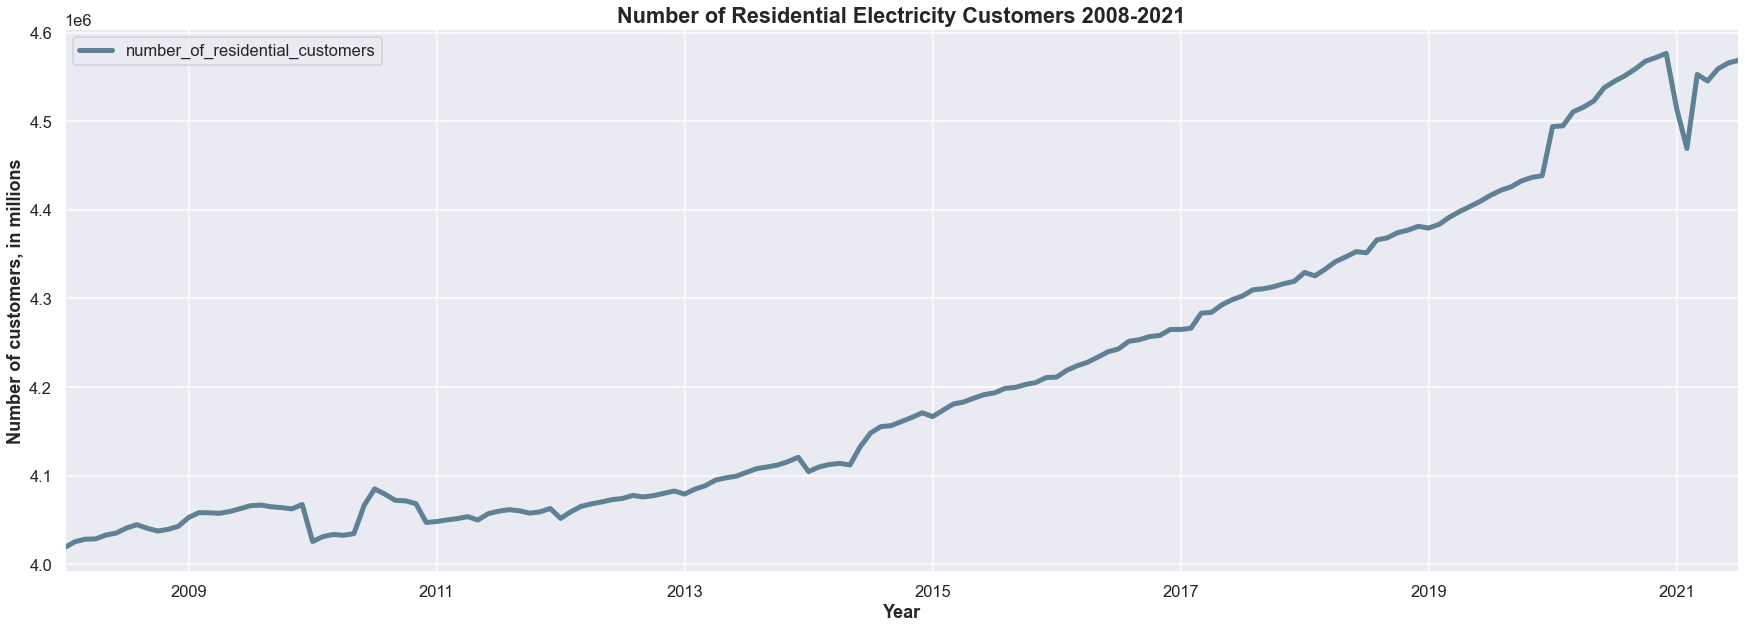

In [194]:
customers.plot(
    color=NEUTRAL, 
    figsize=(30,10),
    linewidth=5
)
plt.title(
    'Number of Residential Electricity Customers 2008-2021', 
    fontsize='large',
    weight='bold'
)
plt.ylabel(
    'Number of customers, in millions', 
    weight='bold'
)
plt.xlabel(
    'Year', 
    weight='bold'
);

From 2008 to 2013, the number of residential customers stayed relatively constant at just over 4 million. The number of customers has been steadily increasing since then, with a brief sharp increase in 2020, most likely due to the pandemic. 

The monthly (or more frequent) residential energy demand for Georgia is not available. I will instead use the number of customers and the average electricity usage per household to estimate the energy demand per month. 

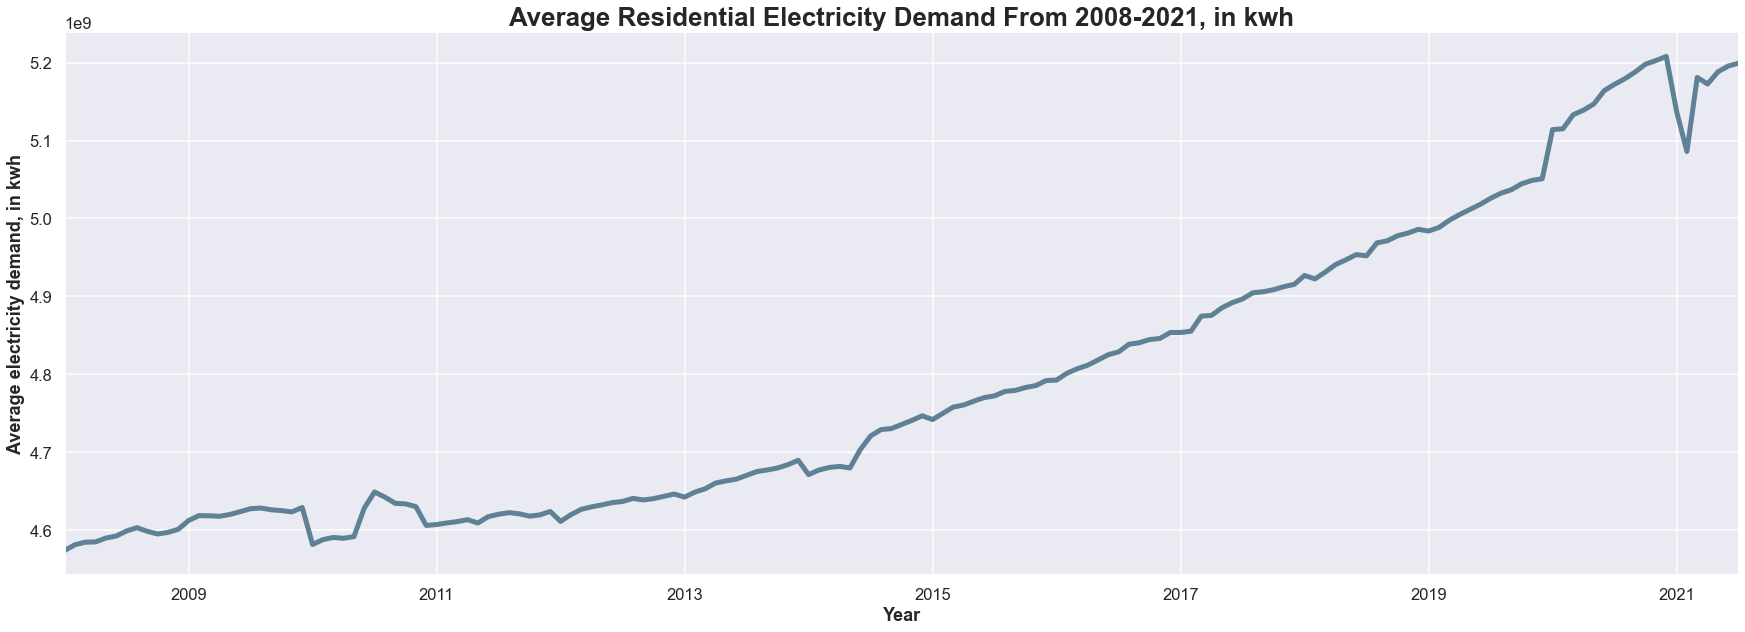

In [195]:
# Average residential kwh/month from chooseenergy.com
avg_kwh = 1138
customers['total_kwh'] = customers['number_of_residential_customers'] * avg_kwh
customers['total_kwh'].plot(
    color=NEUTRAL, 
    figsize=(30,10),
    linewidth=5)
plt.title(
    'Average Residential Electricity Demand From 2008-2021, in kwh', 
    fontsize='x-large',
    weight='bold'
)
plt.ylabel(
    'Average electricity demand, in kwh',
    weight='bold'
)
plt.xlabel(
    'Year', 
    weight='bold'
);

In [13]:
#Select only the kwh column
energy_demand = customers.copy()['total_kwh']

In [14]:
#Examine the electricity source data. There are 60 non-null observations.
by_source.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2019-01-01 to 1960-01-01
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   renewable         60 non-null     float64
 1   petroleum         60 non-null     float64
 2   nuclear           60 non-null     float64
 3   natural_gas       60 non-null     float64
 4   coal              60 non-null     float64
 5   total             60 non-null     float64
 6   imported          60 non-null     float64
 7   percent_imported  60 non-null     float64
dtypes: float64(8)
memory usage: 4.2 KB


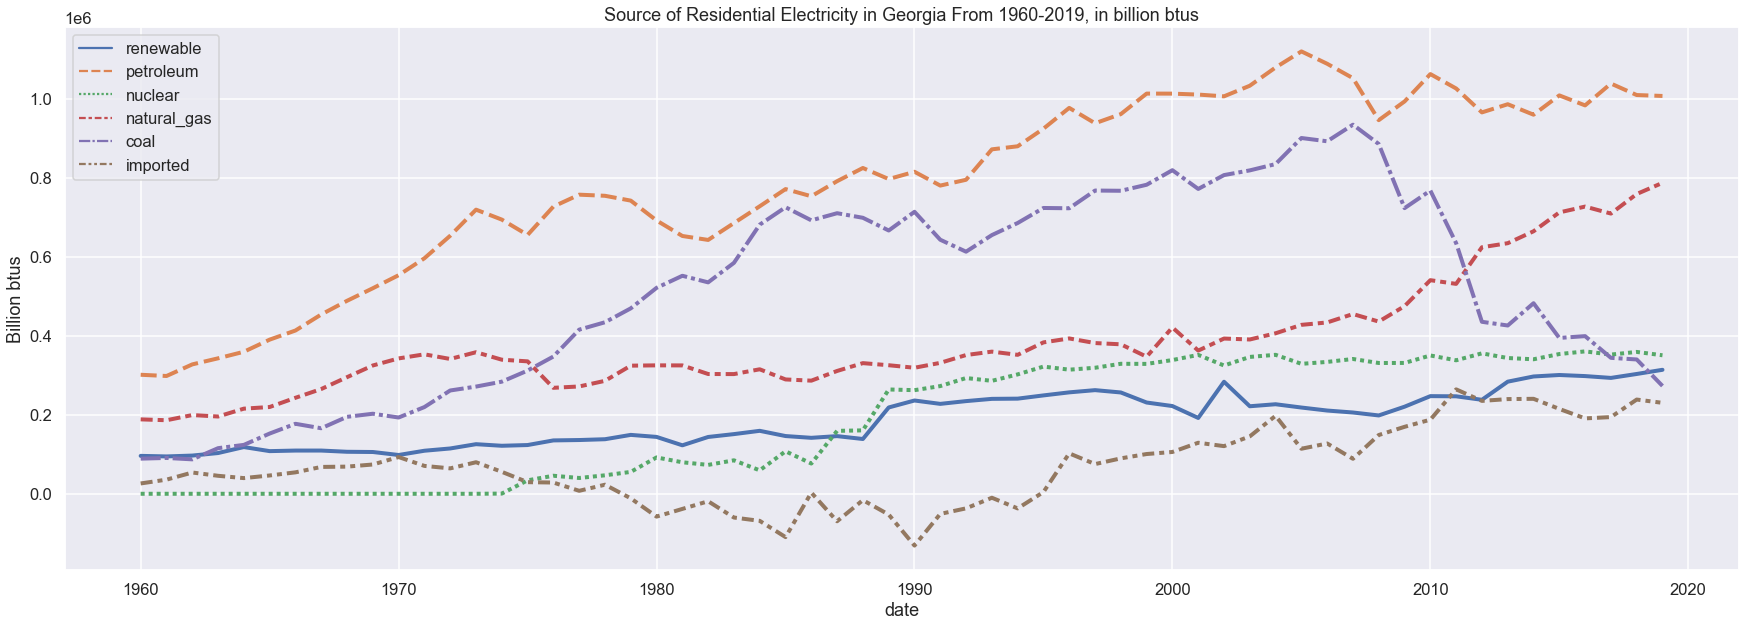

In [15]:
#Select only the columns to plot
by_source_only = by_source.drop(['total', 'percent_imported'], axis=1)

fig,ax = plt.subplots(figsize=(30,10))
sns.lineplot(
    data=by_source_only, 
    palette=PALETTE,
    linewidth=4)
plt.title('Source of Residential Electricity in Georgia From 1960-2019, in billion btus')
plt.ylabel('Billion btus');

Natural gas use is increasing rapidly while the use of coal to generate electricity is decreasing. Renewables, nuclear and petroleum have remained relatively steady over the past 15 years 

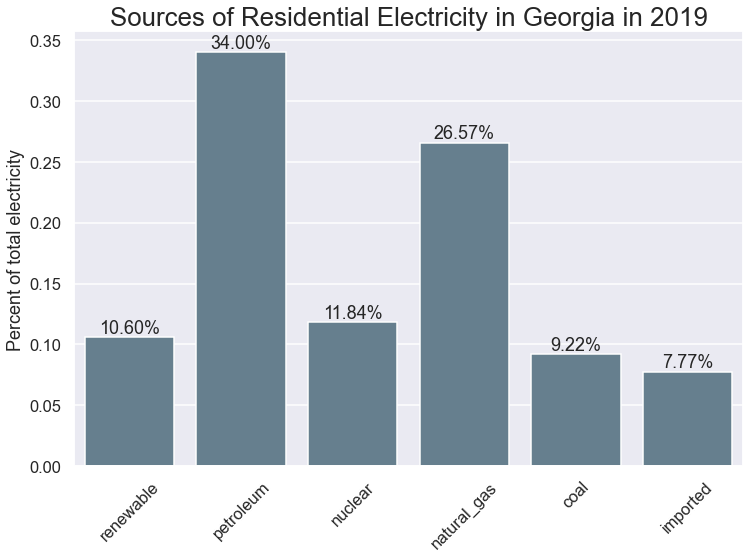

In [16]:
#Plot percent of each source of residential electricity
fig,ax = plt.subplots(figsize=(12,8))
g = sns.barplot(
    x=by_source_only.columns, 
    y=by_source_only.iloc[0]/by_source.loc['2019','total'][0], 
    color=NEUTRAL
)
for p in g.patches:
    g.annotate(format(f'{p.get_height()*100:.2f}%'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.title(
    'Sources of Residential Electricity in Georgia in 2019', 
    fontsize='x-large')
plt.xticks(rotation=45)
plt.ylabel('Percent of total electricity');

According to the most recent data in 2019, petroleum and natural gas account for over 50% of the electricity. According to the EIA, Georgia does not have any natural gas, oil or coal resources, so all of those raw materials have to be imported from other areas. 8% of the electricity is directly imported from other states.

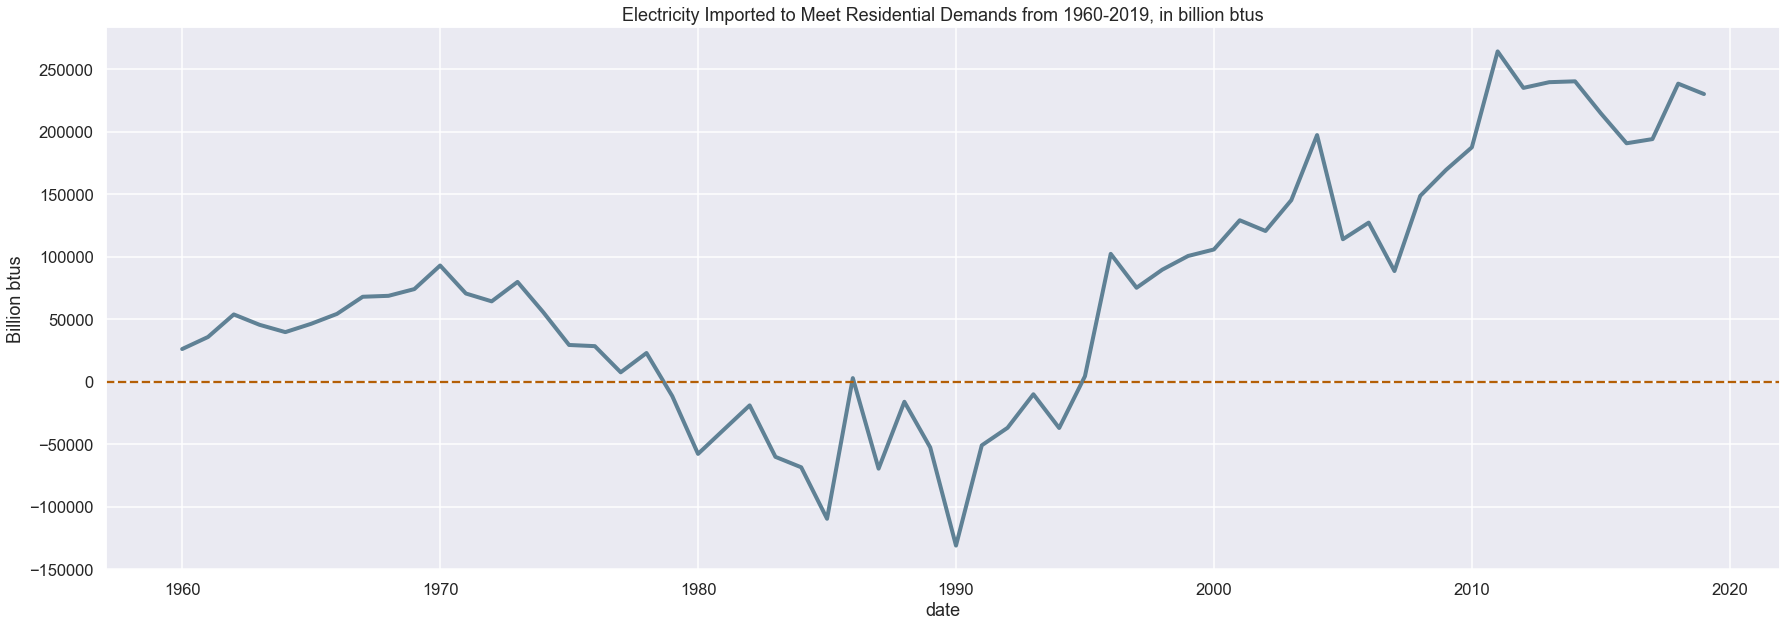

In [17]:
#Plot electricity imported
fig,ax = plt.subplots(figsize=(30,10))
sns.lineplot(
    data=by_source['imported'], 
    color=NEUTRAL,
    linewidth=4)
plt.axhline(0, 
            linestyle='--', 
            color=BRICK)
plt.title(
    'Electricity Imported to Meet Residential Demands from 1960-2019, in billion btus'
)
plt.ylabel('Billion btus');

In the 1980s, Georgia was producing more electricity than it used and was able to export the excess. Since the mid-1990s, the amount of electricity imported has overall been increasing.  

## Mitigate Impact of Rising Natural Gas Prices

In [18]:
#Examine the gas price data. There are 6968 non-null observations.
gas_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6968 entries, 2021-10-05 to 1994-01-19
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   avg_price  6968 non-null   float64
dtypes: float64(1)
memory usage: 108.9 KB


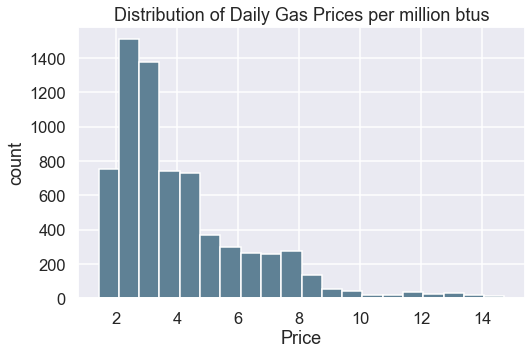

In [19]:
# Gas prices are clustered around $3.00/ million btu units with a long
# right tail
gas_price.hist(
    bins=20, 
    color=NEUTRAL, 
    figsize=(8,5))
plt.title('Distribution of Daily Gas Prices per million btus')
plt.xlabel('Price')
plt.ylabel('count');

In [20]:
gas_price.describe()

avg_price
count  6968.000000
mean      4.082263
std       2.244756
min       1.414750
25%       2.502000
50%       3.280750
75%       4.969750
max      14.737750

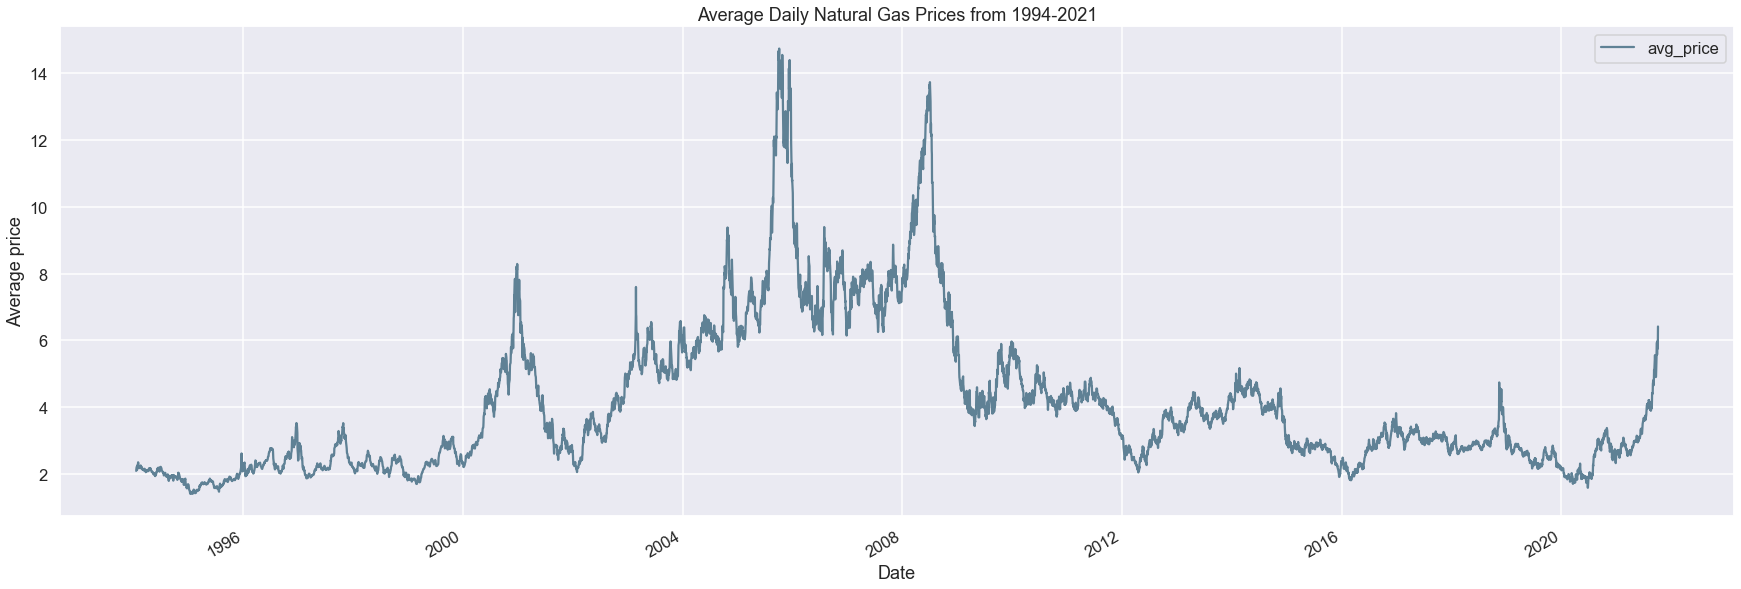

In [21]:
#Examine gas prices over time
gas_price.plot(
    figsize=(30,10), 
    color=NEUTRAL)
plt.title('Average Daily Natural Gas Prices from 1994-2021')
plt.ylabel('Average price')
plt.xlabel('Date');

Gas prices were relatively steady from 1994-2000 and again from 2012-2020. They increased between 2000 and 2012, with two sharp spikes around the max price of $14.74. In 2021, prices appear to be sharply increasing again.

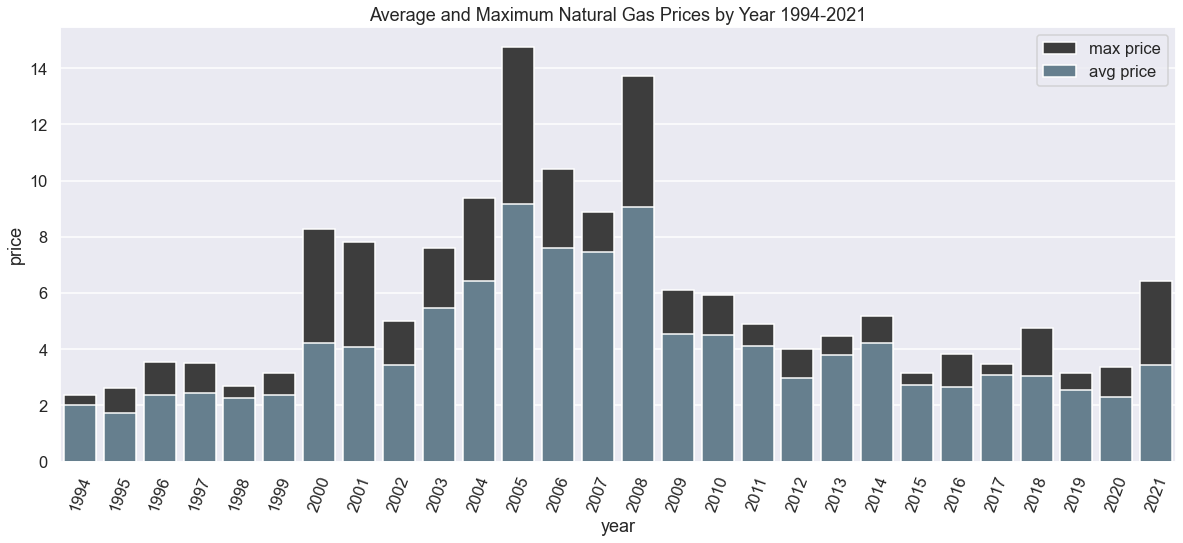

In [22]:
#Plot average and maximin price of gas per year
avg_gas_by_year = gas_price.resample('A').mean()
max_gas_by_year = gas_price.resample('A').max()
avg_gas_by_year['year'] = avg_gas_by_year.index.year
max_gas_by_year['year'] = max_gas_by_year.index.year
fig,ax = plt.subplots(figsize=(20,8))
sns.barplot(
    data=max_gas_by_year, 
    x='year', 
    y='avg_price', 
    color=DARK_NEUTRAL,
    label='max price')
sns.barplot(
    data=avg_gas_by_year, 
    x='year', 
    y='avg_price', 
    color=NEUTRAL,
    label='avg price')
ax.legend()
plt.xticks(rotation=70)
plt.ylabel('price')
plt.title('Average and Maximum Natural Gas Prices by Year 1994-2021');

## Decrease Strain on Power Grid During High Demand Periods

In [23]:
#Summarize the data
regional_demand.describe(), regional_demand.isna().sum()

(             demand
 count  5.427300e+04
 mean   4.275804e+04
 std    4.311303e+05
 min   -9.987333e+07
 25%    3.879700e+04
 50%    4.304600e+04
 75%    5.016700e+04
 max    8.429300e+04,
 demand    813
 dtype: int64)

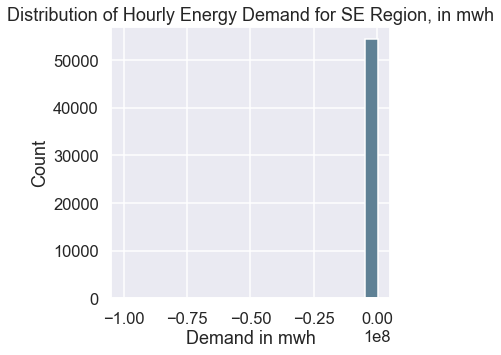

In [24]:
#Plot energy demand 
regional_demand.hist(figsize=(5,5), color=NEUTRAL, bins=20)
plt.title('Distribution of Hourly Energy Demand for SE Region, in mwh')
plt.xlabel('Demand in mwh')
plt.ylabel('Count');

There are obviously some extreme outliers, most likely due to data entry or equipment errors because negative values do not have meaning within this context. Additionally, there are 813 null entries that will need to be addressed.

In [25]:
#Examine missing values
regional_demand[regional_demand['demand'].isna()][:40]

demand
Series Key                       
2020-11-01 05:00:00+00:00     NaN
2020-11-01 04:00:00+00:00     NaN
2020-11-01 03:00:00+00:00     NaN
2020-11-01 02:00:00+00:00     NaN
2020-11-01 01:00:00+00:00     NaN
2020-11-01 00:00:00+00:00     NaN
2020-10-31 23:00:00+00:00     NaN
2020-10-31 22:00:00+00:00     NaN
2020-10-31 21:00:00+00:00     NaN
2020-10-31 20:00:00+00:00     NaN
2020-10-31 19:00:00+00:00     NaN
2020-10-31 18:00:00+00:00     NaN
2020-10-31 17:00:00+00:00     NaN
2020-10-31 16:00:00+00:00     NaN
2020-10-31 15:00:00+00:00     NaN
2020-10-31 14:00:00+00:00     NaN
2020-10-31 13:00:00+00:00     NaN
2020-10-31 12:00:00+00:00     NaN
2020-10-31 11:00:00+00:00     NaN
2020-10-31 10:00:00+00:00     NaN
2020-10-31 09:00:00+00:00     NaN
2020-10-31 08:00:00+00:00     NaN
2020-10-31 07:00:00+00:00     NaN
2020-10-31 06:00:00+00:00     NaN
2019-10-02 05:00:00+00:00     NaN
2019-10-02 04:00:00+00:00     NaN
2019-10-02 03:00:00+00:00     NaN
2019-10-02 02:00:00+00:00     NaN
2019-10-02 01:00:00+00:00     NaN
2019-10-02 00:00:00+00:00     NaN
2019-10-01 23:00:00+00:00     NaN
2019-10-01 22:00:00+00:00     NaN
2019-10-01 21:00:00+00:00     NaN
2019-10-01 20:00:00+00:00     NaN
2019-10-01 19:00:00+00:00     NaN
2019-10-01 18:00:00+00:00     NaN
2019-10-01 17:00:00+00:00     NaN
2019-10-01 16:00:00+00:00     NaN
2019-10-01 15:00:00+00:00     NaN
2019-10-01 14:00:00+00:00     NaN

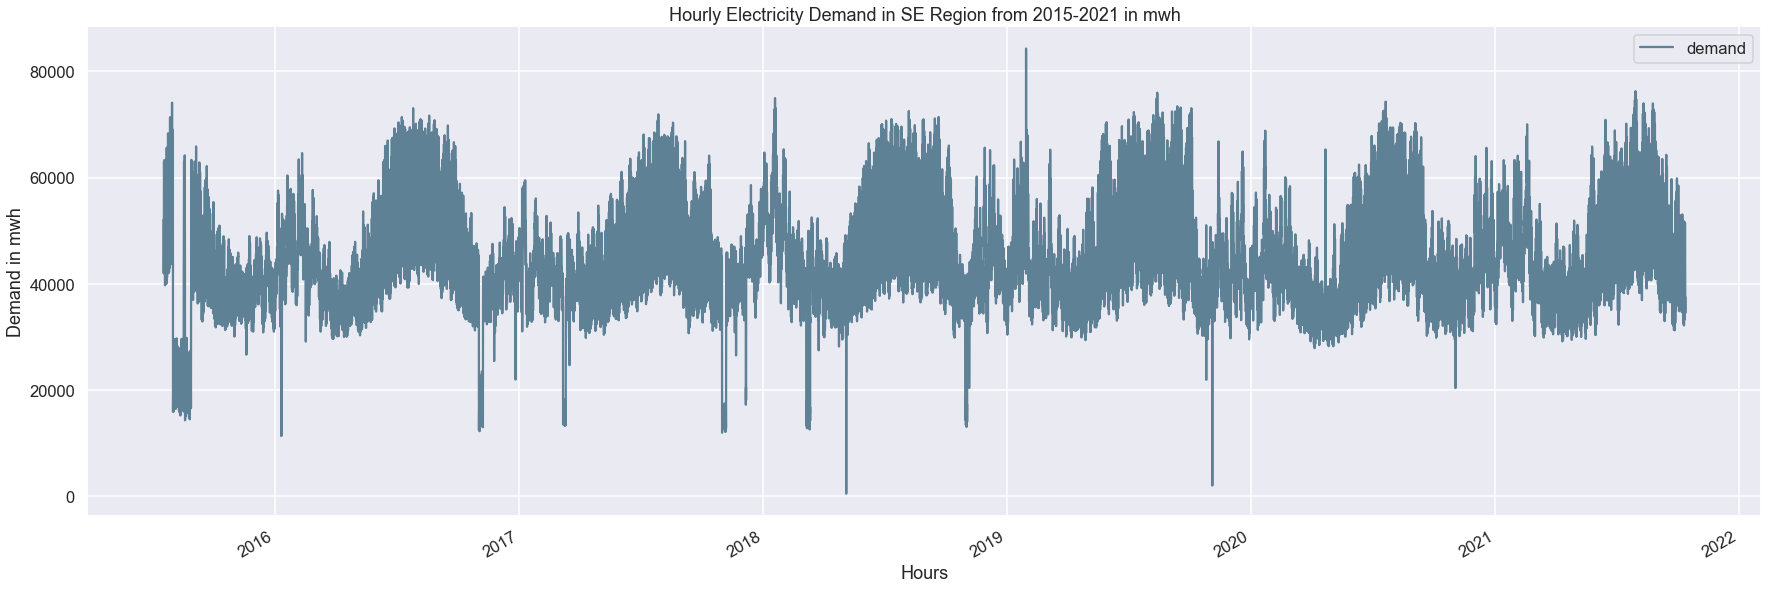

In [26]:
#Plot the data above 0
regional_demand[regional_demand['demand']>0].plot(
    figsize=(30,10), 
    color=NEUTRAL)
plt.xlabel('Hours')
plt.ylabel('Demand in mwh')
plt.title('Hourly Electricity Demand in SE Region from 2015-2021 in mwh');

In [27]:
#Fine the first quantile to get a sense of what qualifies as an outlier
regional_demand[regional_demand['demand']>0].quantile(.1)

demand    34728.0
Name: 0.1, dtype: float64

In [28]:
#Calculate the percent of values below 25,000 mwh
regional_demand[(
    regional_demand['demand'] < 25000)].shape[0]/regional_demand.shape[0]

0.01824419997821588

The missing values occur over consecutive hours, perhaps when equipment was malfunctioning. Because the data will be resampled at the daily level with the maximum demand for each day, these rows can simply be dropped.

There is suspect data below the value of 30,000 kwh. Although these may be associated with power outages in the region, I was unable to substantiate that. That also would not explain the artifact in 2015, where data is clustered at 20,000. I am going to start the time series after the anomaly in 2015 and limit it to values above 25,000 kwh, as the first quantile of the data is at 34,728. This eliminates 1.8% of the data points. 

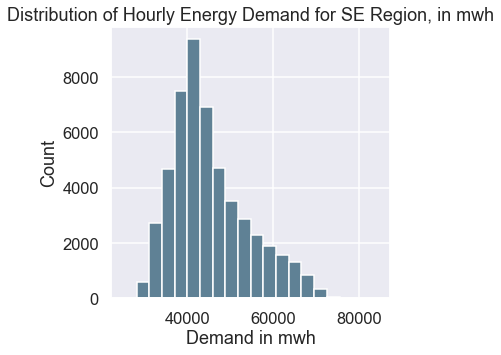

In [29]:
#Remove null values and outliers
regional_demand = regional_demand[regional_demand['demand'] > 25000].dropna()
regional_demand = regional_demand[regional_demand.index >= '2015-11']

#Plot energy demand after removing outliers and null values
regional_demand.hist(figsize=(5,5), color=NEUTRAL, bins=20)
plt.title('Distribution of Hourly Energy Demand for SE Region, in mwh')
plt.xlabel('Demand in mwh')
plt.ylabel('Count');

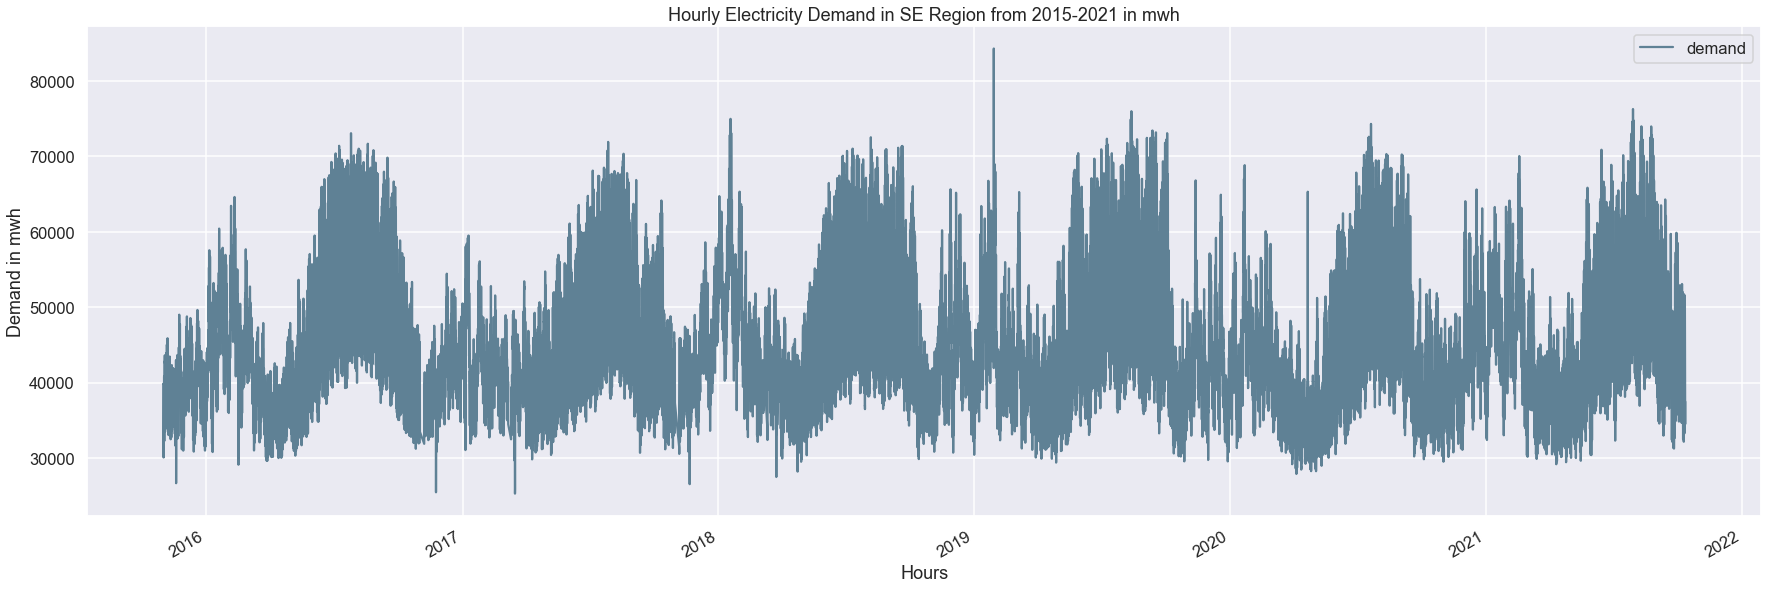

In [30]:
#Plot energy demand after removing outliers and null values
regional_demand.plot(
    figsize=(30,10), 
    color=NEUTRAL)
plt.xlabel('Hours')
plt.ylabel('Demand in mwh')
plt.title('Hourly Electricity Demand in SE Region from 2015-2021 in mwh');

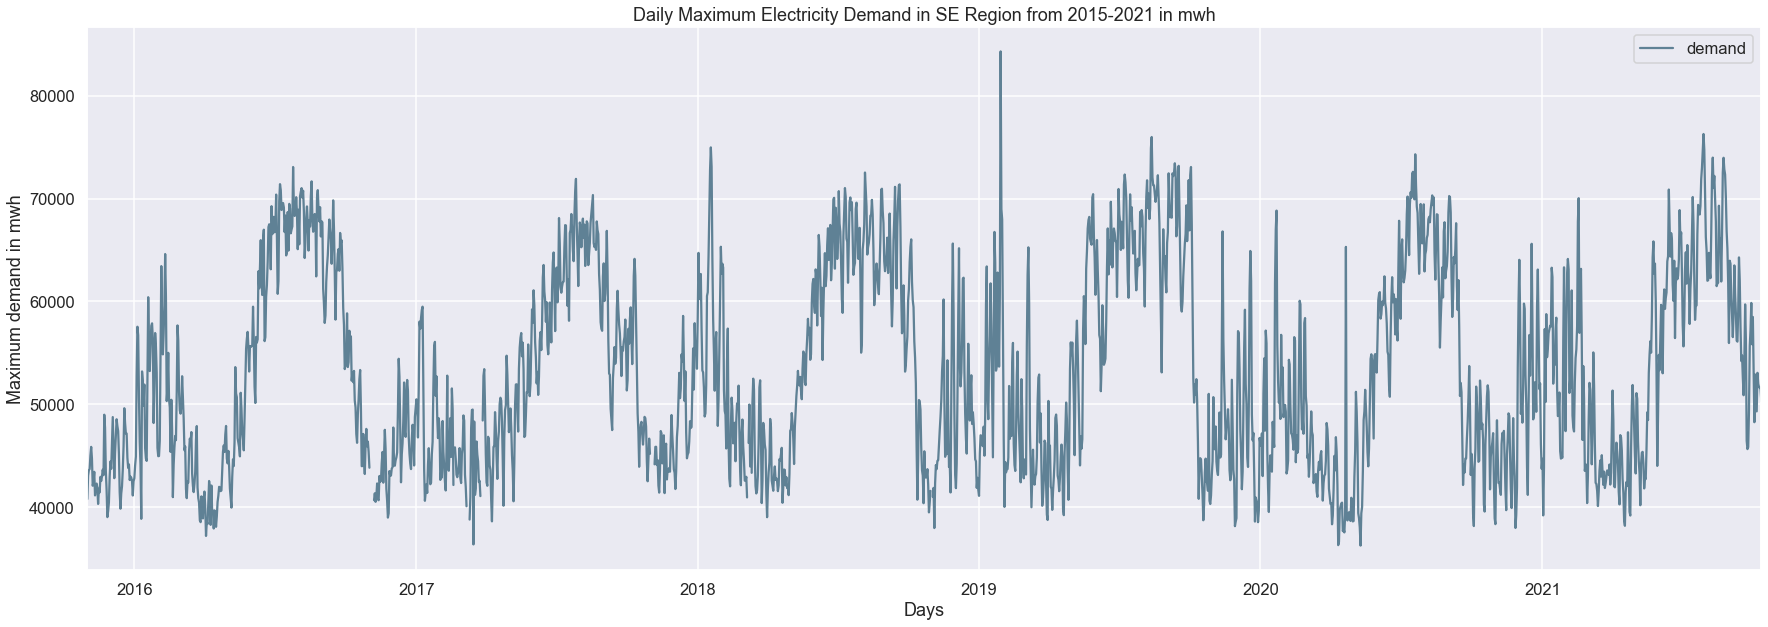

In [31]:
#Resample the data at a daily level. Find the maximum demand, since we are 
#looking at the strain on the power grid.
daily_demand = regional_demand.resample('D').max()
daily_demand.plot(
    figsize=(30,10), 
    color=NEUTRAL)
plt.xlabel('Days')
plt.ylabel('Maximum demand in mwh')
plt.title('Daily Maximum Electricity Demand in SE Region from 2015-2021 in mwh');

The daily maximum demand on the residential electrical grid shows a clear seasonal pattern, with demand at its highest in the summer months and a secondary peak in the winter. This makes sense, as HVAC is a major use of residential electricity. 

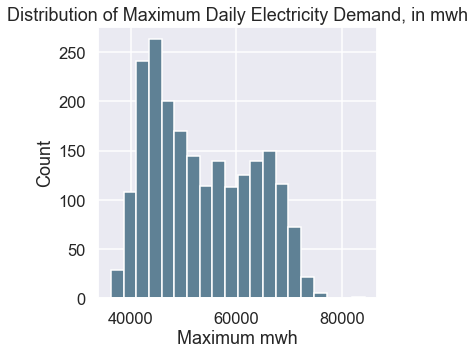

In [32]:
#Plot the distribution of the demand
daily_demand.hist(bins=20, color=NEUTRAL, figsize=(5,5))
plt.title('Distribution of Maximum Daily Electricity Demand, in mwh')
plt.xlabel('Maximum mwh')
plt.ylabel('Count');

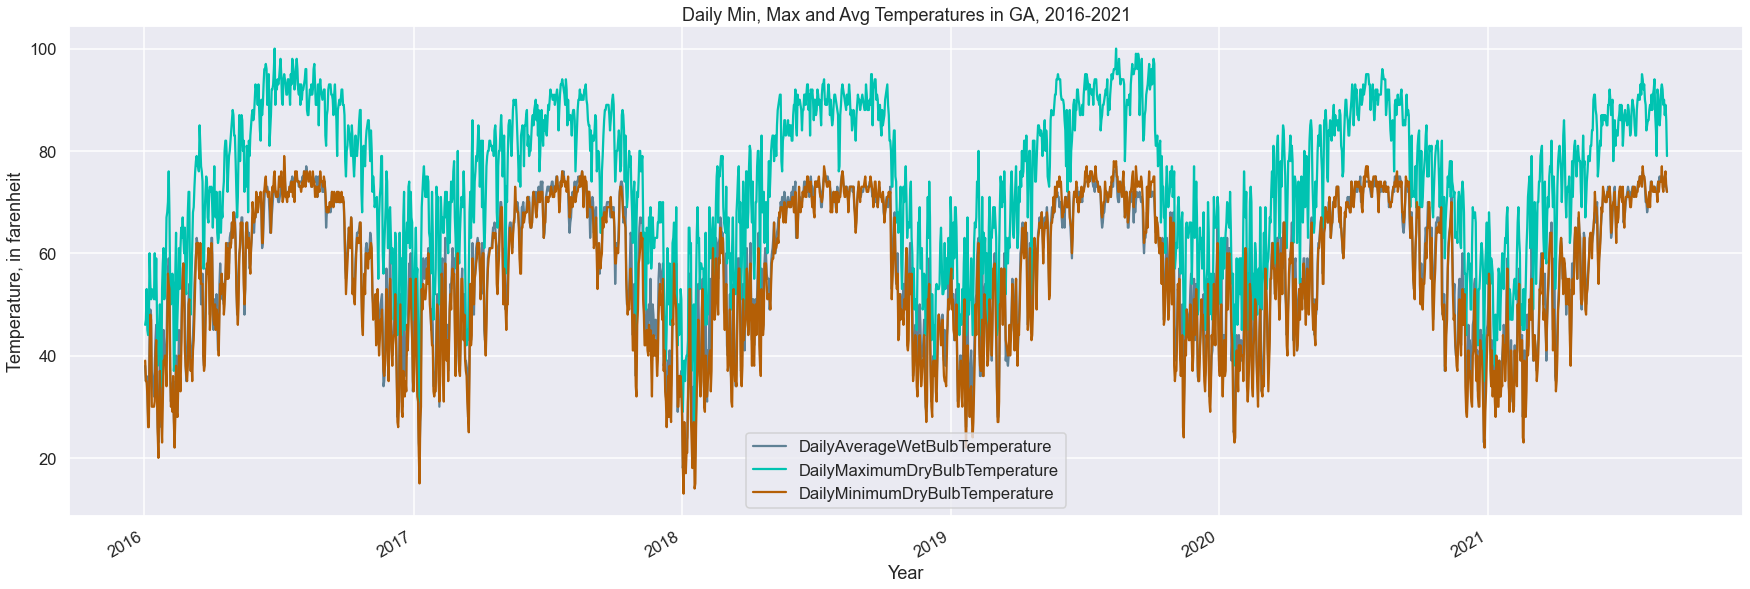

In [33]:
#Plot the daily temperature data
climate.plot(figsize=(30,10), color = [NEUTRAL, HIGHLIGHT,BRICK])
plt.title('Daily Min, Max and Avg Temperatures in GA, 2016-2021')
plt.xlabel('Year')
plt.ylabel('Temperature, in farenheit');

In [34]:
#Create a dataframe with temperature and demand data from 2016-2021
energy= daily_demand.copy()
energy = energy['2016':]
energy.index = pd.to_datetime(energy.index, format = '%Y%m%d').date

climate.index = pd.to_datetime(climate.index,format = '%Y%m%d').date
demand_temp = pd.concat([energy, climate], axis=1).dropna()
demand_temp.columns=['demand', 'avg_temp','max_temp','min_temp']

In [35]:
#Find the overall average temperature and create columns to show the max and
#min deviation from average
overall_mean = demand_temp['avg_temp'].mean()
demand_temp['above_avg'] = demand_temp['max_temp'] - overall_mean
demand_temp['below_avg'] = demand_temp['min_temp'] - overall_mean
demand_temp.head()

demand  avg_temp  max_temp  min_temp  above_avg  below_avg
2016-01-01  42823.0      38.0      46.0      39.0 -11.805474 -18.805474
2016-01-02  44050.0      35.0      47.0      35.0 -10.805474 -22.805474
2016-01-03  44933.0      36.0      53.0      35.0  -4.805474 -22.805474
2016-01-04  52829.0      33.0      45.0      32.0 -12.805474 -25.805474
2016-01-05  57543.0      28.0      44.0      26.0 -13.805474 -31.805474

In [36]:
def get_extreme(above, below):
    """Takes in the deviation from average and retuns the most extreme value"""
    if above > 0 and below > 0:
        return max(above,below)
    return min(above,below)

In [37]:
#Create a column for the largest deivation from average in a day
demand_temp['extreme'] = demand_temp.apply(
    lambda x: 
    get_extreme(x['above_avg'], 
                x['below_avg']), 
    axis=1)
demand_temp.head()

demand  avg_temp  max_temp  min_temp  above_avg  below_avg  \
2016-01-01  42823.0      38.0      46.0      39.0 -11.805474 -18.805474   
2016-01-02  44050.0      35.0      47.0      35.0 -10.805474 -22.805474   
2016-01-03  44933.0      36.0      53.0      35.0  -4.805474 -22.805474   
2016-01-04  52829.0      33.0      45.0      32.0 -12.805474 -25.805474   
2016-01-05  57543.0      28.0      44.0      26.0 -13.805474 -31.805474   

              extreme  
2016-01-01 -18.805474  
2016-01-02 -22.805474  
2016-01-03 -22.805474  
2016-01-04 -25.805474  
2016-01-05 -31.805474

In [38]:
#Examine the correlations between the features
demand_temp.corr()

demand  avg_temp  max_temp  min_temp  above_avg  below_avg  \
demand     1.000000  0.482744  0.504633  0.509601   0.504633   0.509601   
avg_temp   0.482744  1.000000  0.932538  0.982337   0.932538   0.982337   
max_temp   0.504633  0.932538  1.000000  0.923070   1.000000   0.923070   
min_temp   0.509601  0.982337  0.923070  1.000000   0.923070   1.000000   
above_avg  0.504633  0.932538  1.000000  0.923070   1.000000   0.923070   
below_avg  0.509601  0.982337  0.923070  1.000000   0.923070   1.000000   
extreme    0.581964  0.952741  0.924941  0.972330   0.924941   0.972330   

            extreme  
demand     0.581964  
avg_temp   0.952741  
max_temp   0.924941  
min_temp   0.972330  
above_avg  0.924941  
below_avg  0.972330  
extreme    1.000000

The extreme column shows the greatest correlation with electricity demand (0.58). In other words, the further away from "normal" the daily max or min temperature is, the greater the demand on the grid.

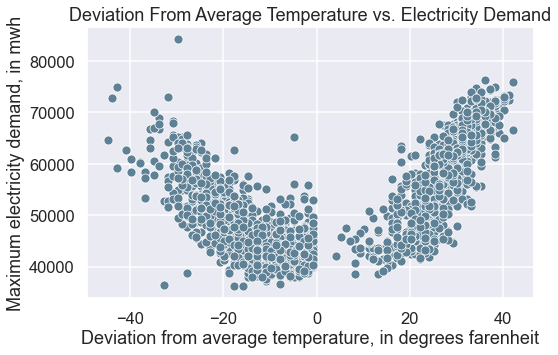

In [39]:
#Plot extreme vs. demand
fig,ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(
    data = demand_temp, 
    x = 'extreme', 
    y='demand',
    color=NEUTRAL)
plt.title('Deviation From Average Temperature vs. Electricity Demand')
plt.xlabel('Deviation from average temperature, in degrees farenheit')
plt.ylabel('Maximum electricity demand, in mwh');

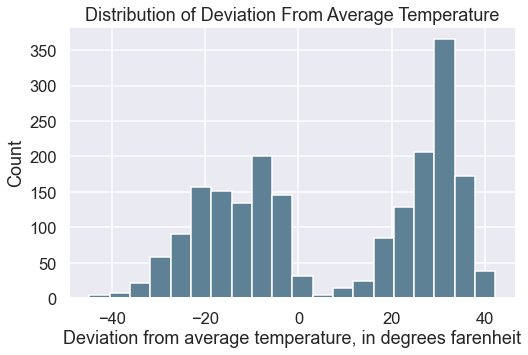

In [40]:
#Plot the distribution of extreme
demand_temp['extreme'].hist(
    figsize=(8,5), 
    bins=20,
    color=NEUTRAL
)
plt.title('Distribution of Deviation From Average Temperature')
plt.xlabel('Deviation from average temperature, in degrees farenheit')
plt.ylabel('Count');

There is definitely a correlation between temperature extremes and demand, with the relationship appearing stronger and more linear with the above-average temperatures than below.

It is clear there are two distinct populations, one for hot days and one for cold. I will split the data in two and perform regression on each one separately. 

In [41]:
#Create two different dataframes, one for hot days and one for cold.
demand_above = demand_temp[demand_temp['extreme']>0]
demand_below = demand_temp[demand_temp['extreme']<0]

## Stay Competitive With U.S. Market

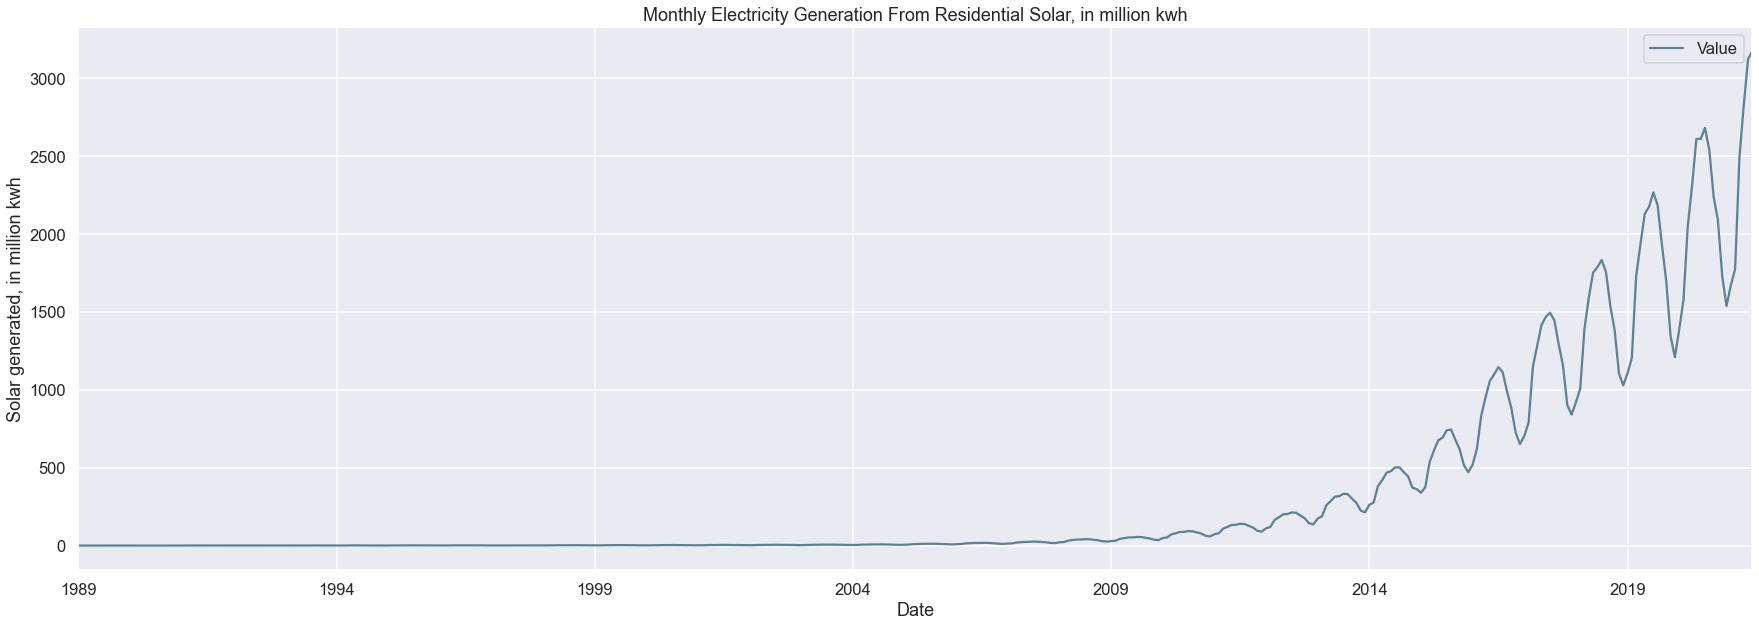

In [42]:
#Plot the solar data
us_solar.plot(figsize=(30,10), color=NEUTRAL)
plt.title('Monthly Electricity Generation From Residential Solar, in million kwh')
plt.xlabel('Date')
plt.ylabel('Solar generated, in million kwh');

# Data Preparation

For the time series data, the first goal is to check for stationarity and transform the data to make it more stationary by removing trend and/or seasonality. 

In [43]:
def plot_rolling(df, periods, name):
    """Takes in a data frame, the number of periods to use in a window and the
    name of the data and returns a plot of the orginial data with its rolling
    mean and standard deviation."""
    
    fig, ax = plt.subplots(figsize=(15,6))
    ax.plot(
        df, 
        label='Original Data',
        color=NEUTRAL
    )
    ax.plot(
        df.rolling(periods).mean(), 
        label='Rolling Mean',
        color=HIGHLIGHT
    )
    ax.plot(
        df.rolling(periods).std(), 
        label='Rolling Std',
        color=BRICK
    )
    ax.legend()
    plt.title(f'Rolling Mean and Standard Deviation for {name} Data')
    fig.tight_layout()
    
    return fig,ax

## Reduce Dependence on Imported Electricity

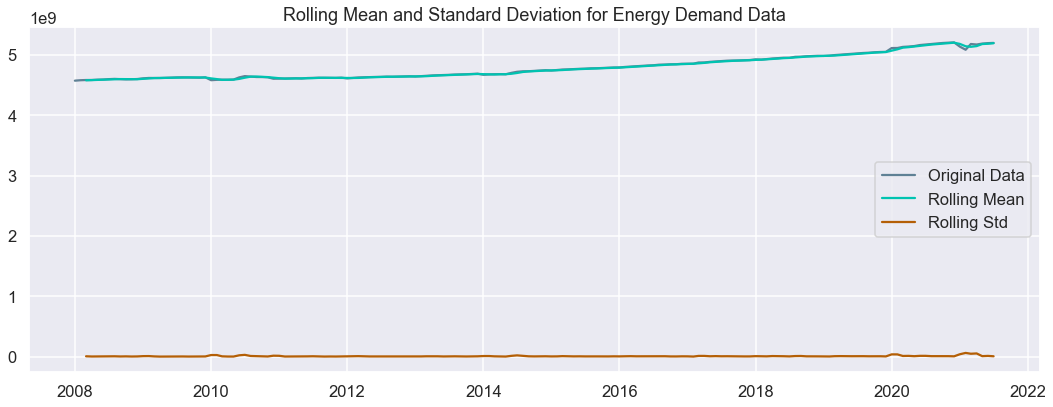

In [44]:
#Check the rolling mean and standard deviation of energy demand
plot_rolling(energy_demand, 3, 'Energy Demand');

The standard deviation is relativity consistent, which shows that there is little seasonality. However, the mean is not constant over time, showing a clear positive trend. 

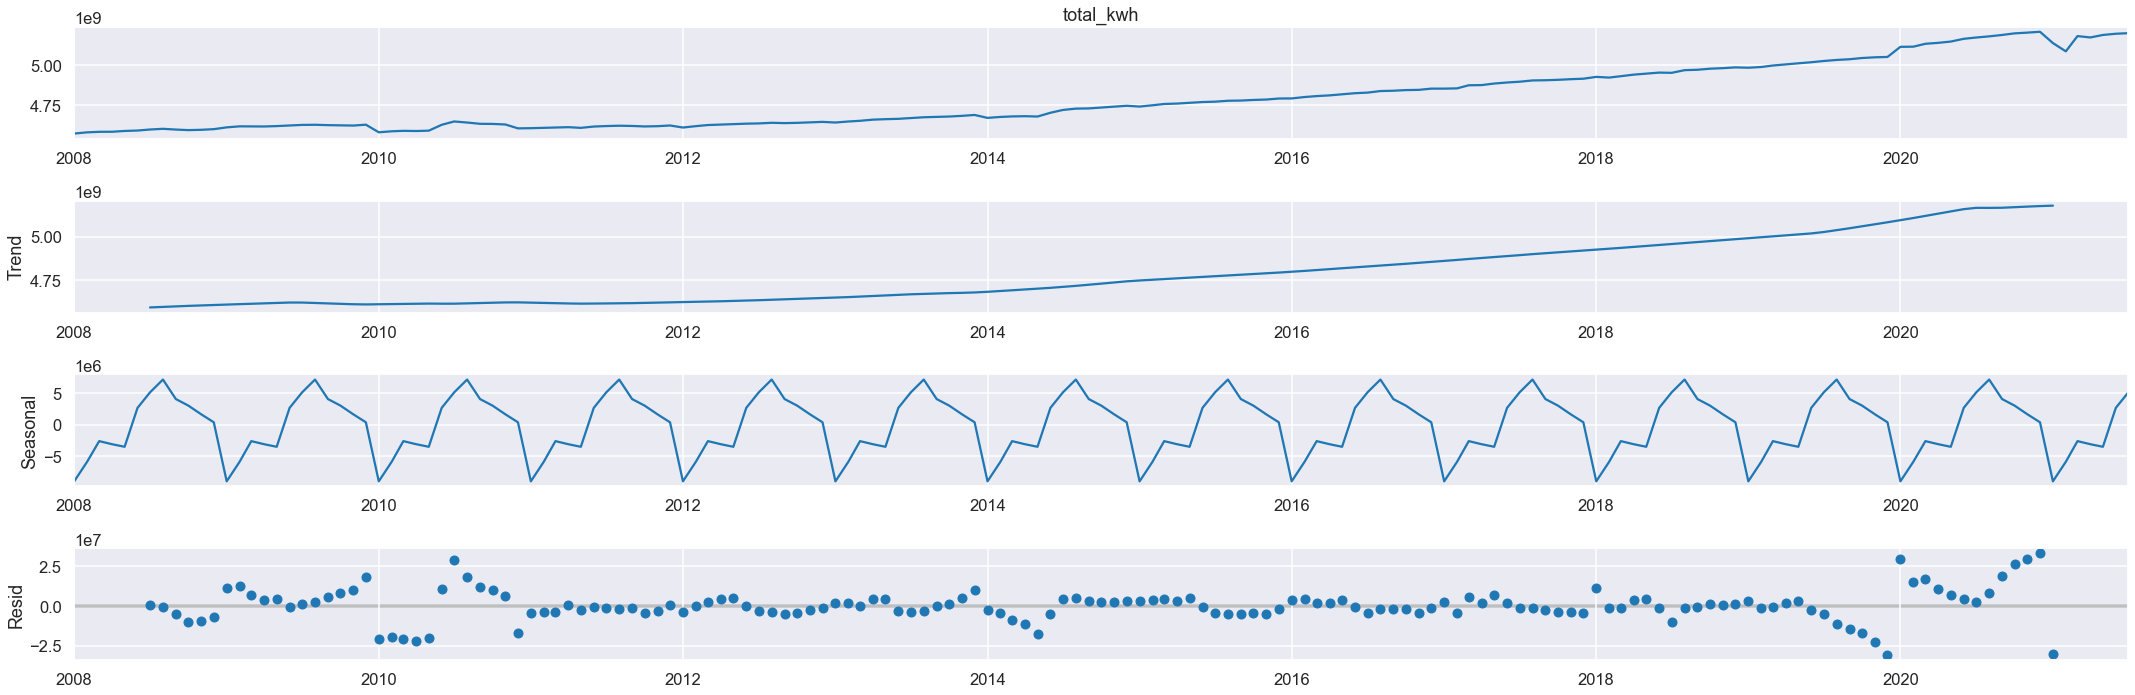

In [45]:
#Examine components of customer data
plt.rcParams['figure.figsize'] = 30,10
decompose = seasonal_decompose(energy_demand).plot()

The decomposition plot shows a seasonal pattern, but a strong seasonal variation would not be expected in the number of monthly customers. It appears that most of this data is trend, showing that it is increasing as a function of time.

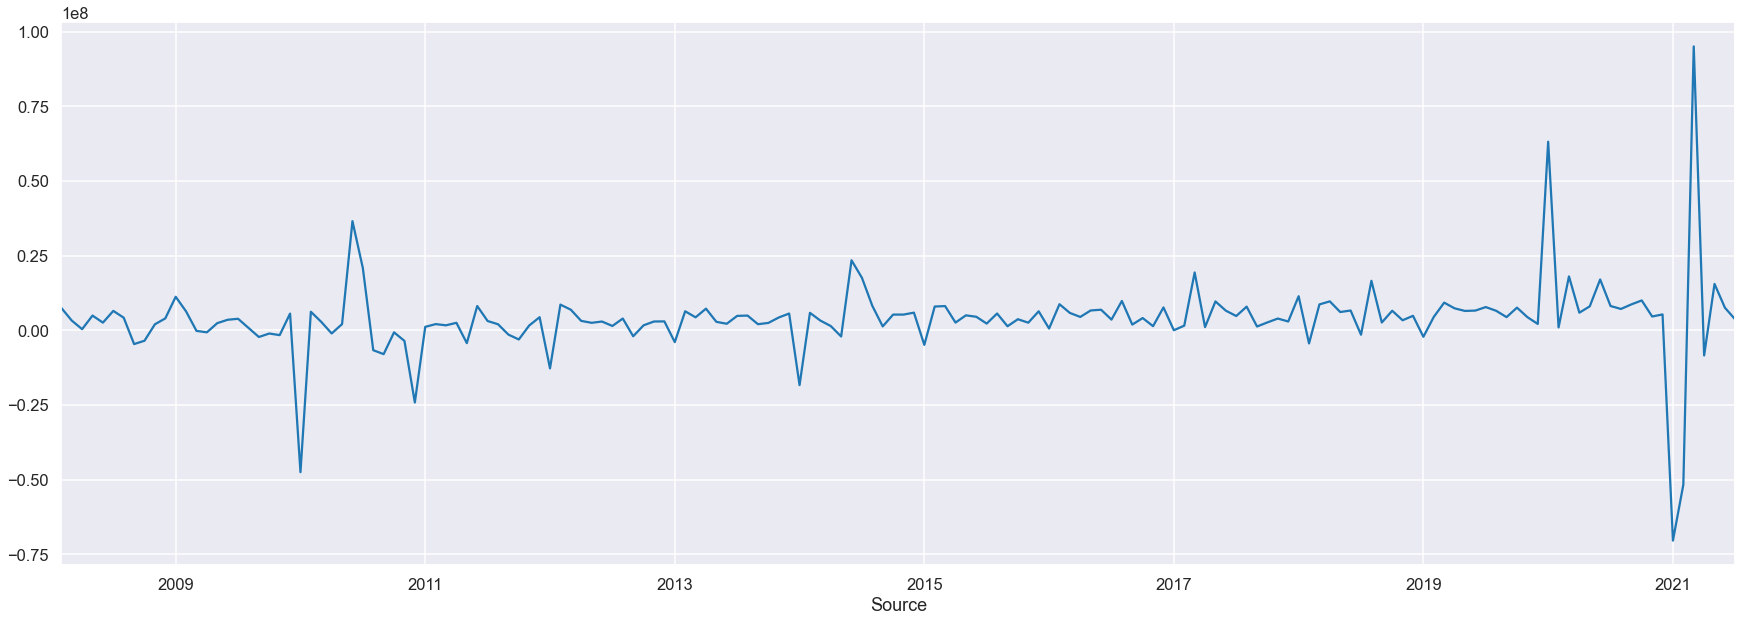

In [46]:
#Plot the first difference
demand_diff = energy_demand.diff().dropna().plot(figsize=(30,10))

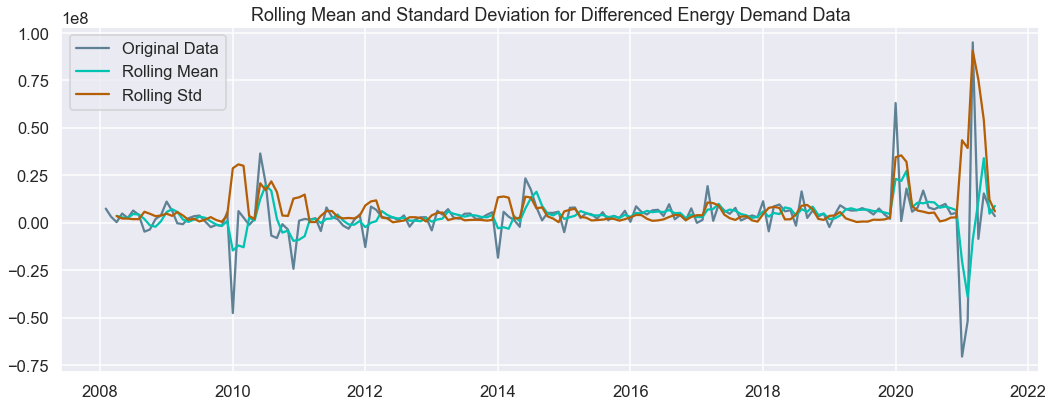

In [47]:
#Check the rolling mean and standard deviation of differenced energy demand
plot_rolling(energy_demand.diff().dropna(), 3, 'Differenced Energy Demand');

Taking the first difference removes the trend and shows that there is some variability that is not explained by the linear trend. The Dickey Fuller test confirms that taking the first difference makes the data more stationary (p-value of 0.14 vs 0.99), although it is still not stationary. 

In [48]:
print(f'p-value original data: {adfuller(energy_demand)[1]}')
print(f'p-value differenced data: {adfuller(energy_demand.diff().dropna())[1]}')
print(f'p-value logged and differenced data: {adfuller(np.log(energy_demand).diff().dropna())[1]}')
print(f'p-value root and differenced data: {adfuller(np.sqrt(energy_demand).diff().dropna())[1]}')

p-value original data: 0.9989690341772517
p-value differenced data: 0.142265483739356
p-value logged and differenced data: 0.13297539330146563
p-value root and differenced data: 0.13754444446141528


Logged data will be used because that improved the stationarity. 

In [49]:
#Split the data so that there are 12 years in the training set and just under 
#two years in the test set. 

demand_split = '2019-12-01'
log_demand = np.log(energy_demand)
demand_train = log_demand[:demand_split]
demand_test = log_demand[demand_split:]

demand_train.index = pd.DatetimeIndex(demand_train.index.values,
                               freq=demand_train.index.inferred_freq)

demand_train.shape, demand_test.shape

((144,), (20,))

This split means that the model is not trained on data during the pandemic. This means that it won't be effective at predicting the temporary volatility in residential energy demand caused by Covid, but that it will be better at picking up the overall longer term trends.

## Mitigate Impact of Rising Natural Gas Prices

In [50]:
#Because I am more concerned with longer-term trends than daily fluctuations, 
#the data will be resampled by weekly average price. This leaves 1447 observations.
gas_weekly = gas_price.resample('W').mean()
gas_weekly.describe()

avg_price
count  1447.000000
mean      4.085318
std       2.241451
min       1.435050
25%       2.495550
50%       3.285100
75%       4.990100
max      14.338250

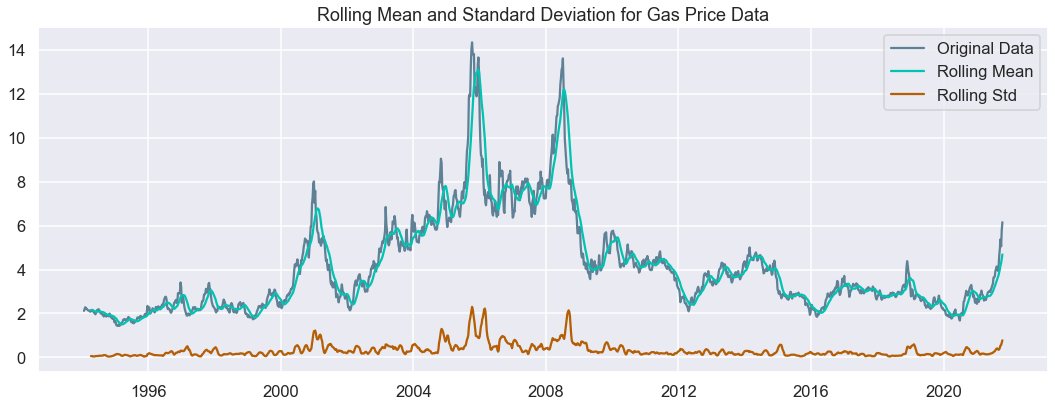

In [51]:
#Check the rolling mean and standard deviation of gas_prices
plot_rolling(gas_weekly, 12, 'Gas Price');

The rolling standard deviation again shows the increase in variability when the mean increases. The mean is certainly not constant and this data is not stationary.

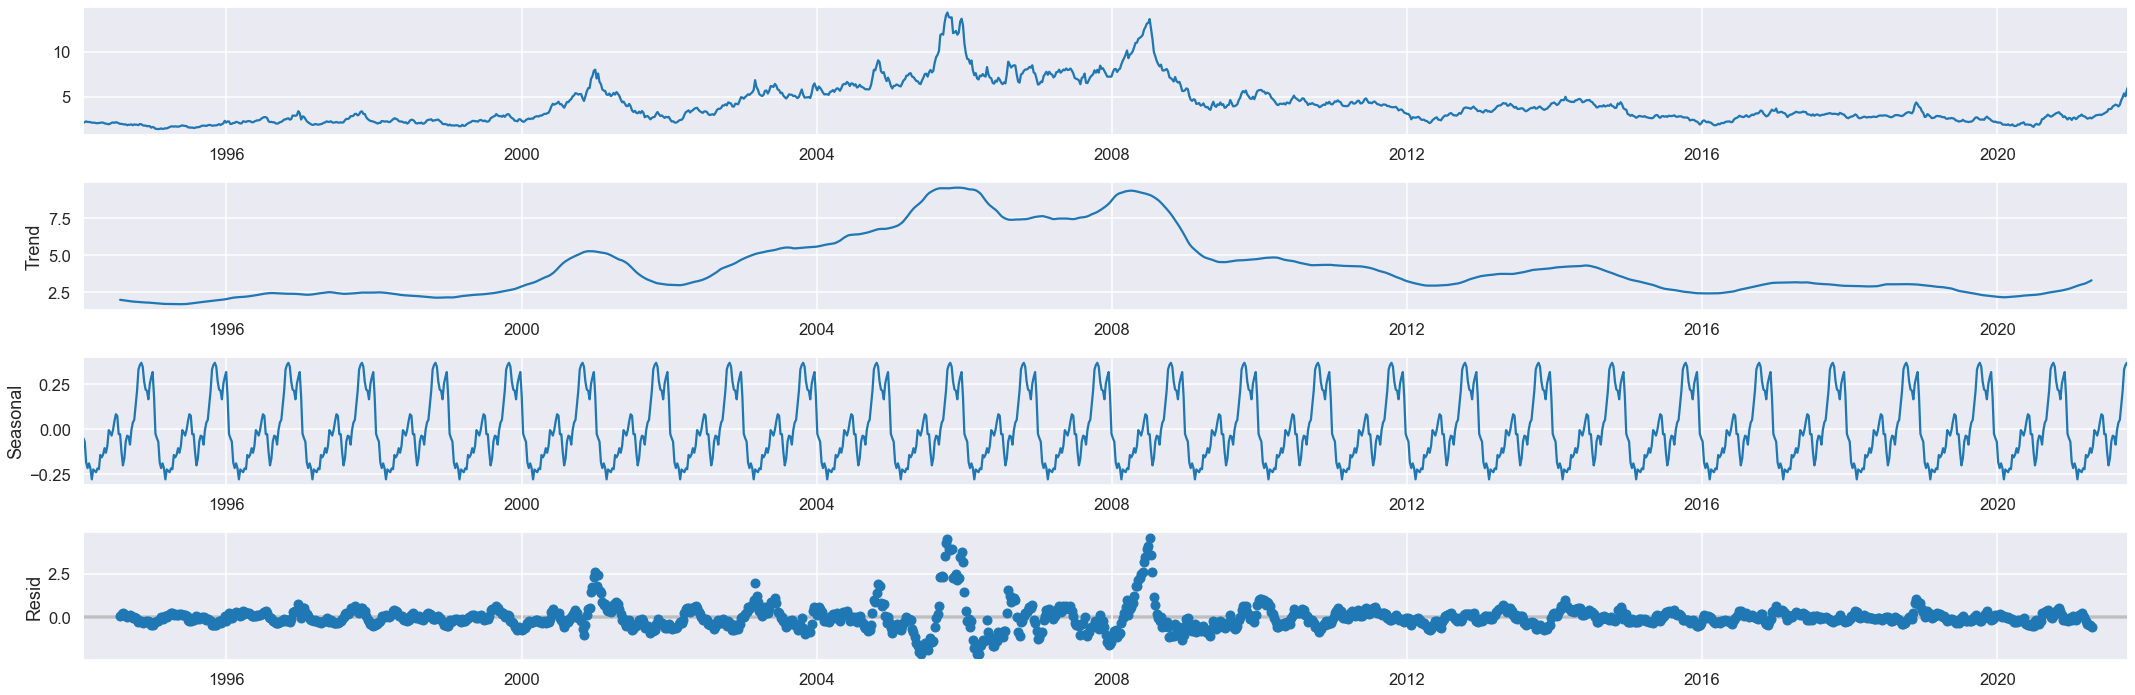

In [52]:
#Examine components of import data
plt.rcParams['figure.figsize'] = 30,10
decompose = seasonal_decompose(gas_weekly, model='additive').plot()

An additive model was used because the variance is not increasing over time. A seasonal trend is shown, which makes sense that gas prices would be higher during certain months due to demand.

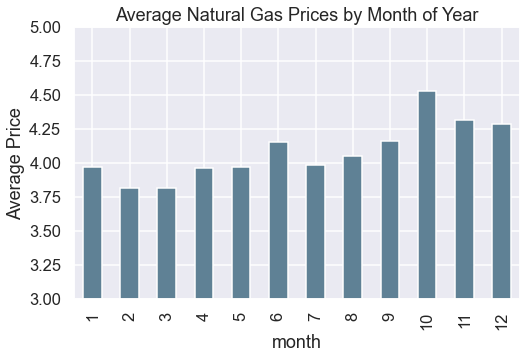

In [53]:
gas_month = gas_weekly.copy()
gas_month['month'] = gas_month.index.month
gas_month = gas_month.groupby('month').mean()
gas_month.plot(
    kind='bar', 
    figsize=(8,5), 
    color=NEUTRAL, 
    legend=None
)
plt.ylim(3,5)
plt.title('Average Natural Gas Prices by Month of Year')
plt.ylabel('Average Price');

In looking at the average gas prices by month of the year, prices are the highest in October - December.

<AxesSubplot:xlabel='Series Key'>

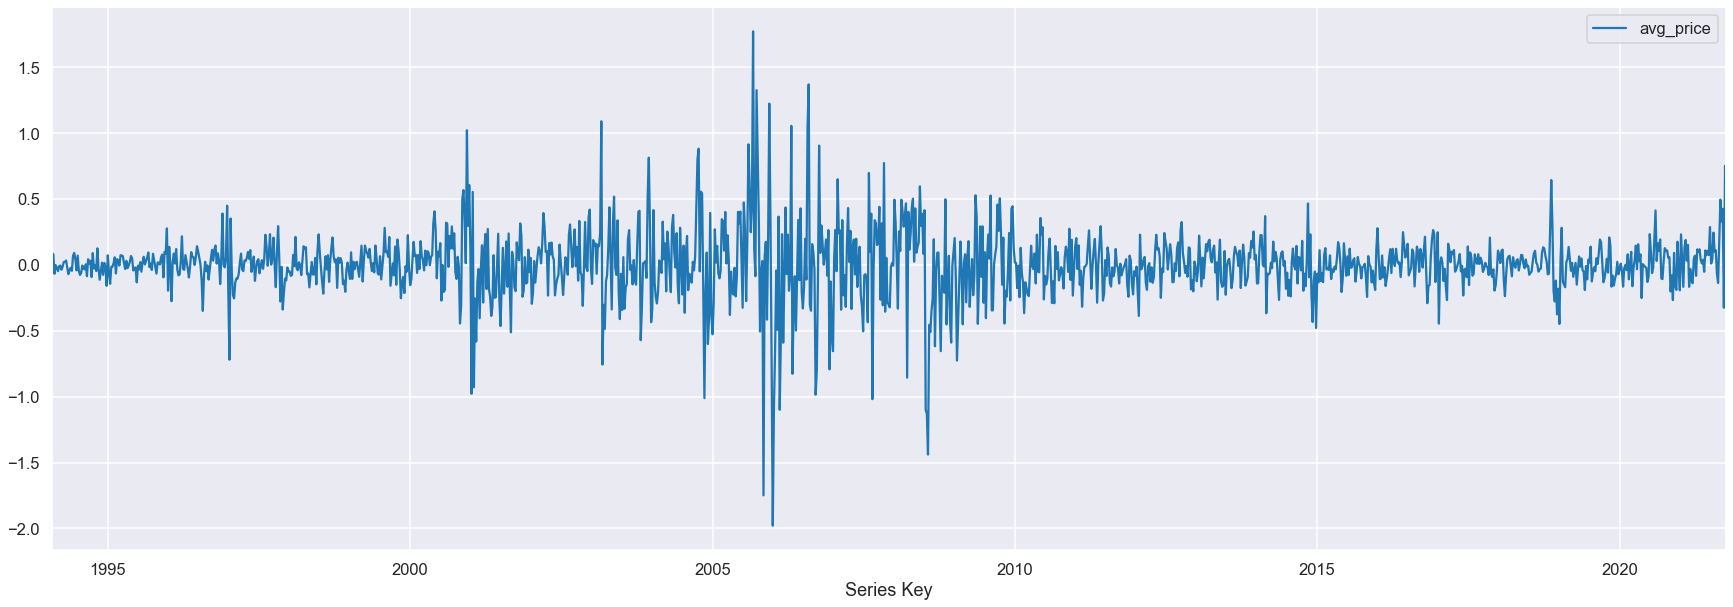

In [54]:
#Plot the first difference of the gas data.
gas_diff = gas_weekly.diff().dropna()
gas_diff.plot()

Taking the first difference made the mean more constant, but the standard deviation is still not constant.

<AxesSubplot:xlabel='Series Key'>

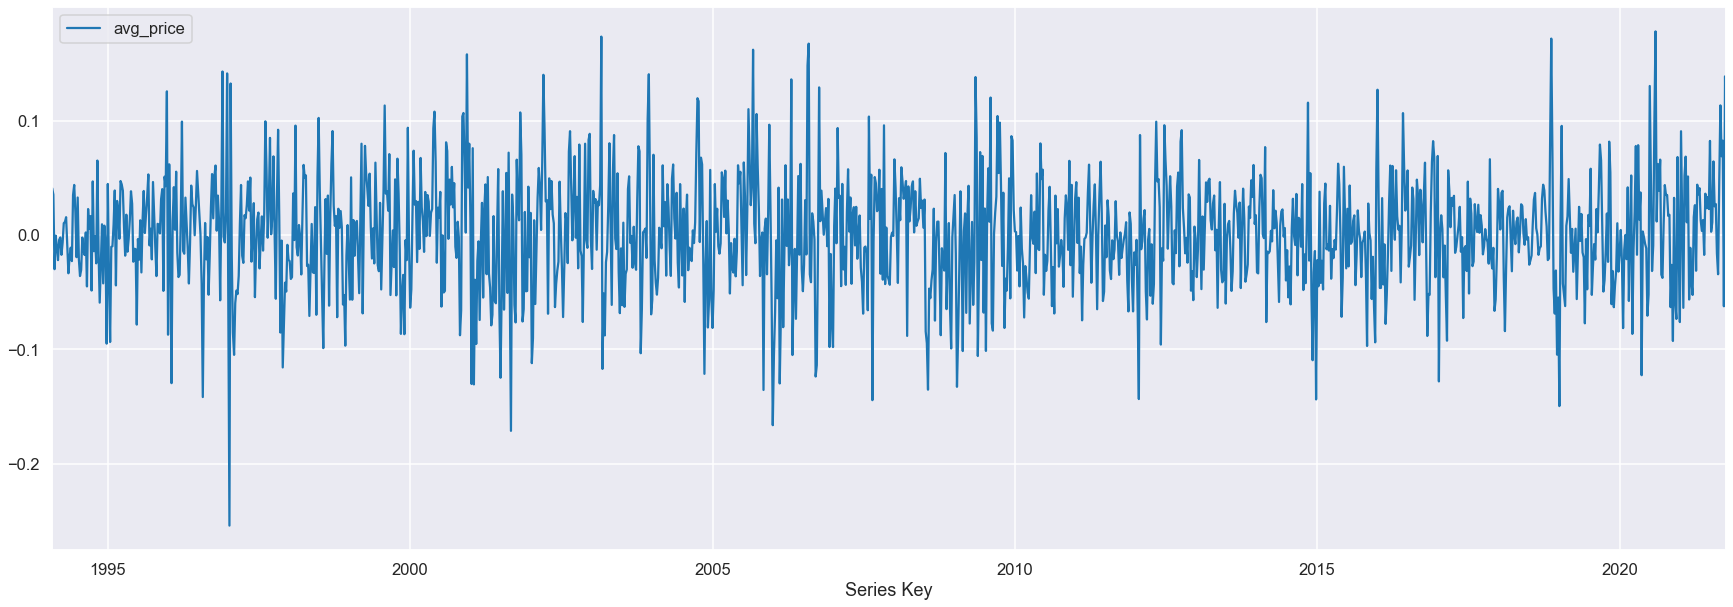

In [55]:
#Plot the first difference of the logged gas data
gas_log = np.log(gas_weekly).diff().dropna()
gas_log.plot()

This definitely appears to be more stationary, and that is confirmed with the Dickey-Fuller test.

In [56]:
print(f'p-value original data: {adfuller(gas_weekly)[1]}')
print(f'p-value differenced data: {adfuller(gas_diff)[1]}')
print(f'p-value differenced and logged data: {adfuller(gas_log)[1]}')

p-value original data: 0.06383113022106938
p-value differenced data: 1.0446890140370101e-22
p-value differenced and logged data: 0.0


Logged data will be used because that improved the stationarity. 

In [57]:
#Split the data so that the test set contains 145 weeks of data and the train 
#set has 1302 weeks. 
gas_weekly.columns = ['price']
logged_gas = np.log(gas_weekly)
gas_split = int(logged_gas.shape[0]*.90)
gas_train = logged_gas[:gas_split]
gas_test = logged_gas[gas_split:]

gas_test.shape, gas_train.shape

((145, 1), (1302, 1))

## Decrease Strain on Power Grid During High Demand Periods

In [58]:
#Select only the relevant columns.
demand_above_df = demand_above[['extreme','demand']]
demand_below_df = demand_below[['extreme', 'demand']]

demand_above_df.shape, demand_below_df.shape

((1041, 2), (1005, 2))

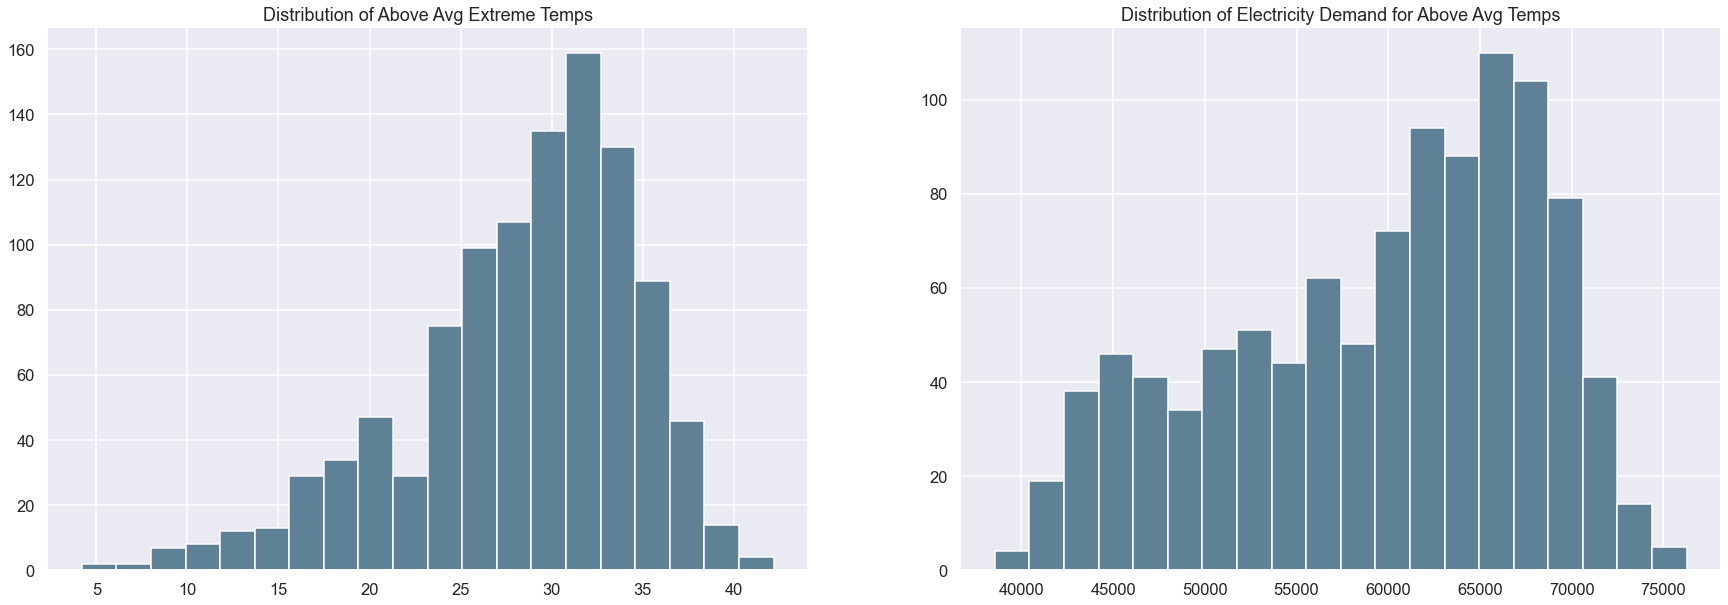

In [59]:
#Plot the histograms for the temperatures and energy demand on days with above-
#average temperatures.
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.hist(
    demand_above_df['extreme'], 
    bins=20, 
    color=NEUTRAL
)
ax1.set_title('Distribution of Above Avg Extreme Temps')
ax2.hist(
    demand_above_df['demand'], 
    bins=20, 
    color=NEUTRAL
)
ax2.set_title('Distribution of Electricity Demand for Above Avg Temps');

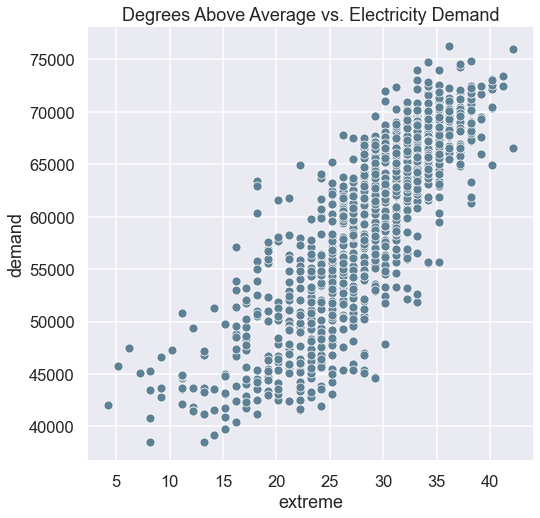

In [60]:
#Plot the scatterplot for demand vs degrees above average.
plt.subplots(figsize=(8,8))
sns.scatterplot(
    data=demand_above_df, 
    x='extreme', 
    y='demand', 
    color=NEUTRAL
)
plt.title('Degrees Above Average vs. Electricity Demand')
plt.xlabel('Degrees above avg of 58 degrees F')
plt.label('Residential electricity demand, mwh');

The data are definitely linear and have somewhat normal distributions, although both are slightly skewed left and demand is platykurtic. 

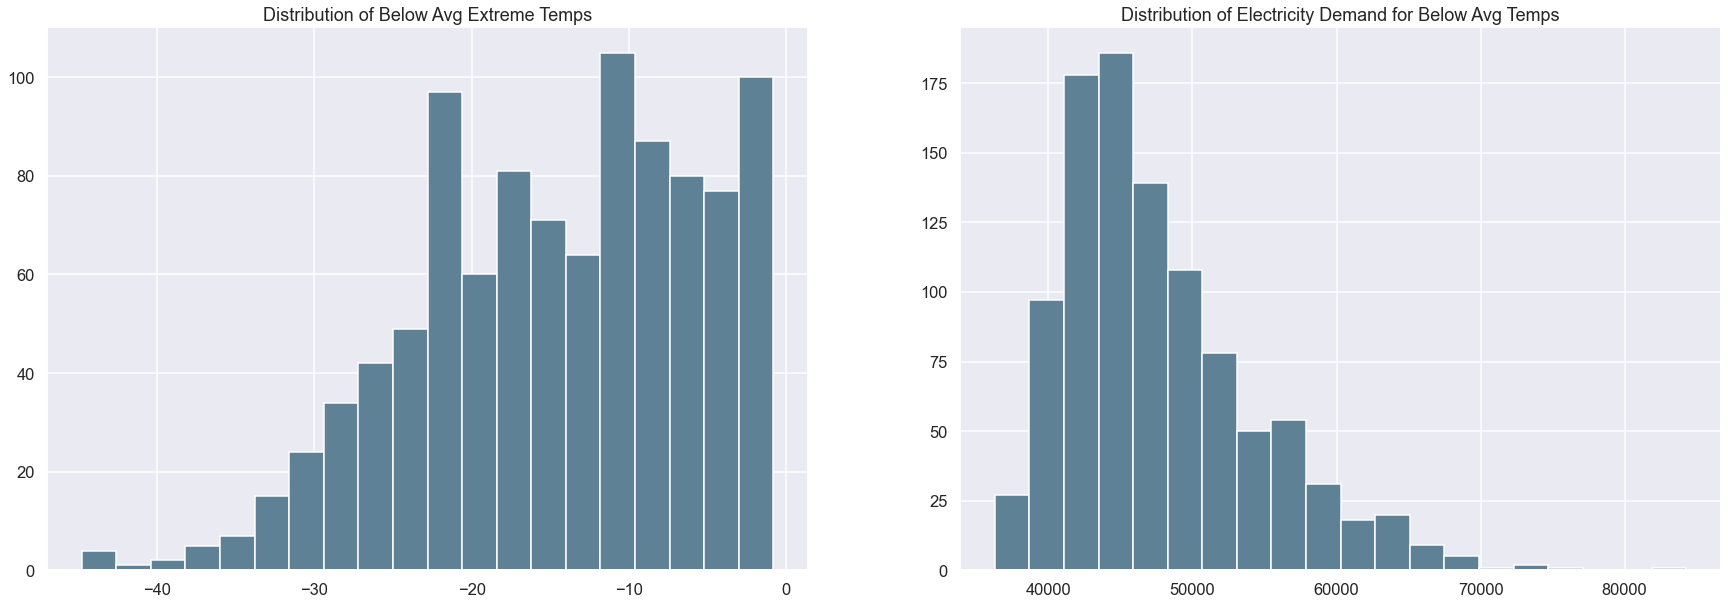

In [61]:
#Plot the histograms for the temperatures and energy demand on days with below-
#average temperatures.
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.hist(
    demand_below_df['extreme'], 
    bins=20, 
    color=NEUTRAL
)
ax1.set_title('Distribution of Below Avg Extreme Temps')
ax2.hist(
    demand_below_df['demand'], 
    bins=20, 
    color=NEUTRAL
)
ax2.set_title('Distribution of Electricity Demand for Below Avg Temps');

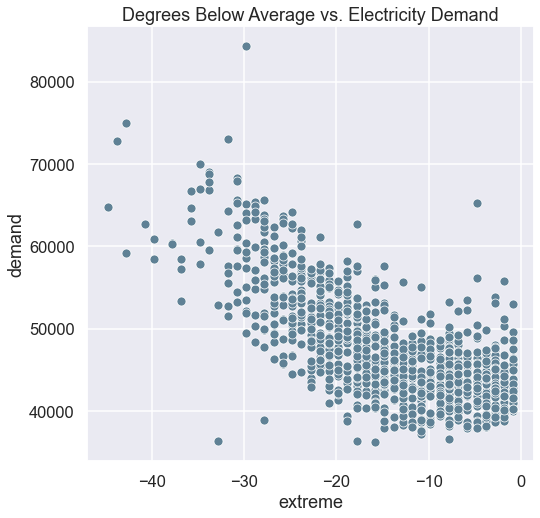

In [62]:
#Plot the scatterplot for demand vs degrees below average.
plt.subplots(figsize=(8,8))
sns.scatterplot(
    data=demand_below_df, 
    x='extreme', 
    y='demand', 
    color=NEUTRAL
)
plt.title('Degrees Below Average vs. Electricity Demand');

This relationship is not as linear and the data is less normally distributed.

In [63]:
def build_train_val_test(df, x='extreme', y='demand'):
    """Takes in a data frame and the feature and target column names and
    returns train, validation and test sets."""
    
    X = df.drop(y, axis=1)
    y = df[y]

    X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.3)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.5)

    print(f'X shapes: train, val, test: {X_train.shape},{X_val.shape},{X_test.shape}')
    print(f'y shapes: train, val, test: {y_train.shape},{y_val.shape},{y_test.shape}')
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [64]:
#Split the data for both above and below-average temperatures into train, 
#validation and test sets. 

(X_train_above, 
 X_val_above, 
 X_test_above, 
 y_train_above, 
 y_val_above, 
 y_test_above) = build_train_val_test(demand_above_df)

(X_train_below, 
 X_val_below, 
 X_test_below, 
 y_train_below, 
 y_val_below, 
 y_test_below) = build_train_val_test(demand_below_df)

X shapes: train, val, test: (728, 1),(156, 1),(157, 1)
y shapes: train, val, test: (728,),(156,),(157,)
X shapes: train, val, test: (703, 1),(151, 1),(151, 1)
y shapes: train, val, test: (703,),(151,),(151,)


## Stay Competitive With U.S. Market

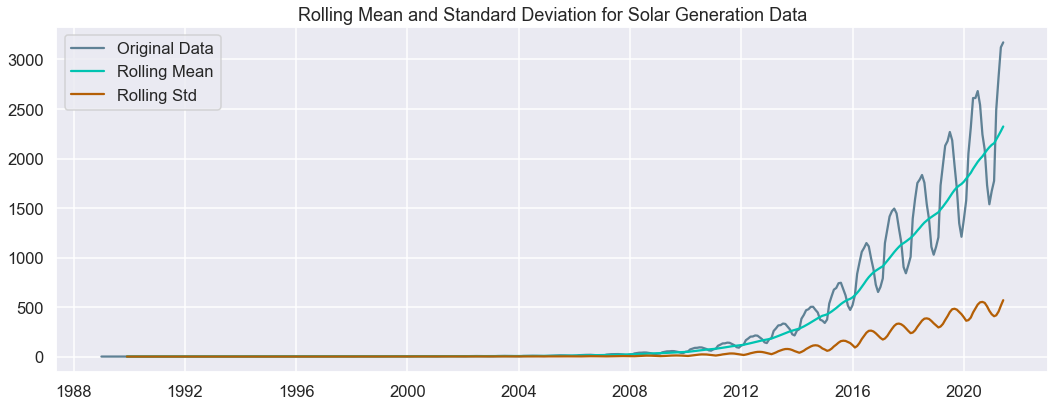

In [65]:
#Check the rolling mean and standard deviation of solar generation
plot_rolling(us_solar, 12, 'Solar Generation');

Both the mean and standard deviation are increasing. The data is non-stationary. 

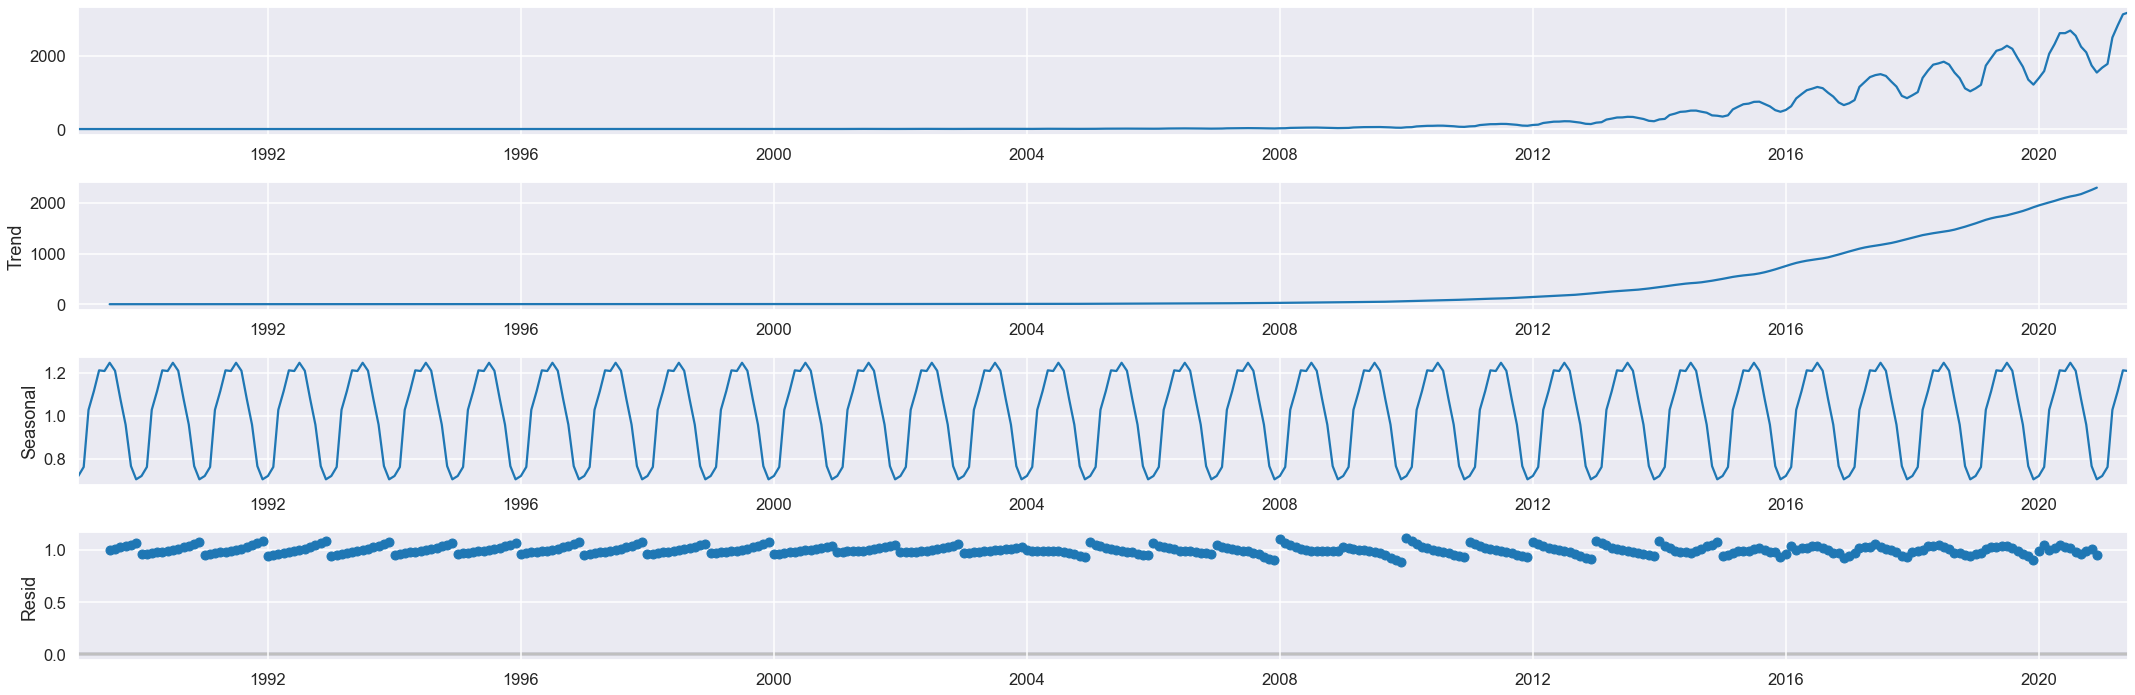

In [66]:
#Examine components of solar data
plt.rcParams['figure.figsize'] = 30,10
decompose = seasonal_decompose(us_solar, model = 'multiplicative').plot()

There is a clear positive trend and seasonality.

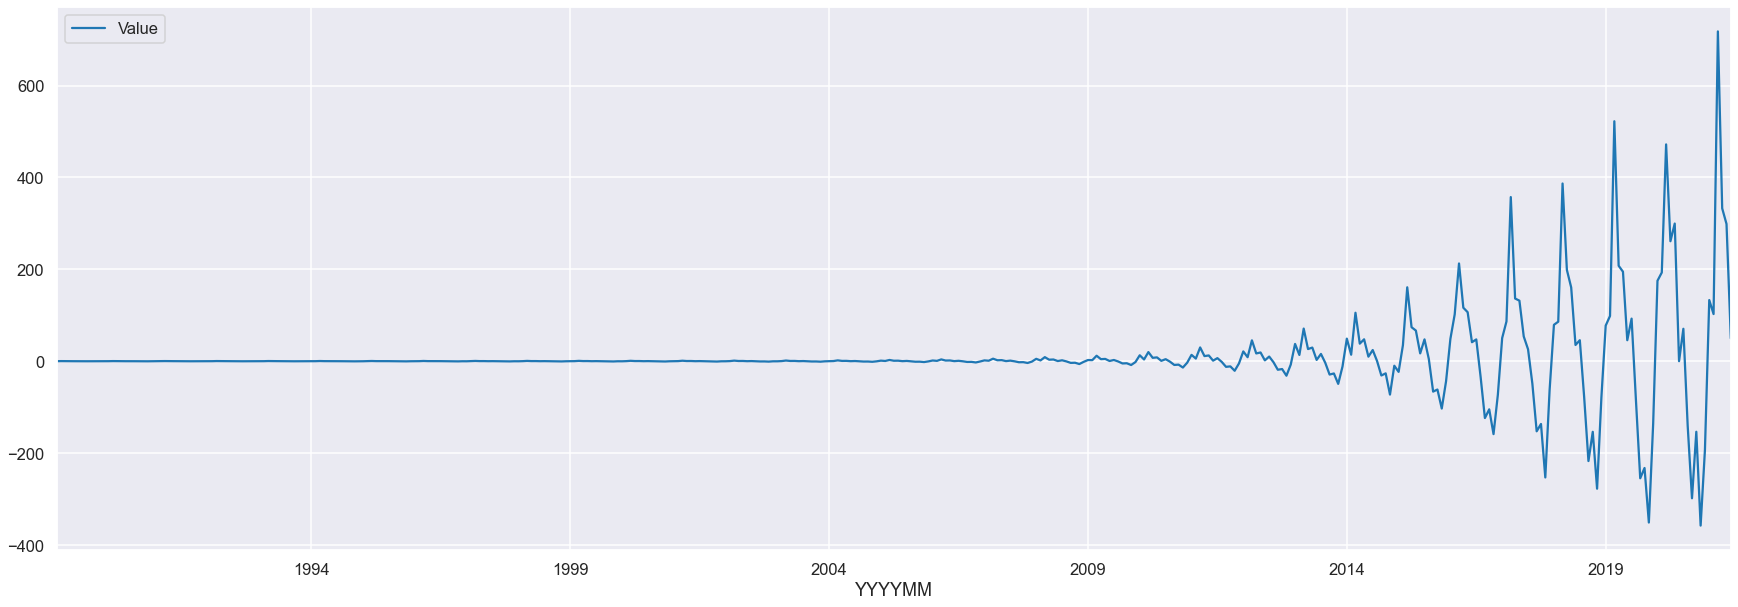

In [67]:
#Plot the first difference
solar_diff = us_solar.diff().dropna().plot(figsize=(30,10))

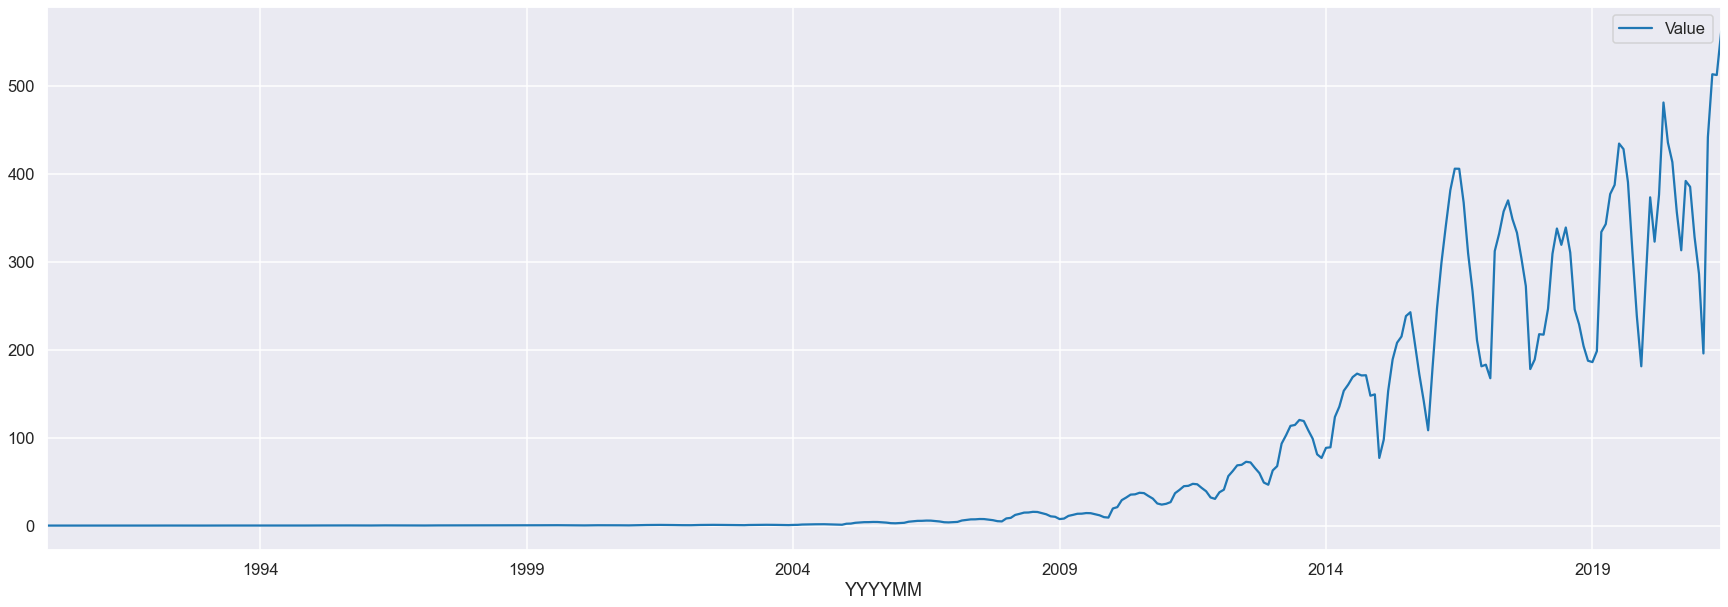

In [68]:
#Plot the annual difference (period=12)
solar_annual_diff = us_solar.diff(12).dropna().plot(figsize=(30,10))

Plotting the 1st and 12th differences show only a slight improvement in stationarity.

<AxesSubplot:xlabel='YYYYMM'>

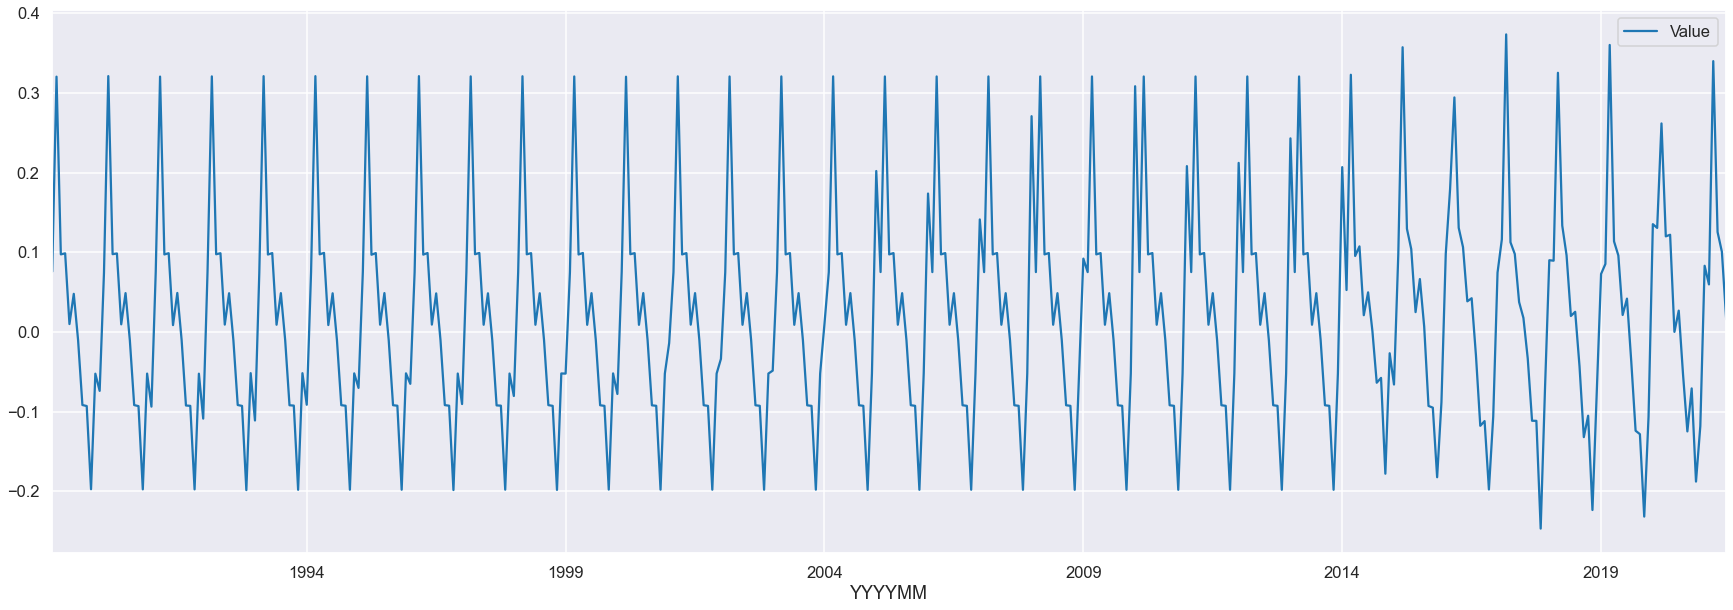

In [69]:
#Plot the first difference of the logged solar data.
np.log(us_solar).diff().dropna().plot(figsize=(30,10))

Taking both the log and the first difference seems to greatly improve the stationarity; however, clear seasonality is still apparent. 

In [70]:
print(f'p-value original data: {adfuller(us_solar)[1]}')
print(f'p-value differenced data: {adfuller(us_solar.diff().dropna())[1]}')
print(f'p-value logged and differenced data: {adfuller(np.log(us_solar).diff().dropna())[1]}')
print(f'p-value logged and annually differenced data: {adfuller(np.log(us_solar).diff(12).dropna())[1]}')

p-value original data: 0.9989484564402845
p-value differenced data: 0.9967076789673472
p-value logged and differenced data: 0.3448153235617447
p-value logged and annually differenced data: 0.6494754796181746


The Dickey-Fuller test confirms that the logged and first-differenced data is the most stationary, although the p-value greater than 0.05 confirms that it is not stationary. 

In [71]:
#Split the data so that there are 12 years in the training set and just under 
#two years in the test set.
us_solar.columns = ['actual']
solar_split = '2019-12-01'
log_solar = np.log(us_solar)
solar_train = log_solar[:solar_split]
solar_test = log_solar[solar_split:]

solar_train.shape, solar_test.shape

((372, 1), (19, 1))

# Modeling

## Helper Functions for Time Series

In [72]:
def grid_search(train, max_value, season, trend = None):
    """Takes in training data, the max value for p,d,q and a season,
    performs a grid search of the hyperparameters and returns the values with 
    the lowest AIC score."""
    
    p = d = q = range(0, max_value+1)

    pdq = [(ar, diff, ma) for ar in p for diff in d for ma in q]
    pdqs = [(c[0], c[1], c[2], season) for c in pdq]

# Iterate and try models.
 
    combo, value = (None, None)
    for pdq_combo in pdq:
        for pdqs_combo in pdqs:
            model = SARIMAX(
            train, 
            order=pdq_combo,
            seasonal_order=pdqs_combo,
            enforce_stationarity=False,
            enforce_invertibility=False,
            trend = trend
            )
            output = model.fit()

        if value is None or output.aic < value:
            combo, value = ((pdq_combo, pdqs_combo), output.aic)
        return combo, value

In [73]:
def get_fit(params, train):
    """Takes in the hyperparameters from grid_search and the train data and
    returns a fitted SARIMAX model."""
    
    or_params = params[0][0]
    so_params = params[0][1]
    model = SARIMAX(
        train, 
        order=or_params, 
        seasonal_order=so_params,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted_model = model.fit()
    return fitted_model


In [74]:
def predict_and_score(fitted_model, test):
    """Takes in a fitted SARIMAX model and a test set, prints the RMSE and 
    returns the precitions and the RMSE."""
    
    predictions = fitted_model.forecast(steps=test.shape[0])
    rmse = round(np.sqrt(mean_squared_error(test, predictions)),3)
    print(f'The RMSE is {rmse}.')
    return predictions, rmse

In [75]:
def diagnostic_plot(fitted_model):
    """Takes in a fitted model and returns the plot diagnostics."""
    
    plt.rc("figure", figsize=(16,10))
    plt.tight_layout()
    diagnostics = fitted_model.plot_diagnostics()
    return diagnostics

In [198]:
def plot_forecast(train, test, fitted_model, steps, title, ylabel):
    """Takes in a train set, test set, fitted model, number of steps, title
    and ylabel and constructs a forecast of step length and plots the actual 
    data along with the forecasted data. Returns the forecast and the figure.
    """
    
    fig, ax = plt.subplots(figsize=(15, 5))

    # Plot the data 
    train.plot(
        ax=ax, 
        color=DARK_NEUTRAL, 
        label='actual (train)'
    )
    test.plot(
        ax=ax, 
        color=NEUTRAL, 
        label='actual (test)'
    )

    # Construct the forecasts
    fcast = fitted_model.get_forecast(
        steps=steps, 
        dynamic=True).summary_frame()
    fcast['mean'].plot(
        ax=ax, 
        style='k--', 
        label='forecasted')
    ax.fill_between(
        fcast.index, 
        fcast['mean_ci_lower'], 
        fcast['mean_ci_upper'], 
        color=HIGHLIGHT, 
        alpha=0.1);
    plt.xlabel(
        'Date', 
        weight='bold'
    )
    plt.ylabel(
        ylabel, 
        weight='bold'
    )
    plt.title(
        f'Forecasted {title}', 
        weight='bold', 
        size='large'
    )
    ax.legend()
    return fcast, (fig,ax)

## Reduce Dependence on Imported Electricity

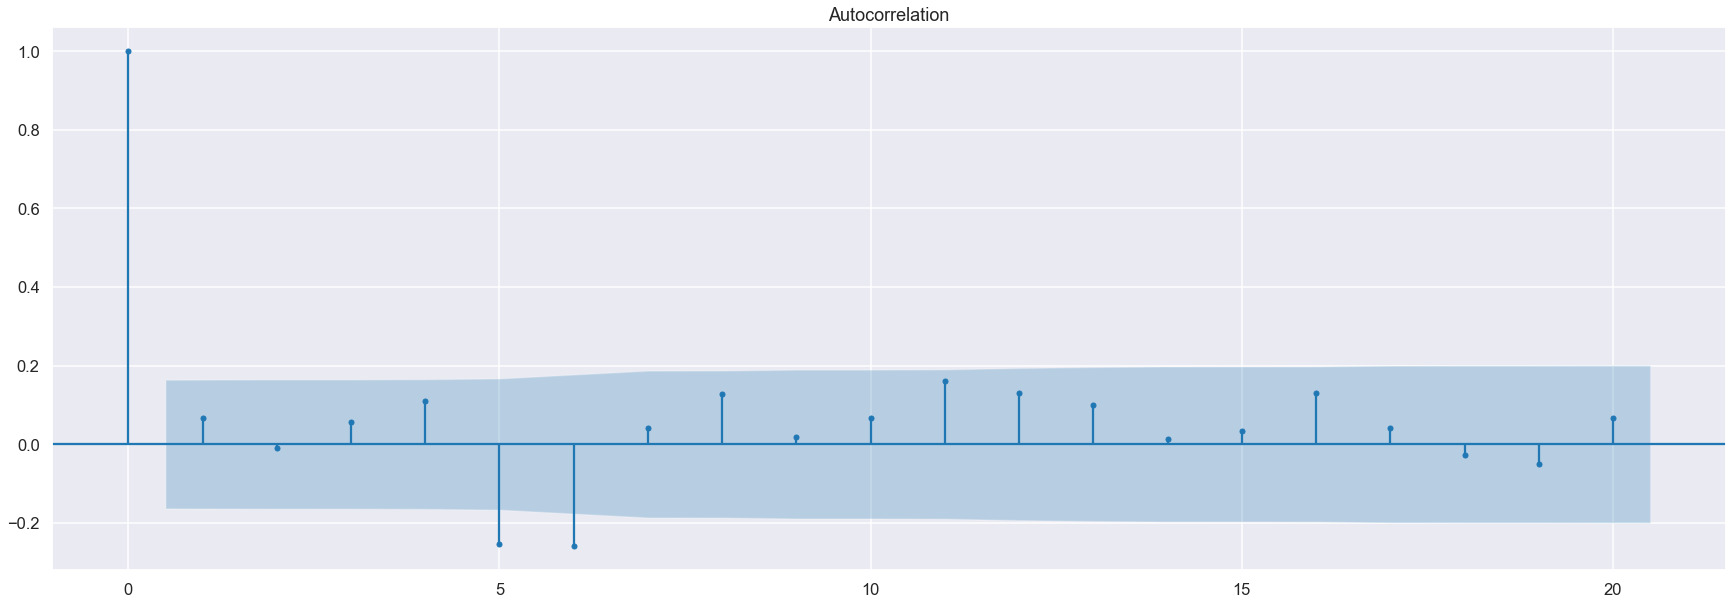

In [77]:
#Examine the autocorrelation function for the differenced customers data.
acf_demand_diff = plot_acf(demand_train.diff().dropna(), lags=20)

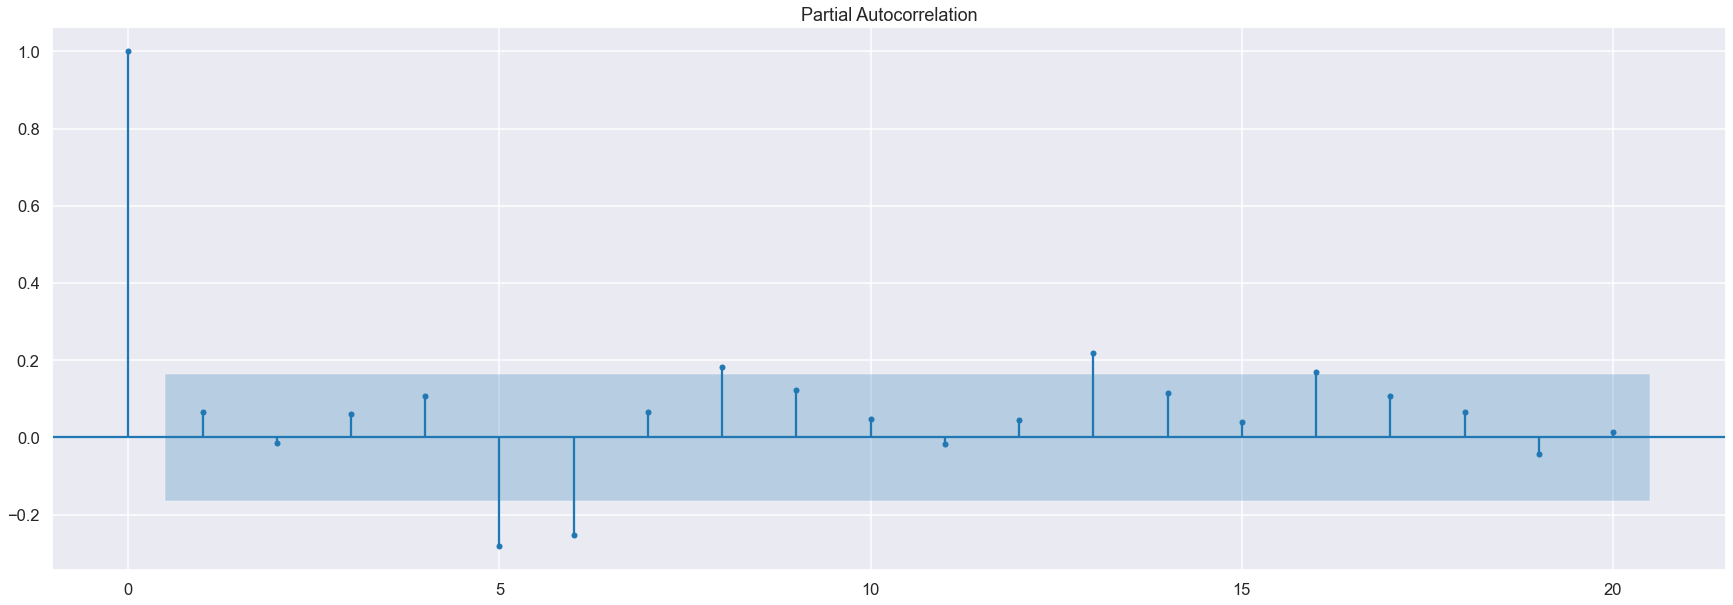

In [78]:
pacf_demand_diff = plot_pacf(demand_train.diff().dropna(), lags=20)

Based on the acf and pacf plots, there may be a significant AR and/or MA value at lag 5 or 6.

### Naive Model

In [79]:
#Create a naive model that predicts the train mean. 
naive_pred = [demand_train.mean() for n in range(len(demand_test))]
naive_rmse = round(np.sqrt(mean_squared_error(demand_test, naive_pred)),3)
print(f'The naive RMSE is {naive_rmse}.')

The naive RMSE is 0.085.


### Simple AR Model (With a First Difference)

In [80]:
#AR model with a lag of 5 and a first difference.
AR_model = SARIMAX(
    demand_train,
    order = (5,1,0) 
)
AR_fit = AR_model.fit()
AR_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              total_kwh   No. Observations:                  144
Model:               SARIMAX(5, 1, 0)   Log Likelihood                 713.117
Date:                Fri, 22 Oct 2021   AIC                          -1414.234
Time:                        06:35:48   BIC                          -1396.457
Sample:                    01-01-2008   HQIC                         -1407.011
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1730      0.056      3.078      0.002       0.063       0.283
ar.L2          0.0859      0.090      0.953      0.340      -0.091       0.262
ar.L3          0.1369      0.095      1.437      0.151      -0.050       0.324
ar.L4          0.2061      0.080      2.584      0.010       0.050       0.362
ar.L5         -0.1898      0.045     -4.212      0.000      -0.278      -0.101
sigma2      2.719e-06    1.4e-07     19.425      0.000    2.44e-06    2.99e-06
===================================================================================
Ljung-Box (L1) (Q):                   1.11   Jarque-Bera (JB):              1269.41
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                            -2.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [81]:
AR_pred, AR_rmse = predict_and_score(AR_fit, demand_test)

The RMSE is 0.022.


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 1152x720 with 0 Axes>

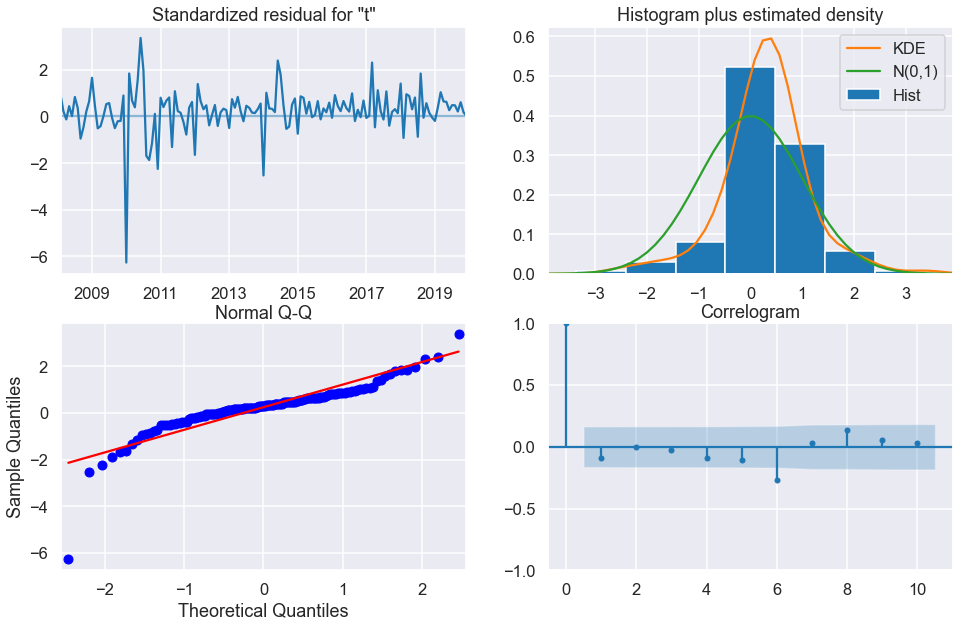

In [82]:
AR_diagnostic = diagnostic_plot(AR_fit)

The residuals have a leptokurtic distribution, which is likely from the Covid-related variability that the model did not account for. The correlogram suggests that the model is accounting for most of the information in the data; however, the significant lag at 6 indicate that there may be some seasonality that is not being addressed. 

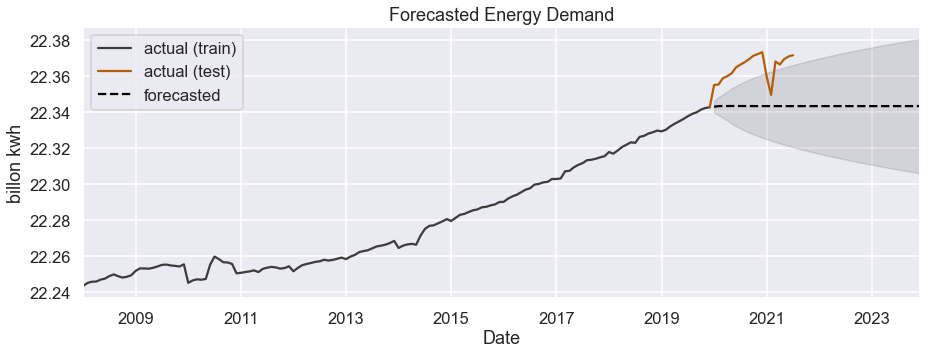

In [83]:
AR_fcast, AR_fcast_plt = plot_forecast(
    demand_train, 
    demand_test, 
    AR_fit, 
    48,
    'Energy Demand',
    'billon kwh')

Based on the predictions, it is clear that the model is not capturing the increasing trend. 

### AR Model With Trend

In [84]:
#AR model with linear trend hyperparamter added.
ARt_model = SARIMAX(
    demand_train,
    order = (5,1,0),
    trend='t'
)
ARt_fit = ARt_model.fit()
ARt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              total_kwh   No. Observations:                  144
Model:               SARIMAX(5, 1, 0)   Log Likelihood                 725.363
Date:                Fri, 22 Oct 2021   AIC                          -1436.725
Time:                        06:35:49   BIC                          -1415.986
Sample:                    01-01-2008   HQIC                         -1428.298
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       1.128e-05   2.97e-06      3.798      0.000    5.46e-06    1.71e-05
ar.L1          0.0393      0.058      0.677      0.498      -0.074       0.153
ar.L2         -0.0520      0.141     -0.370      0.712      -0.328       0.224
ar.L3         -0.0081      0.128     -0.064      0.949      -0.258       0.242
ar.L4          0.0703      0.122      0.575      0.565      -0.169       0.310
ar.L5         -0.3163      0.046     -6.897      0.000      -0.406      -0.226
sigma2      2.345e-06    1.1e-07     21.288      0.000    2.13e-06    2.56e-06
===================================================================================
Ljung-Box (L1) (Q):                   1.46   Jarque-Bera (JB):              1779.87
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               0.20   Skew:                            -2.39
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [85]:
ARt_pred, ARt_rmse = predict_and_score(ARt_fit, demand_test)

The RMSE is 0.01.


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 1152x720 with 0 Axes>

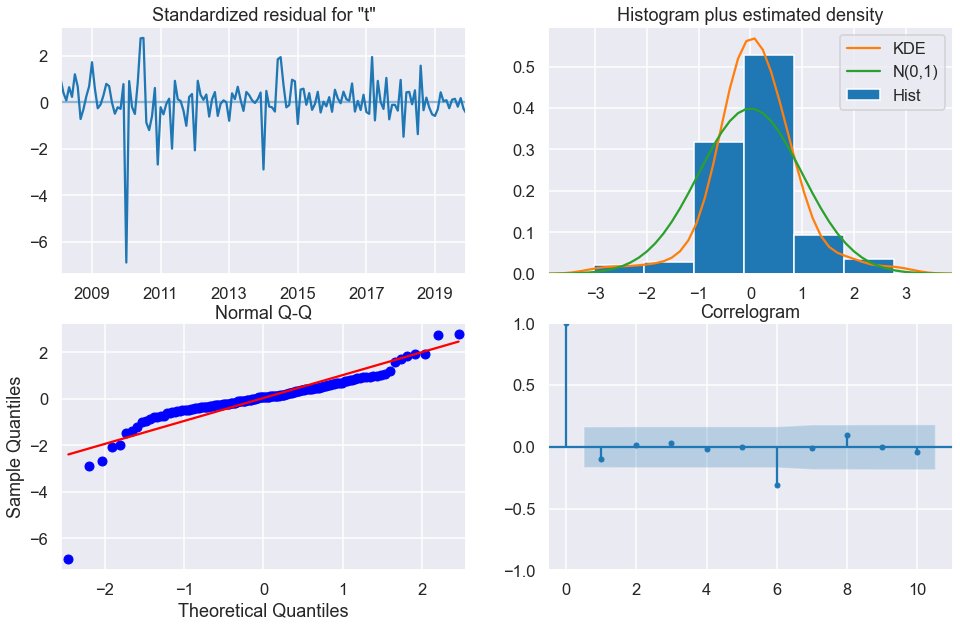

In [86]:
ARt_diagnostic = diagnostic_plot(ARt_fit)

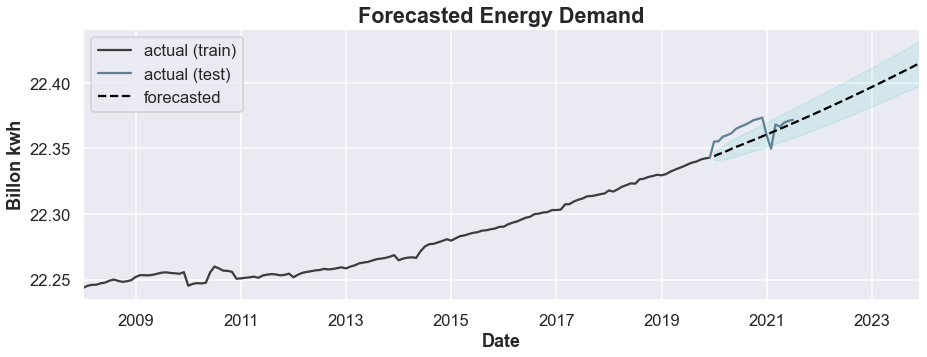

In [199]:
ARt_fcast, ARt_fcast_plt = plot_forecast(
    demand_train, 
    demand_test, 
    ARt_fit, 
    48,
    'Energy Demand',
    'Billon kwh')

The diagnostics still show that there is information that the model is not capturing. This is also clear on the forecast plot, where the temporary increase in residential demand is not picked up by the model. However, the model appears to do quite well at generalizing the overall trend. 

The only significant AR value is at lag 5, indicating that the demand 5 months ago is predictive of the demand in the current month.

### SARIMA Model Without Trend

In [88]:
#Run a grid search for hyperparameters if the file is not in the directory.
if 'demand_params.joblib' in os.listdir('files'):
    demand_params = joblib.load('files/demand_params.joblib')
else:
    demand_params = grid_search(demand_train, 5, 12)
    joblib.dump(demand_params, 'files/demand_params.joblib')

In [89]:
#Fit and summarize the model
SARIMA_fit = get_fit(demand_params, demand_train)
SARIMA_fit.summary()

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                              total_kwh   No. Observations:                  144
Model:             SARIMAX(5, 5, [1, 2, 3, 4, 5], 12)   Log Likelihood                  61.843
Date:                                Fri, 22 Oct 2021   AIC                           -101.686
Time:                                        06:36:29   BIC                            -89.195
Sample:                                    01-01-2008   HQIC                           -98.544
                                         - 12-01-2019                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0002      1.079      0.000      1.000      -2.115       2.115
ar.S.L24      -0.0003      1.899     -0.000      1.000      -3.722       3.721
ar.S.L36      -0.0002      1.804  -8.78e-05      1.000      -3.536       3.536
ar.S.L48      -0.0004      1.147     -0.000      1.000      -2.248       2.247
ar.S.L60      -0.0004      0.528     -0.001      0.999      -1.036       1.035
ma.S.L12       0.0006      0.253      0.003      0.998      -0.495       0.496
ma.S.L24       0.0001      0.512      0.000      1.000      -1.004       1.004
ma.S.L36       0.0002      0.354      0.000      1.000      -0.693       0.693
ma.S.L48   -1.489e-05      0.067     -0.000      1.000      -0.132       0.132
ma.S.L60    -9.37e-05      0.029     -0.003      0.997      -0.057       0.056
sigma2      1.849e-06   1.24e-06      1.490      0.136   -5.83e-07    4.28e-06
===================================================================================
Ljung-Box (L1) (Q):                  13.65   Jarque-Bera (JB):                 2.19
Prob(Q):                              0.00   Prob(JB):                         0.33
Heteroskedasticity (H):               0.16   Skew:                            -0.65
Prob(H) (two-sided):                  0.02   Kurtosis:                         2.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.43e+19. Standard errors may be unstable.
"""

In [90]:
#Score the model
SARIMA_pred, SARIMA_rmse = predict_and_score(SARIMA_fit, demand_test)

The RMSE is 0.029.


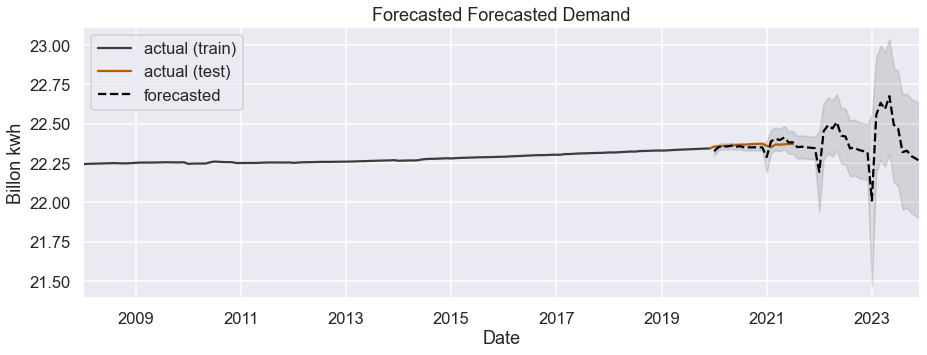

In [91]:
#Plot the forecast
SARIMA_fcast, SARIMA_fcast_plt = plot_forecast(
    demand_train, 
    demand_test, 
    SARIMA_fit, 
    48,
    'Forecasted Demand',
    'Billon kwh')

The p-values for the coefficients are at or near 1, indicating that they are not significant. The forecast also shows that the model is not generalizing well. 

### SARIMA Model With Trend

In [92]:
if 'demandtr_params.joblib' in os.listdir('files'):
    demandtr_params = joblib.load('files/demandtr_params.joblib')
else:
    demandtr_params = grid_search(demand_train, 5, 12, trend='t')
    joblib.dump(demandtr_params, 'files/demandtr_params.joblib')

In [93]:
SARIMAtr_fit = get_fit(demandtr_params, demand_train)
SARIMAtr_fit.summary()

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                              total_kwh   No. Observations:                  144
Model:             SARIMAX(5, 5, [1, 2, 3, 4, 5], 12)   Log Likelihood                  61.843
Date:                                Fri, 22 Oct 2021   AIC                           -101.686
Time:                                        06:37:07   BIC                            -89.195
Sample:                                    01-01-2008   HQIC                           -98.544
                                         - 12-01-2019                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0002      1.079      0.000      1.000      -2.115       2.115
ar.S.L24      -0.0003      1.899     -0.000      1.000      -3.722       3.721
ar.S.L36      -0.0002      1.804  -8.78e-05      1.000      -3.536       3.536
ar.S.L48      -0.0004      1.147     -0.000      1.000      -2.248       2.247
ar.S.L60      -0.0004      0.528     -0.001      0.999      -1.036       1.035
ma.S.L12       0.0006      0.253      0.003      0.998      -0.495       0.496
ma.S.L24       0.0001      0.512      0.000      1.000      -1.004       1.004
ma.S.L36       0.0002      0.354      0.000      1.000      -0.693       0.693
ma.S.L48   -1.489e-05      0.067     -0.000      1.000      -0.132       0.132
ma.S.L60    -9.37e-05      0.029     -0.003      0.997      -0.057       0.056
sigma2      1.849e-06   1.24e-06      1.490      0.136   -5.83e-07    4.28e-06
===================================================================================
Ljung-Box (L1) (Q):                  13.65   Jarque-Bera (JB):                 2.19
Prob(Q):                              0.00   Prob(JB):                         0.33
Heteroskedasticity (H):               0.16   Skew:                            -0.65
Prob(H) (two-sided):                  0.02   Kurtosis:                         2.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.43e+19. Standard errors may be unstable.
"""

In [94]:
SARIMAtr_pred, SARIMAtr_rmse = predict_and_score(SARIMAtr_fit, demand_test)

The RMSE is 0.029.


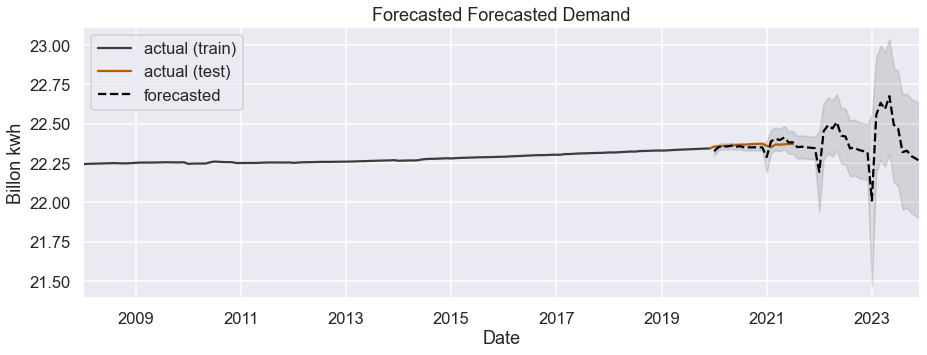

In [95]:
SARIMAtr_fcast, SARIMAtr_fcast_plt = plot_forecast(
    demand_train, 
    demand_test, 
    SARIMAtr_fit, 
    48,
    'Forecasted Demand',
    'Billon kwh')

## Mitigate Impact of Rising Natural Gas Prices

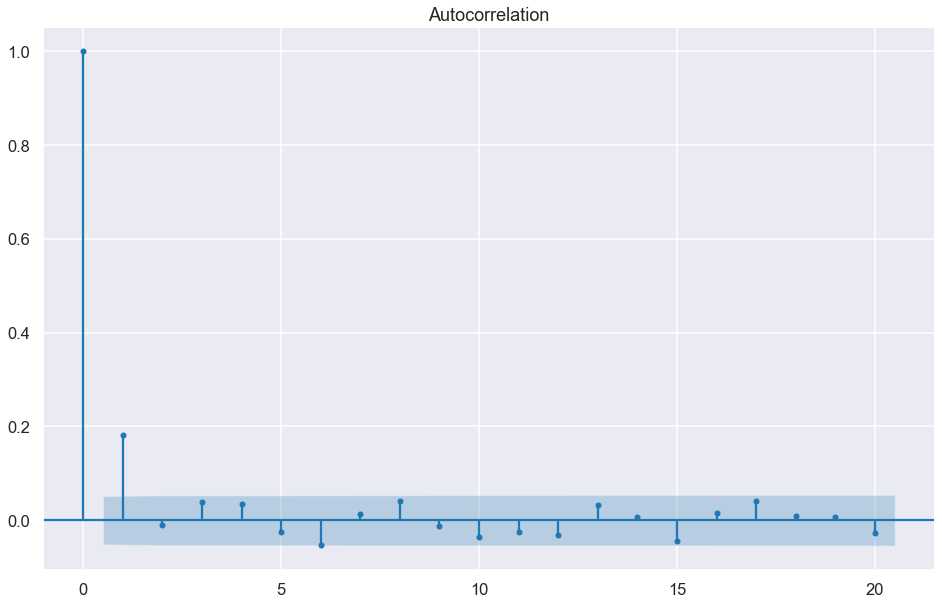

In [96]:
gas_acf = plot_acf(gas_log, lags=20)

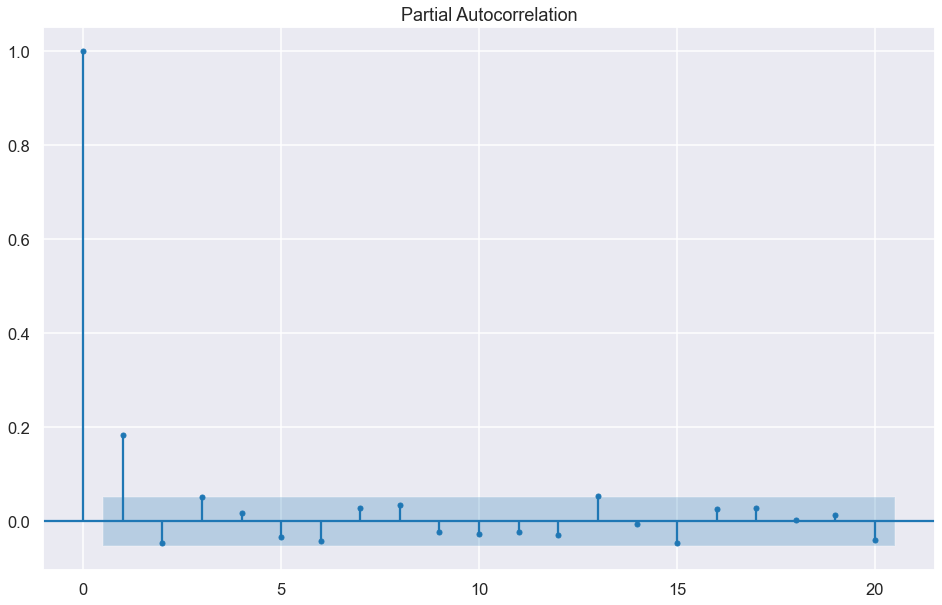

In [97]:
gas_pacf = plot_pacf(gas_log, lags=20)

The plots suggest MA and AR components of 1.

### Naive Model

In [98]:
#Naive model predicting the mean
gas_naive_pred = [gas_train.mean() for n in range(len(gas_test))]
gas_naive_rmse = round(np.sqrt(mean_squared_error(gas_test, gas_naive_pred)),3)
print(f'The naive RMSE is {gas_naive_rmse}.')

The naive RMSE is 0.425.


### Simple ARIMA Model

In [99]:
#Model with AR and MA components of 1 and a 1st difference
gas_ARIMA = SARIMAX(
    gas_train,
    order = (1,1,1)
)
gas_ARIMA_fit = gas_ARIMA.fit()
gas_ARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                 1302
Model:               SARIMAX(1, 1, 1)   Log Likelihood                2108.260
Date:                Fri, 22 Oct 2021   AIC                          -4210.521
Time:                        06:37:08   BIC                          -4195.008
Sample:                    01-23-1994   HQIC                         -4204.701
                         - 12-30-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1204      0.116     -1.042      0.297      -0.347       0.106
ma.L1          0.3184      0.111      2.869      0.004       0.101       0.536
sigma2         0.0023   7.27e-05     31.526      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                72.88
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [100]:
gas_ARIMA_pred, gas_ARIMA_rmse = predict_and_score(gas_ARIMA_fit, gas_test)

The RMSE is 0.312.


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 1152x720 with 0 Axes>

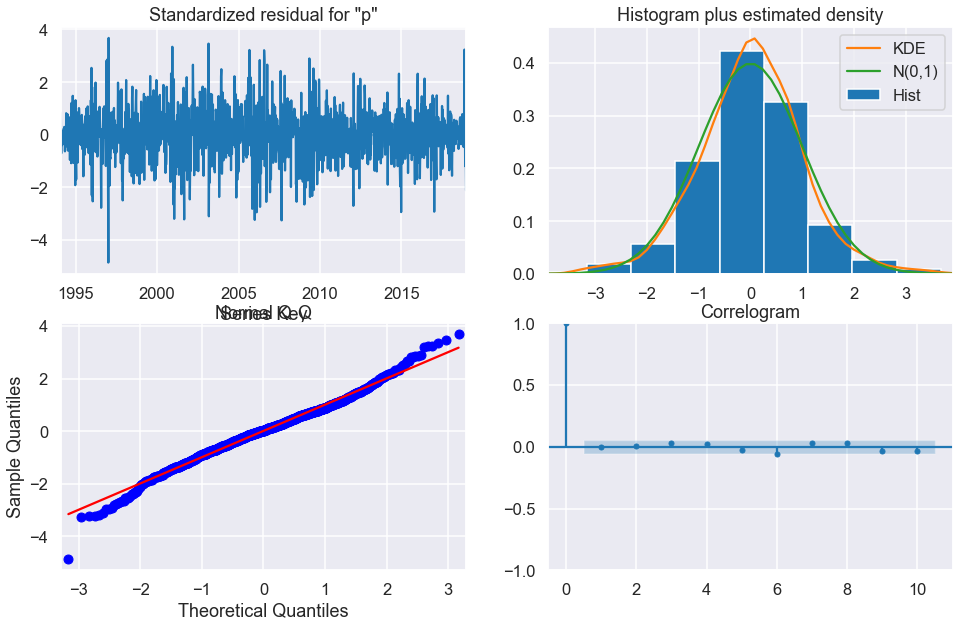

In [101]:
gas_ARIMA_diagnostic = diagnostic_plot(gas_ARIMA_fit)

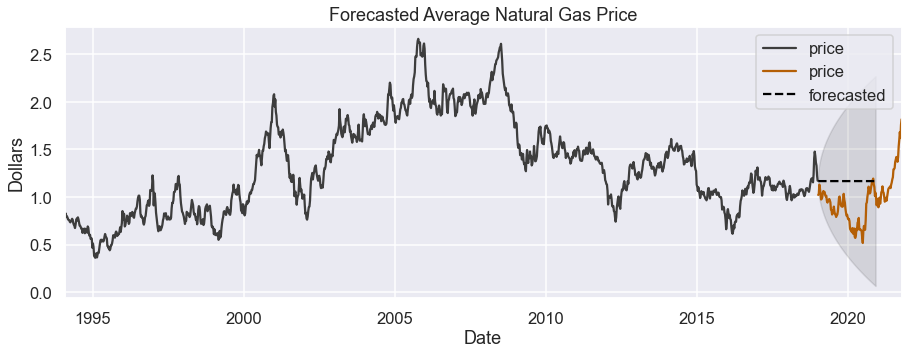

In [102]:
gas_ARIMA_fcast, gas_ARIMA_fcast_plt = plot_forecast(
    gas_train, 
    gas_test, 
    gas_ARIMA_fit, 
    100,
    'Average Natural Gas Price',
    'Dollars')

Although the diagnostics look good, the RMSE is slightly smaller than the naive model. 

### SARIMA Model

In [103]:
#Run grid search to find hyperparameters if file is not in directory
if 'gas_params.joblib' in os.listdir('files'):
    gas_params = joblib.load('files/gas_params.joblib')
else:
    gas_params = grid_search(gas_train, 2, 52)
    joblib.dump(gas_params, 'files/gas_params.joblib')

In [104]:
#Fit the model with the hyperparameters
gas_SARIMA_fit = get_fit(gas_params, gas_train)
gas_SARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:                         price   No. Observations:                 1302
Model:             SARIMAX(2, 2, [1, 2], 52)   Log Likelihood                -436.224
Date:                       Fri, 22 Oct 2021   AIC                            882.448
Time:                               06:40:03   BIC                            907.432
Sample:                           01-23-1994   HQIC                           891.903
                                - 12-30-2018                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L52      -1.1902      0.035    -33.774      0.000      -1.259      -1.121
ar.S.L104     -0.4981      0.025    -19.609      0.000      -0.548      -0.448
ma.S.L52       0.0117      0.047      0.251      0.802      -0.080       0.103
ma.S.L104     -0.7200      0.043    -16.615      0.000      -0.805      -0.635
sigma2         0.1214      0.005     22.907      0.000       0.111       0.132
===================================================================================
Ljung-Box (L1) (Q):                1052.14   Jarque-Bera (JB):                11.86
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [105]:
#Score the model
gas_SARIMA_pred, gas_SARIMA_rmse = predict_and_score(gas_SARIMA_fit, gas_test)

The RMSE is 0.291.


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 1152x720 with 0 Axes>

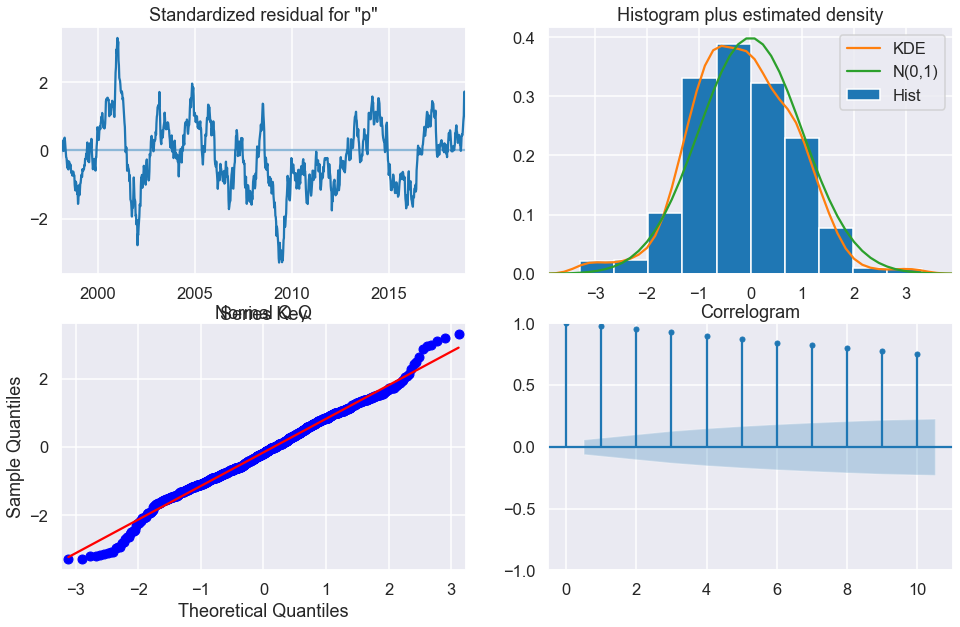

In [106]:
#Plot the diagnostics
gas_SARIMA_diagnostic = diagnostic_plot(gas_SARIMA_fit)

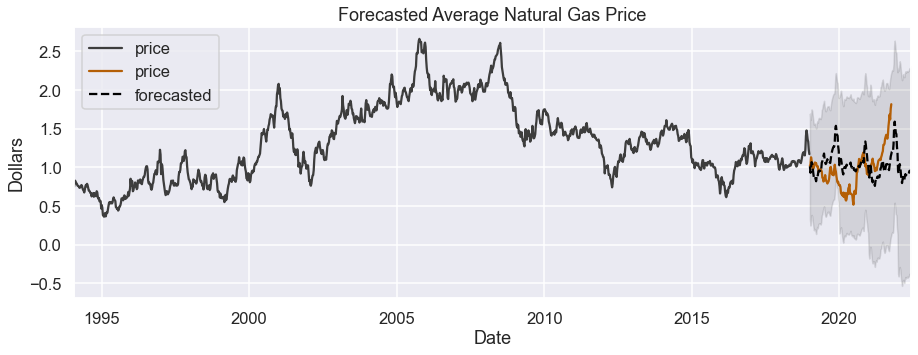

In [107]:
#Plot the forecast
gas_SARIMA_fcast, gas_SARIMA_fcast_plt = plot_forecast(
    gas_train, 
    gas_test, 
    gas_SARIMA_fit, 
    180,
    'Average Natural Gas Price',
    'Dollars')

The diagnostic plots indicate there is information not being captured by the model and the RMSE is still only slightly better than the naive model.

### LSTM 

#### Prepare the data, create helper functions and set global variables

In [108]:
#Scale and reshape the data
scaler = MinMaxScaler()
scaled_gas = pd.DataFrame(scaler.fit_transform(gas_weekly))

gas_data = scaled_gas.values
gas_data = gas_data.reshape((-1,1))

#Split into train and test sets
split_percent_gas = 0.90
split = int(split_percent_gas*len(gas_data))

gas_train_nn = gas_data[:split]
gas_test_nn = gas_data[split:]

date_train = gas_weekly.index[:split]
date_test = gas_weekly.index[split:]

gas_train_nn.shape, gas_test_nn.shape

((1302, 1), (145, 1))

In [109]:
#Prepare the input data for modeling
LOOK_BACK = 52
N_FEATURES = 1
NUM_EPOCHS = 50

train_generator = TimeseriesGenerator(
    gas_train_nn, 
    gas_train_nn, 
    length=LOOK_BACK, 
    batch_size=20
)     
test_generator = TimeseriesGenerator(
    gas_test_nn, 
    gas_test_nn, 
    length=LOOK_BACK, 
    batch_size=1
)

In [110]:
def eval_and_pred(
    train_generator, 
    gas_train_nn, 
    test_generator, 
    gas_test_nn, 
    model):
    """ Takes in the train and test generators, train and test splits and 
    the fitted model and returns the mse and a dataframe with the actual and
    predicted values."""
    
    prediction_test = model.predict(test_generator)
    prediction_train = model.predict(train_generator)
    gas_train_nn = gas_train_nn.reshape((-1))
    gas_test_nn = gas_test_nn.reshape((-1))
    prediction_test = prediction_test.reshape((-1))
    prediction_train = prediction_train.reshape((-1))

    pred_df = pd.DataFrame(index=date_test[LOOK_BACK:])
    pred_df['pred'] = prediction_test
    pred_df['actual'] = gas_test_nn[LOOK_BACK:]
    
    gas_nn_rmse = np.sqrt(mean_squared_error(gas_test_nn[LOOK_BACK:], prediction_test))
    
    return gas_nn_rmse, pred_df


In [111]:
def rolling_predictions(gas_train_nn, gas_test_nn, date_test, model):
    """Takes in the train and test splits, the test dates and the trained
    model and returns a dataframe with the rolling predictions."""
    test_predictions = []

    first_eval_batch = gas_train_nn[-LOOK_BACK:]

    current_batch = first_eval_batch.reshape((1, LOOK_BACK, N_FEATURES))
    for i in range(len(gas_test_nn)):
        pred = model.predict(current_batch)[0]
        test_predictions.append(pred)
        current_batch = np.append(current_batch[:,1:,:],
                              [[pred]],
                              axis=1)

    pred_df = pd.DataFrame(index=date_test)
    pred_df['pred'] = pd.DataFrame(test_predictions).values
    pred_df['actual'] = gas_test_nn
    
    return pred_df


#### Model 1

In [112]:
#Create an LSTM model with a single bidirectional layer and a single dense
#layer
lstm_model_1 = Sequential()

forward_layer = LSTM(
    10, 
    return_sequences=True)

lstm_model_1.add(
    Bidirectional(
        forward_layer,
        input_shape=(LOOK_BACK, N_FEATURES)))

lstm_model_1.add(Flatten())
 
lstm_model_1.add(Dense(1))

lstm_model_1.compile(optimizer='adam', loss='mse')

lstm_model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 52, 20)            960       
_________________________________________________________________
flatten (Flatten)            (None, 1040)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1041      
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________


In [113]:
#Fit the model
lstm_model_1.fit_generator(
    train_generator, 
    epochs=NUM_EPOCHS, 
    verbose=True,
    callbacks=[EarlyStopping(
        monitor='loss',
        patience=5, 
        restore_best_weights=True
    )]
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
63/63 [==============================] - 1s 17ms/step - loss: 0.0166
Epoch 2/50
63/63 [==============================] - 1s 14ms/step - loss: 0.0083
Epoch 3/50
63/63 [==============================] - 1s 14ms/step - loss: 0.0059
Epoch 4/50
63/63 [==============================] - 1s 14ms/step - loss: 0.0049
Epoch 5/50
63/63 [==============================] - 1s 14ms/step - loss: 0.0035
Epoch 6/50
63/63 [==============================] - 1s 15ms/step - loss: 0.0036
Epoch 7/50
63/63 [==============================] - 1s 15ms/step - loss: 0.0027
Epoch 8/50
63/63 [==============================] - 1s 16ms/step - loss: 0.0028
Epoch 9/50
63/63 [==============================] - 1s 15ms/step - loss: 0.0042
Epoch 10/50
63/63 [==============================] - 1s 13ms/step - loss: 0.0026
Epoch 11/50
63/63 [==============================] - 1s 12ms/step - loss: 0.0023
Epoch 12/50
63/63 [=======================

In [114]:
#Get the RMSE and predictions for the model
lstm_model_1_rmse, lstm_model_1_pred = eval_and_pred(
    train_generator, 
    gas_train_nn, 
    test_generator, 
    gas_test_nn, 
    lstm_model_1)
lstm_model_1_rmse

0.027046890332574788

<AxesSubplot:xlabel='Series Key'>

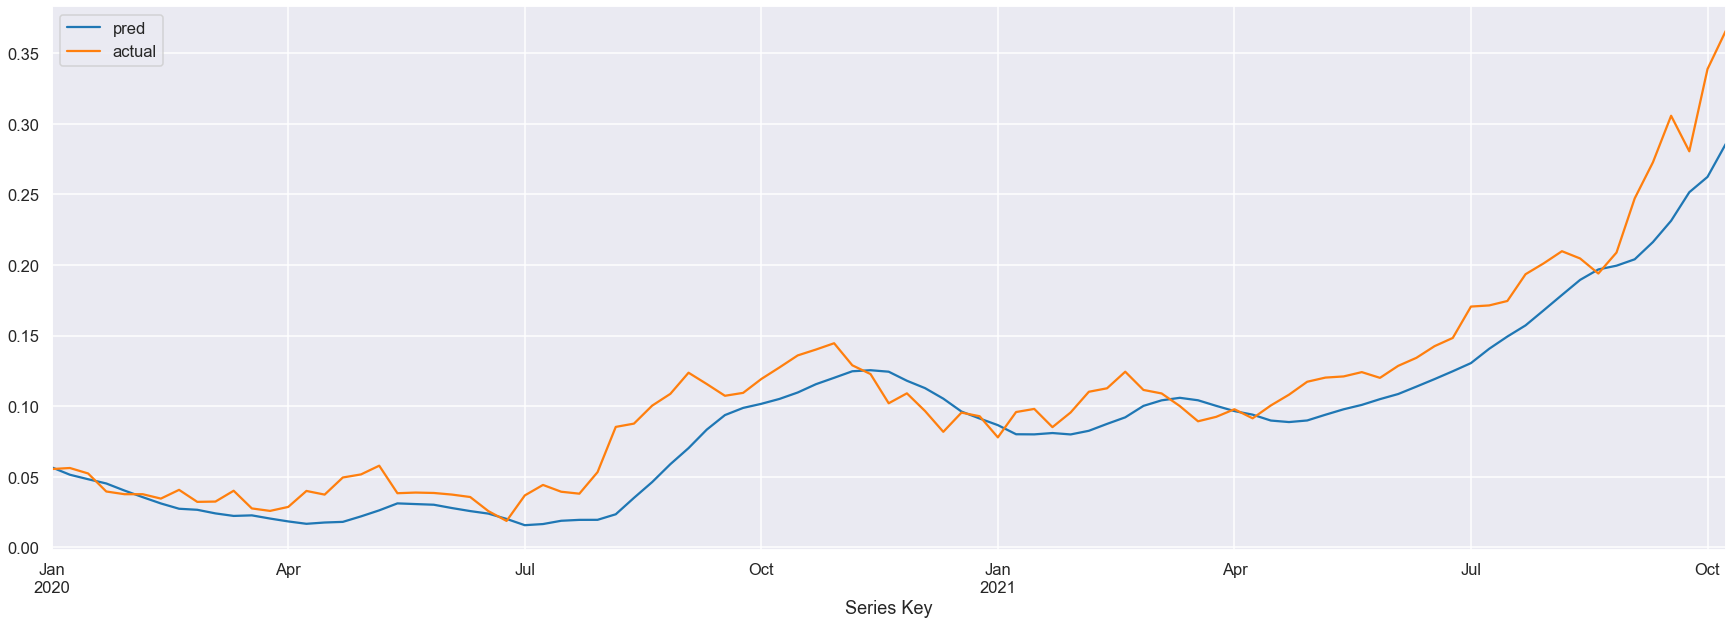

In [115]:
#Plot the predictions
lstm_model_1_pred.plot(figsize=(30,10))

<AxesSubplot:xlabel='Series Key'>

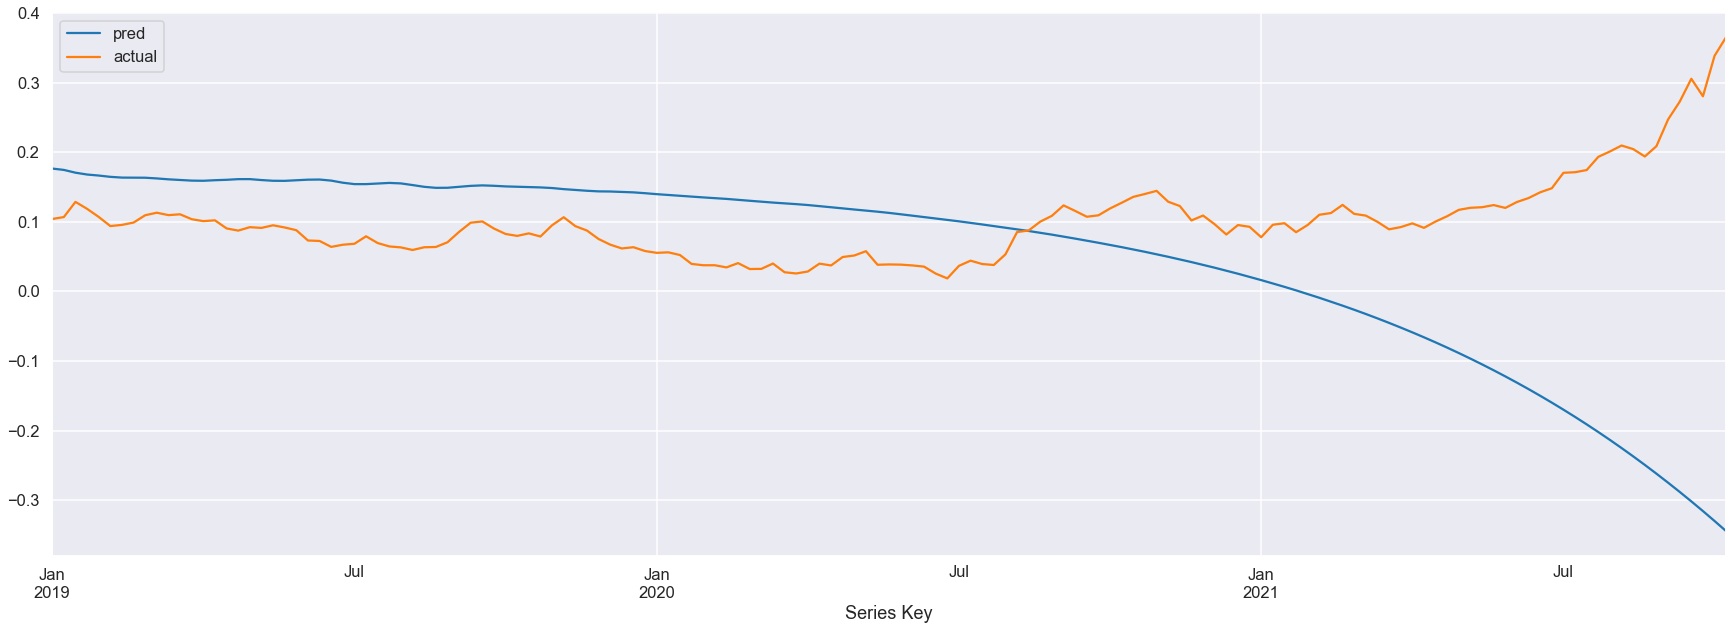

In [116]:
#Plot the rolling predictions.
rolling_lstm_model_1 = rolling_predictions(
    gas_train_nn, 
    gas_test_nn, 
    date_test,
    lstm_model_1)

rolling_lstm_model_1.plot(figsize=(30,10))

#### Model 2

In [117]:
#Create an LSTM model with two bidirectional layers and a single dense layer.
lstm_model_2 = Sequential()

forward_layer = LSTM(
    10, 
    return_sequences=True)

lstm_model_2.add(
    Bidirectional(
        forward_layer,
        input_shape=(LOOK_BACK, N_FEATURES)))

lstm_model_2.add(
    Bidirectional(
        forward_layer,
        input_shape=(LOOK_BACK, N_FEATURES)))

lstm_model_2.add(Flatten())
 
lstm_model_2.add(Dense(1))

lstm_model_2.compile(optimizer='adam', loss='mse')

lstm_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 52, 20)            960       
_________________________________________________________________
bidirectional_2 (Bidirection (None, 52, 20)            2480      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1040)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1041      
Total params: 4,481
Trainable params: 4,481
Non-trainable params: 0
_________________________________________________________________


In [118]:
#Fit the model
lstm_model_2.fit_generator(
    train_generator, 
    epochs=NUM_EPOCHS, 
    verbose=True,
    callbacks=[EarlyStopping(
        monitor='loss',
        patience=5, 
        restore_best_weights=True
    )]
)

Epoch 1/50
63/63 [==============================] - 2s 32ms/step - loss: 0.0201
Epoch 2/50
63/63 [==============================] - 2s 31ms/step - loss: 0.0105
Epoch 3/50
63/63 [==============================] - 2s 30ms/step - loss: 0.0067
Epoch 4/50
63/63 [==============================] - 2s 26ms/step - loss: 0.0070
Epoch 5/50
63/63 [==============================] - 2s 27ms/step - loss: 0.0047
Epoch 6/50
63/63 [==============================] - 2s 26ms/step - loss: 0.0039
Epoch 7/50
63/63 [==============================] - 2s 26ms/step - loss: 0.0032
Epoch 8/50
63/63 [==============================] - 2s 26ms/step - loss: 0.0034
Epoch 9/50
63/63 [==============================] - 2s 26ms/step - loss: 0.0028
Epoch 10/50
63/63 [==============================] - 2s 26ms/step - loss: 0.0033
Epoch 11/50
63/63 [==============================] - 2s 32ms/step - loss: 0.0030
Epoch 12/50
63/63 [==============================] - 2s 34ms/step - loss: 0.0032
Epoch 13/50
63/63 [==================

In [119]:
#Get the RMSE and the predictions
lstm_model_2_rmse, lstm_model_2_pred = eval_and_pred(
    train_generator, 
    gas_train_nn, 
    test_generator, 
    gas_test_nn, 
    lstm_model_2)
lstm_model_2_rmse

0.02103526629600952

<AxesSubplot:xlabel='Series Key'>

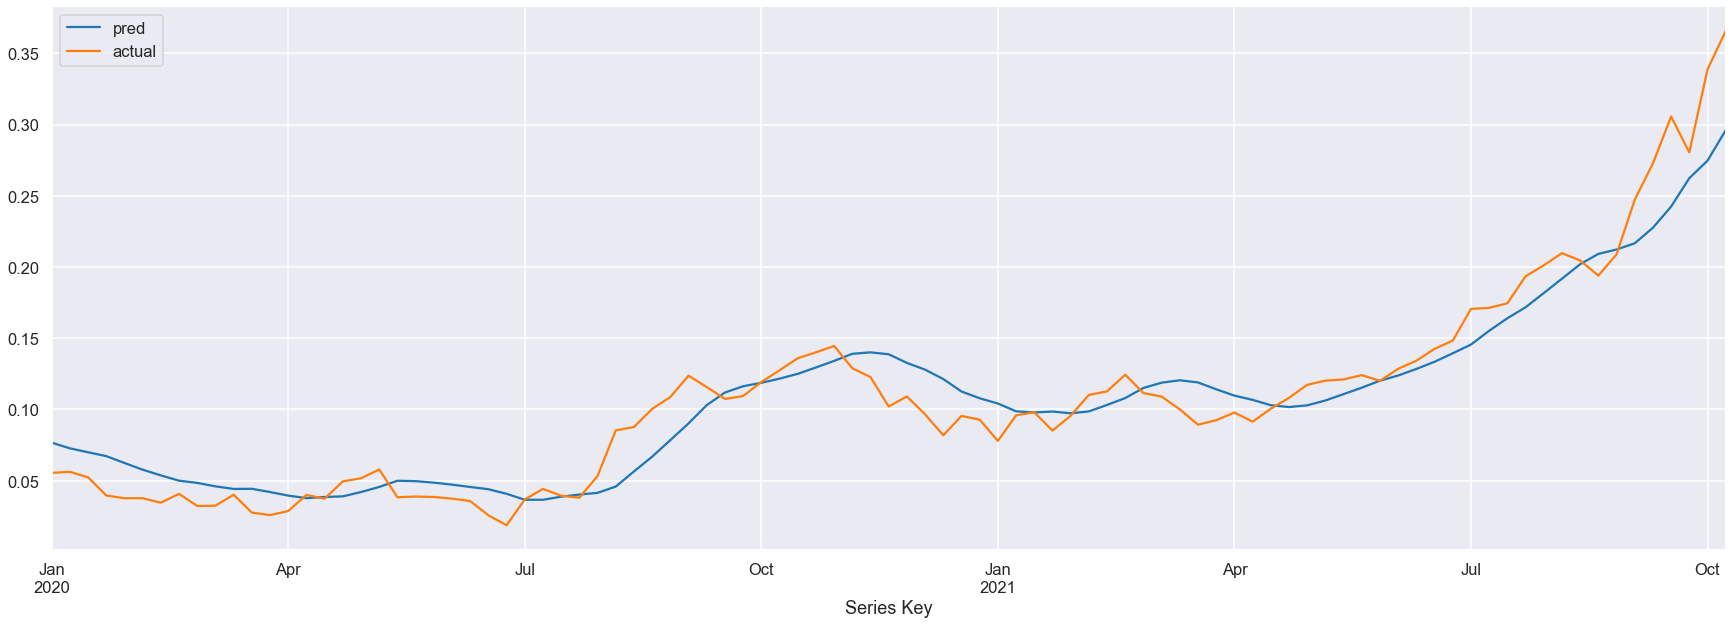

In [120]:
#Plot the predictions
lstm_model_2_pred.plot(figsize=(30,10))

<AxesSubplot:xlabel='Series Key'>

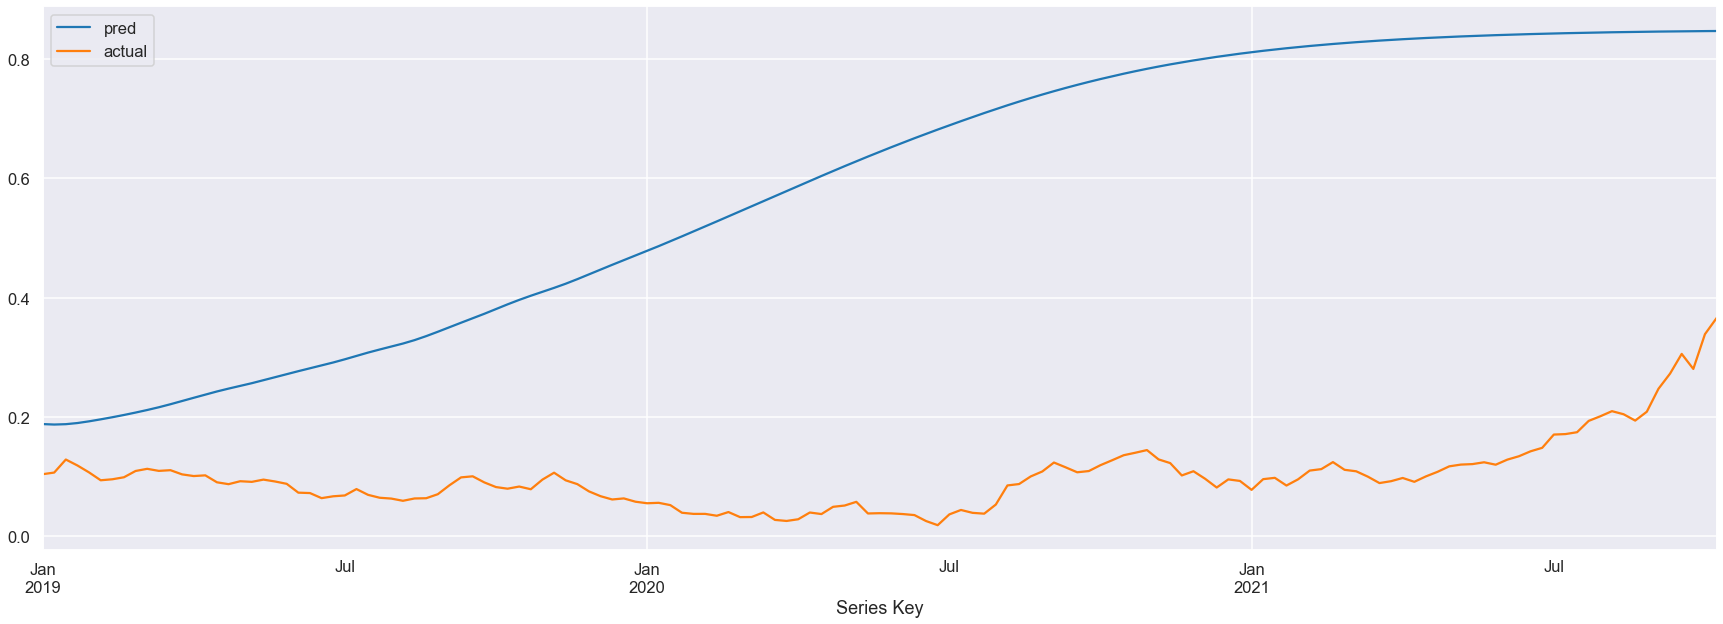

In [121]:
#Plot the rolling predictions
rolling_lstm_model_2 = rolling_predictions(
    gas_train_nn, 
    gas_test_nn, 
    date_test,
    lstm_model_2)

rolling_lstm_model_2.plot(figsize=(30,10))

#### Model 3

In [122]:
#Create an LSTM model with two bidirectional layers, two dense layers and
#regularization.
lstm_model_3 = Sequential()

forward_layer = LSTM(
    10, 
    return_sequences=True)

lstm_model_3.add(
    Bidirectional(
        forward_layer,
        input_shape=(LOOK_BACK, N_FEATURES)))

lstm_model_3.add(
    Bidirectional(
        forward_layer,
        input_shape=(LOOK_BACK, N_FEATURES)))

lstm_model_3.add(Flatten())
 
lstm_model_3.add(Dense(
    32,
    kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-2)))

lstm_model_3.add(Dense(1))

lstm_model_3.compile(optimizer='adam', loss='mse')

lstm_model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 52, 20)            960       
_________________________________________________________________
bidirectional_4 (Bidirection (None, 52, 20)            2480      
_________________________________________________________________
flatten_2 (Flatten)          (None, 1040)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                33312     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 36,785
Trainable params: 36,785
Non-trainable params: 0
_________________________________________________________________


In [123]:
#Fit the model
lstm_model_3.fit_generator(
    train_generator, 
    epochs=NUM_EPOCHS, 
    verbose=True,
    callbacks=[EarlyStopping(
        monitor='loss',
        patience=5, 
        restore_best_weights=True
    )]
)

Epoch 1/50
63/63 [==============================] - 2s 32ms/step - loss: 1.0715
Epoch 2/50
63/63 [==============================] - 2s 28ms/step - loss: 0.2841
Epoch 3/50
63/63 [==============================] - 2s 27ms/step - loss: 0.0950
Epoch 4/50
63/63 [==============================] - 2s 31ms/step - loss: 0.0431
Epoch 5/50
63/63 [==============================] - 2s 33ms/step - loss: 0.0318
Epoch 6/50
63/63 [==============================] - 2s 32ms/step - loss: 0.0223
Epoch 7/50
63/63 [==============================] - 2s 27ms/step - loss: 0.0238
Epoch 8/50
63/63 [==============================] - 2s 27ms/step - loss: 0.0180
Epoch 9/50
63/63 [==============================] - 2s 28ms/step - loss: 0.0165
Epoch 10/50
63/63 [==============================] - 2s 31ms/step - loss: 0.0158
Epoch 11/50
63/63 [==============================] - 2s 31ms/step - loss: 0.0175
Epoch 12/50
63/63 [==============================] - 2s 32ms/step - loss: 0.0145
Epoch 13/50
63/63 [==================

In [124]:
#Get the RMSE and the predictions
lstm_model_3_rmse, lstm_model_3_pred = eval_and_pred(
    train_generator, 
    gas_train_nn, 
    test_generator, 
    gas_test_nn, 
    lstm_model_3)
lstm_model_3_rmse

0.031354369479487776

<AxesSubplot:xlabel='Series Key'>

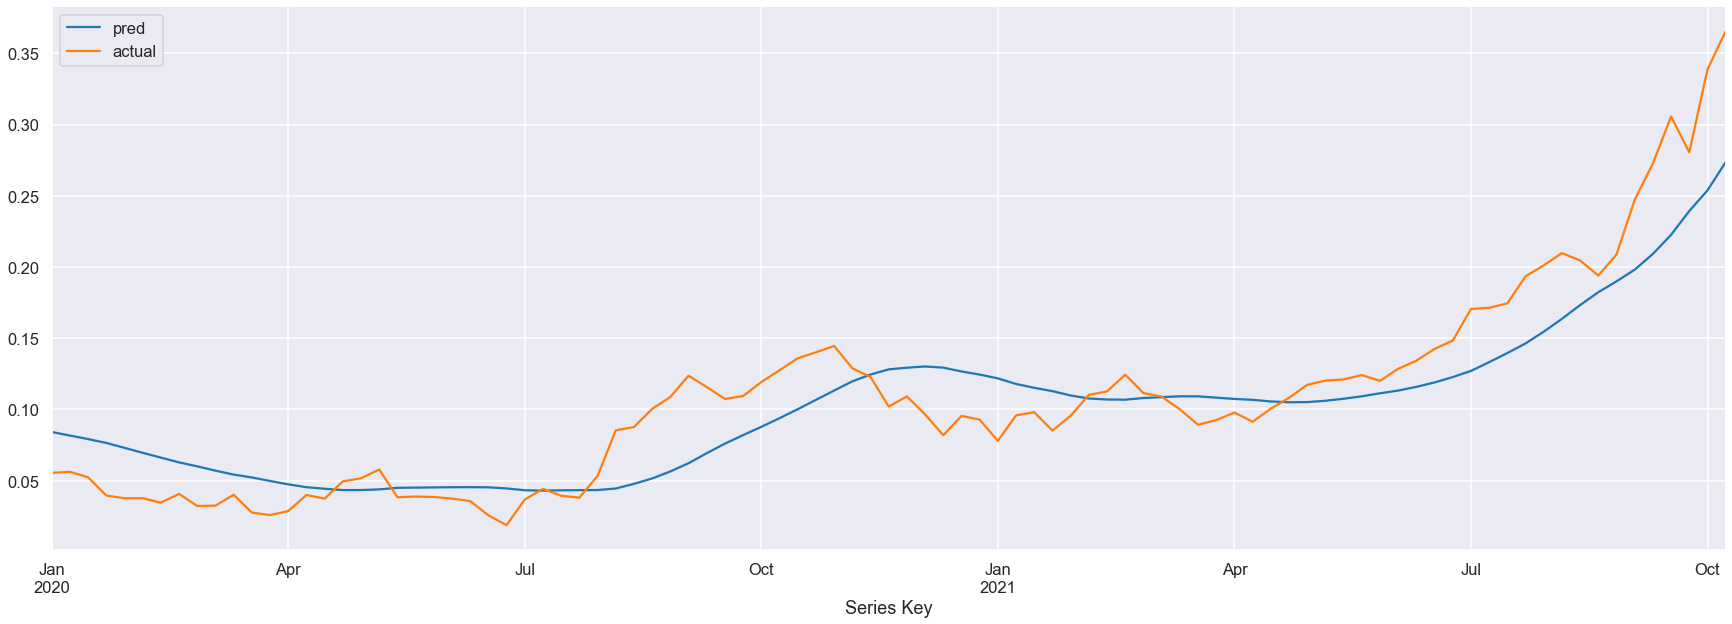

In [125]:
#Plot the predictions
lstm_model_3_pred.plot(figsize=(30,10))

<AxesSubplot:xlabel='Series Key'>

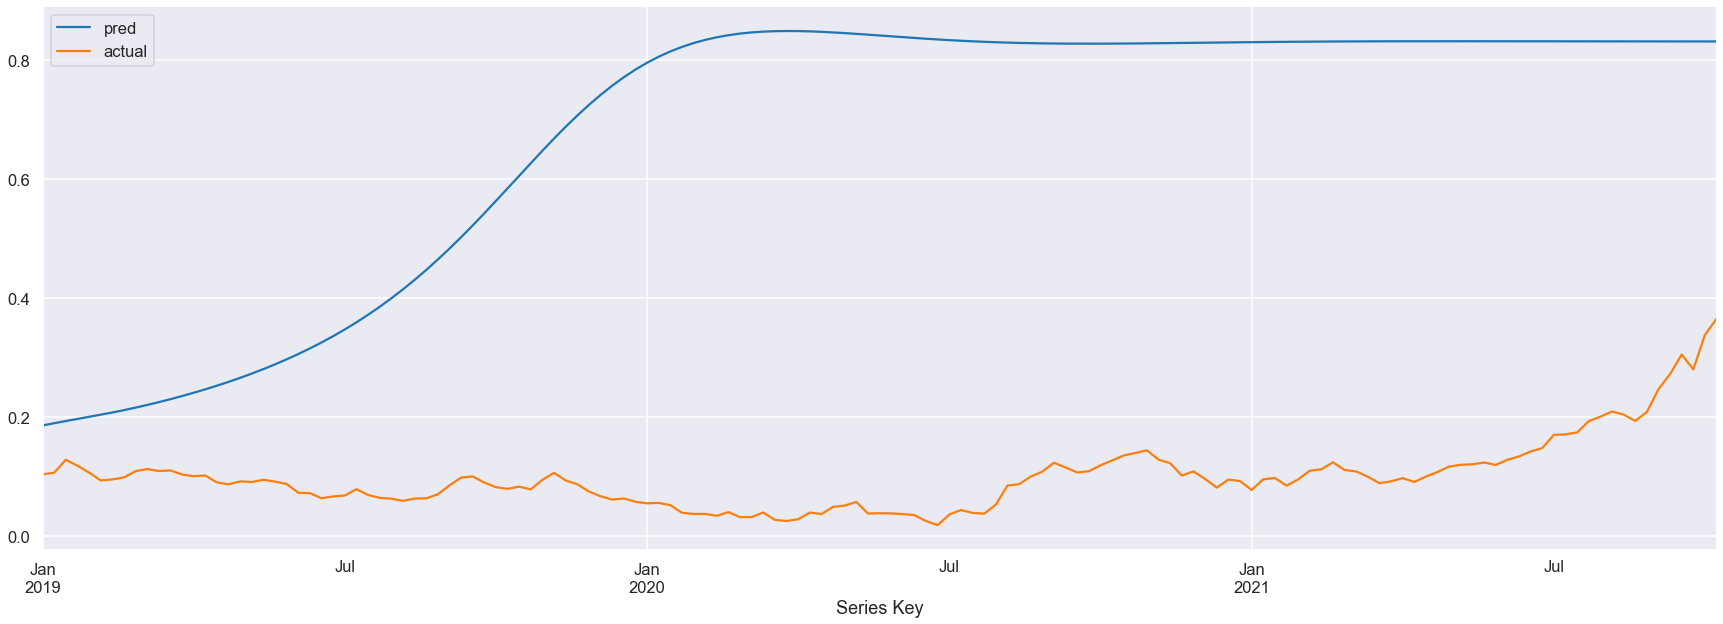

In [126]:
#Plot the rolling predictions
rolling_lstm_model_3 = rolling_predictions(
    gas_train_nn, 
    gas_test_nn, 
    date_test,
    lstm_model_3)

rolling_lstm_model_3.plot(figsize=(30,10))

In [127]:
#RMSE for rolling predictions
np.sqrt(
    mean_squared_error(
        rolling_lstm_model_3['actual'], rolling_lstm_model_3['pred']))

0.6253682852220164

Model 3 has the best RMSE and is generalizing relatively well. 

In [128]:
#Train model 3 on the entire data set
data_generator = TimeseriesGenerator(
    gas_data, 
    gas_data, 
    length=LOOK_BACK, 
    batch_size=20
)     

lstm_model_3.fit_generator(
    data_generator, 
    epochs=NUM_EPOCHS, 
    verbose=True,
    callbacks=[EarlyStopping(
        monitor='loss',
        patience=5, 
        restore_best_weights=True
    )]
)



Epoch 1/50
70/70 [==============================] - 2s 30ms/step - loss: 0.0145
Epoch 2/50
70/70 [==============================] - 2s 27ms/step - loss: 0.0099
Epoch 3/50
70/70 [==============================] - 2s 25ms/step - loss: 0.0115
Epoch 4/50
70/70 [==============================] - 2s 27ms/step - loss: 0.0098
Epoch 5/50
70/70 [==============================] - 2s 26ms/step - loss: 0.0113
Epoch 6/50
70/70 [==============================] - 2s 27ms/step - loss: 0.0108
Epoch 7/50
70/70 [==============================] - 2s 27ms/step - loss: 0.0200
Epoch 8/50
70/70 [==============================] - 2s 28ms/step - loss: 0.0102
Epoch 9/50
70/70 [==============================] - 2s 28ms/step - loss: 0.0158


In [129]:
#Get future predictions
future_dates = pd.date_range(
    start = '2021-10-17', 
    freq='W', periods=12
)
all_dates = pd.date_range(
    start = date_test[-LOOK_BACK], 
    end = future_dates[-1], 
    freq = 'W'
)

test_predictions = []

first_eval_batch = gas_test_nn[-LOOK_BACK:]

current_batch = first_eval_batch.reshape((1, LOOK_BACK, N_FEATURES))
for i in range(len(all_dates)):
    pred = lstm_model_3.predict(current_batch)[0]
    test_predictions.append(pred)
    current_batch = np.append(current_batch[:,1:,:],
                              [[pred]],
                              axis=1)
#Create dataframe with previous 52 weeks of actual and predicted data and 12
#weeks of predicted data
future_df = pd.DataFrame(index=all_dates)
future_df['pred'] = pd.DataFrame(
    scaler.inverse_transform(test_predictions)).values

future_pred = pd.concat([gas_weekly[-LOOK_BACK:], future_df], axis=1)

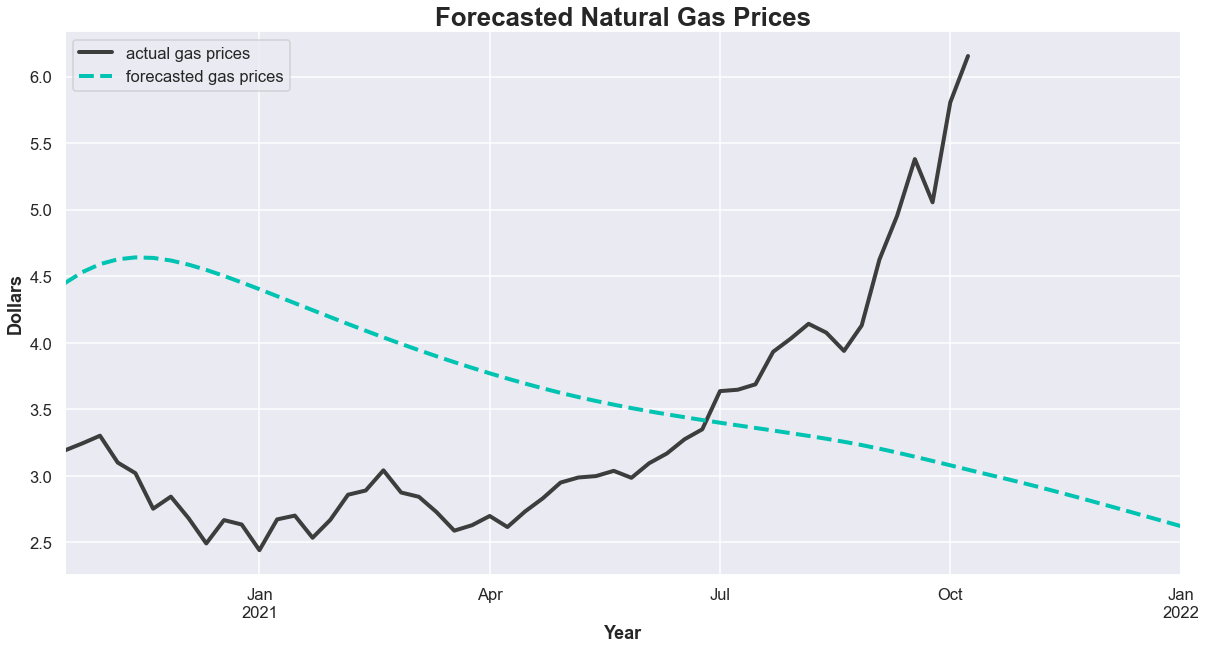

In [130]:
#Plot rolling and future predictions

future_pred.columns = ([ 
    'actual gas prices', 
    'forecasted gas prices'
])

fig,ax = plt.subplots(figsize=(20,10))
future_pred['actual gas prices'].plot(
    color=DARK_NEUTRAL, 
    linewidth=4
)

future_pred['forecasted gas prices'].plot(
    color=HIGHLIGHT, 
    linestyle='--', 
    linewidth=4
)
ax.legend()
plt.xlabel('Year', weight='bold')
plt.ylabel('Dollars', weight='bold')
plt.title('Forecasted Natural Gas Prices', weight='bold', size='x-large');


## Decrease Strain on Power Grid During High Demand Periods

### Helper Functions for Linear Regression Modeling

In [131]:
def get_residuals(y_test, y_pred):
    """Takes in the prediced and actual values and returns the residuals."""
    return [list(y_test)[i] - list(y_pred)[i] for i in range(len(y_test))]

In [132]:
def cross_val_and_eval(model, X_train, y_train):
    """Takes in a model and a train set, runs a 5-fold corss validation and
    returns the r2 and RMSE scores for the train and test sets."""
    results = {}
    scores = cross_validate(
        model, 
        X_train, 
        y_train, 
        cv=5, 
        scoring = (
            'r2',
            'neg_mean_squared_error'
        ), 
        return_train_score=True
    )
    results['train_r2'] = scores['train_r2'].mean()
    results['test_r2'] = scores['test_r2'].mean()
    results['train_rmse'] = np.sqrt(-1*scores['train_neg_mean_squared_error'].mean())
    results['test_rmse'] = np.sqrt(-1*scores['test_neg_mean_squared_error'].mean())
    
    return results

In [133]:
def make_scatter(y_pred_train, y_pred_val, residuals_train, residuals_val):
    """Takes in the predicted y values and lists of the train and test
    residuals. Returns two scatterplots, one of the train residuals and
    one of the test."""
    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,8)) 
    fig.tight_layout()
    ax1.scatter(x=y_pred_train, y=residuals_train, color=NEUTRAL) 
    ax1.axhline(0, color=HIGHLIGHT) 
    ax1.set_title('Training Residuals') 
    ax1.set_xlabel('Predicted') 
    ax1.set_ylabel('Residuals')
    ax2.scatter(x=y_pred_val, y=residuals_val, color=NEUTRAL) 
    ax2.axhline(0, color=HIGHLIGHT)
    ax2.set_title('Validation Residuals') 
    ax2.set_xlabel('Predicted') 
    ax2.set_ylabel('Residuals')
    return fig, (ax1,ax2)

### Create and Validate Model for Above-Average Temperatures

In [134]:
# Naive model with an R2 of 0
dr_above = DummyRegressor()
dummy_model_above = dr_above.fit(X_train_above, y_train_above)
dummy_model_above.score(X_train_above, y_train_above)

0.0

In [135]:
# Create a stasmodels OLS model 
train_above = pd.concat([X_train_above, y_train_above], axis=1)
above_formula = f"{y_train_above.name} ~ {'+'.join(X_train_above.columns)}" 
above_model = ols(formula=above_formula, data=train_above).fit() 
above_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 demand   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     1764.
Date:                Fri, 22 Oct 2021   Prob (F-statistic):          1.67e-196
Time:                        06:43:35   Log-Likelihood:                -7181.2
No. Observations:                 728   AIC:                         1.437e+04
Df Residuals:                     726   BIC:                         1.438e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.801e+04    772.177     36.271      0.000    2.65e+04    2.95e+04
extreme     1112.2479     26.479     42.004      0.000    1060.262    1164.233
==============================================================================
Omnibus:                       16.499   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.990
Skew:                          -0.364   Prob(JB):                     0.000204
Kurtosis:                       3.171   Cond. No.                         131.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The R2 is 70.0, indicating that 70% of the residential electricity demand can be explained by the number of degrees over average of the outside temperature. 

The intercept of 26,540 indicates that on a day with an average temperature of 57.8 degrees, the electricity demand in the Southeast region is 28,110 mwh. The coefficient of 1,157 indicates that for every degree above normal, there is an additional demand on the grid of 1,157 mwh.


The Durbin-Watson score of just under 2 shows no autocorrelation and indicates that the residuals are homoscedastic. There are not enough observations for the JB score to be used. The kurtosis value of just over 3 shows slightly heavier tails than a normal distribution.

In [136]:
# Use cross evaluation to check for overfitting
lr = LinearRegression()
cross_val_and_eval(lr, X_train_above, y_train_above)

{'train_r2': 0.7085749749057373,
 'test_r2': 0.7054997569245671,
 'train_rmse': 4652.25466011203,
 'test_rmse': 4667.112150898926}

The R2 scores and the RMSE scores are very close between the train and test folds, indicating that there is not overfitting.

In [137]:
#Get the predictions for the train and validation sets
model_above = lr.fit(X_train_above,y_train_above)
pred_train_above = model_above.predict(X_train_above)
pred_val_above = model_above.predict(X_val_above)

In [138]:
#Get the residuals for the train and validation sets
residuals_val = get_residuals(y_val_above, pred_val_above) 
residuals_train = get_residuals(y_train_above, pred_train_above)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


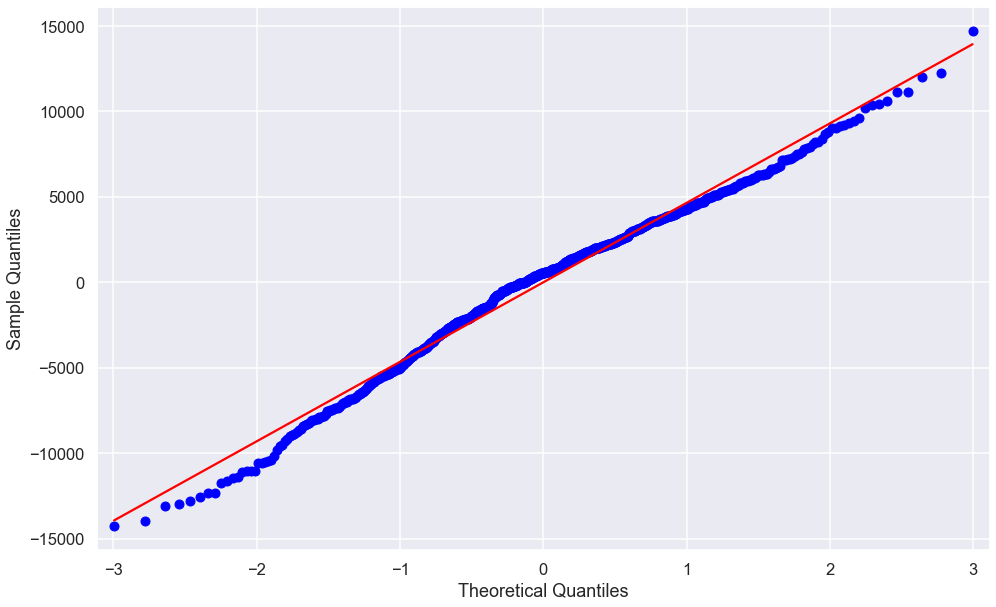

In [139]:
#Create the QQ-plot for the training data
train_qq = sm.graphics.qqplot(pd.Series(residuals_train), line='s')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


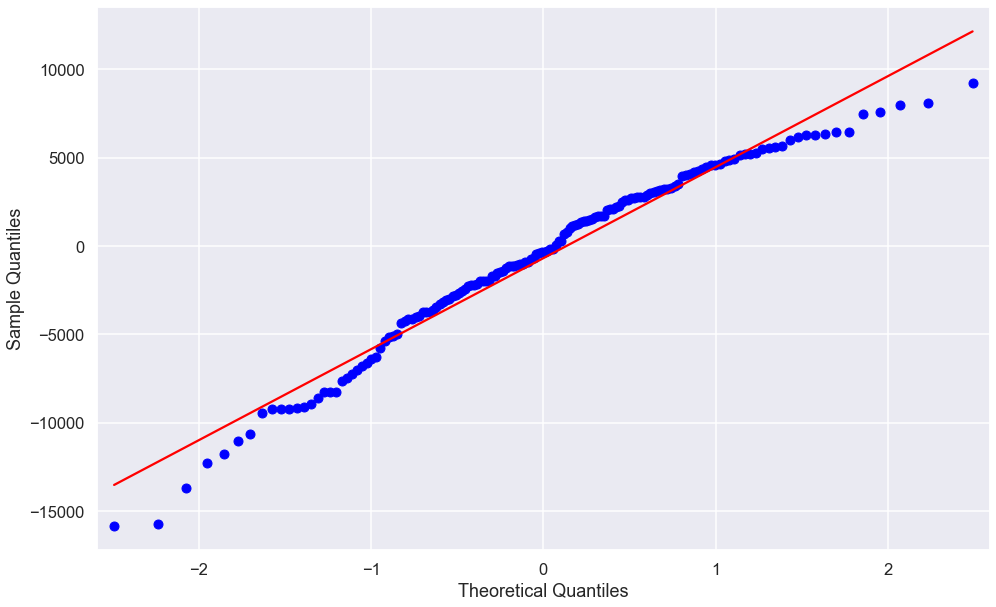

In [140]:
#Create the QQ-plot for the validation data
val_qq = sm.graphics.qqplot(pd.Series(residuals_val), line='s')

<AxesSubplot:ylabel='Count'>

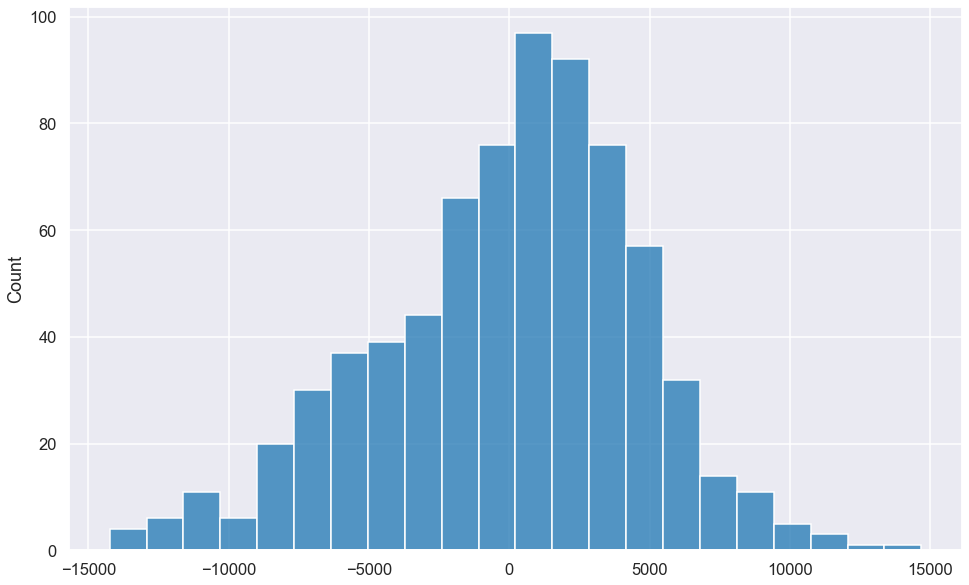

In [141]:
#Plot the histogram for the training data
sns.histplot(residuals_train)

<AxesSubplot:ylabel='Count'>

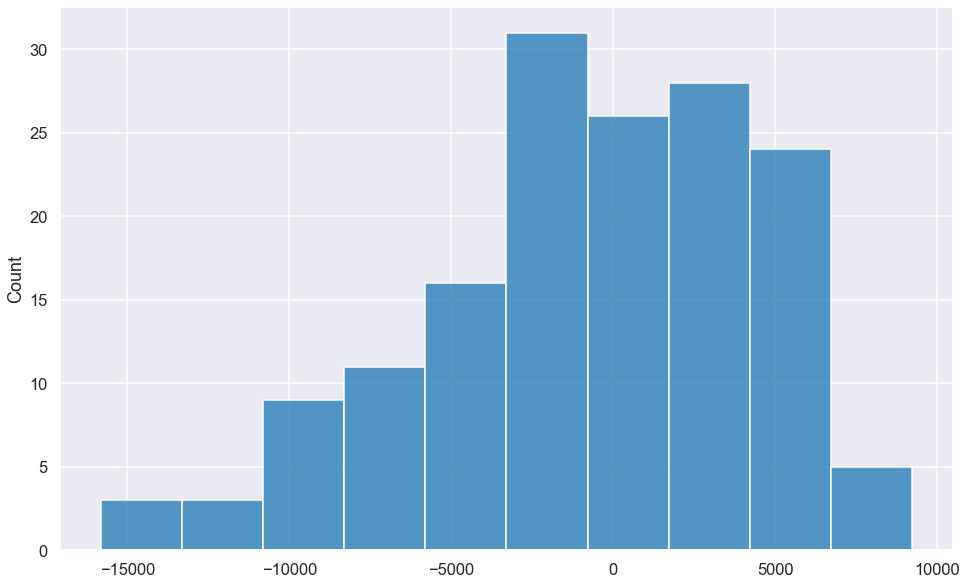

In [142]:
#Plot the histogram for the validation data
sns.histplot(residuals_val)

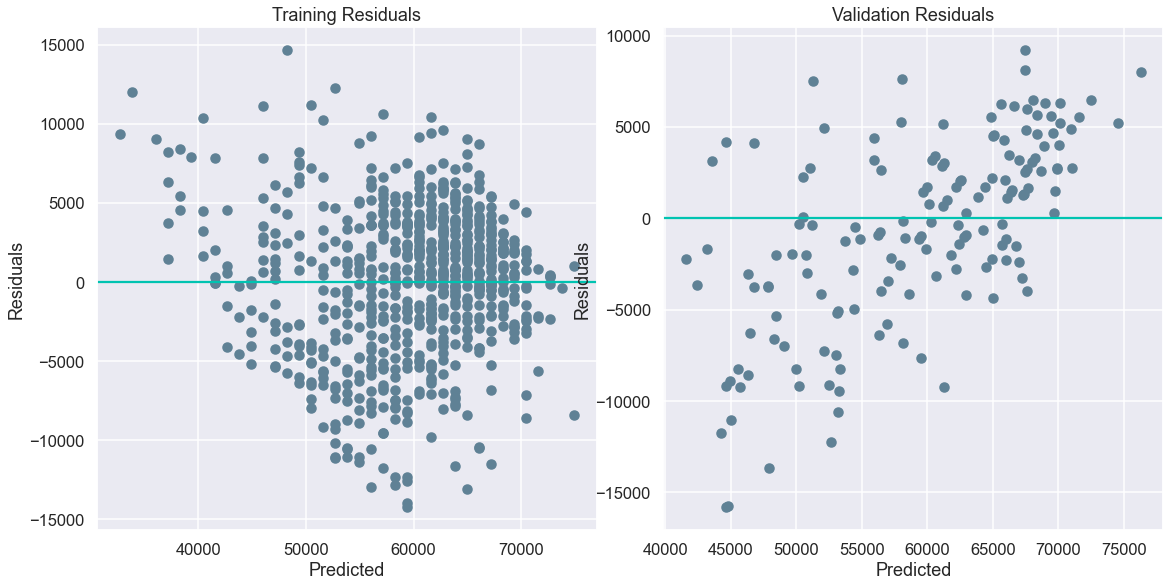

In [143]:
#Plot the scatterplots of the residuals
make_scatter(pred_train_above, y_val_above, residuals_train, residuals_val);

Overall, the data meets the requirements for linear regression - there is a linear relationship, the residuals are relatively normally distributed and homoscedastic.

In [144]:
#Evaluate on the test data
pred_test_above = model_above.predict(X_test_above)
rmse_test_above = np.sqrt(mean_squared_error(y_test_above, pred_test_above))
model_above_score = model_above.score(X_test_above, y_test_above)
print(rmse_test_above, model_above_score)

4882.1615933958765 0.6993447236484898


The results on the test data are consistent with the train and validation data. The RMSE means that on average, the model is off by 4,665 mwh.

### Create and Validate Model for Below-Average Temperatures

In [145]:
dr_below = DummyRegressor()
dummy_model_below = dr_above.fit(X_train_below, y_train_below)
dummy_model_below.score(X_train_below, y_train_below)

0.0

In [146]:
# Create a stasmodels OLS model 
train_below = pd.concat([X_train_below, y_train_below], axis=1)
below_formula = f"{y_train_below.name} ~ {'+'.join(X_train_below.columns)}" 
below_model = ols(formula=below_formula, data=train_below).fit() 
below_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 demand   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     694.5
Date:                Fri, 22 Oct 2021   Prob (F-statistic):          6.74e-107
Time:                        06:43:36   Log-Likelihood:                -6951.2
No. Observations:                 703   AIC:                         1.391e+04
Df Residuals:                     701   BIC:                         1.392e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.974e+04    351.751    112.968      0.000     3.9e+04    4.04e+04
extreme     -541.8001     20.559    -26.353      0.000    -582.165    -501.435
==============================================================================
Omnibus:                       72.159   Durbin-Watson:                   2.102
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              198.479
Skew:                           0.518   Prob(JB):                     7.96e-44
Kurtosis:                       5.388   Cond. No.                         33.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The R2 value of 0.51 indicates that there is not as strong of a relationship between below-average temperatures and electricity demand as there is between above-average temperatures and electricity demand. This makes sense, as around half of the heating of homes in the area comes from natural gas and not electricity (from EIA.gov). Because above-average temperatures are more likely to correlate with high demand and this also corresponds to the peak season for solar power generation, I will focus only on that data. 

## Stay Competitive With U.S. Market

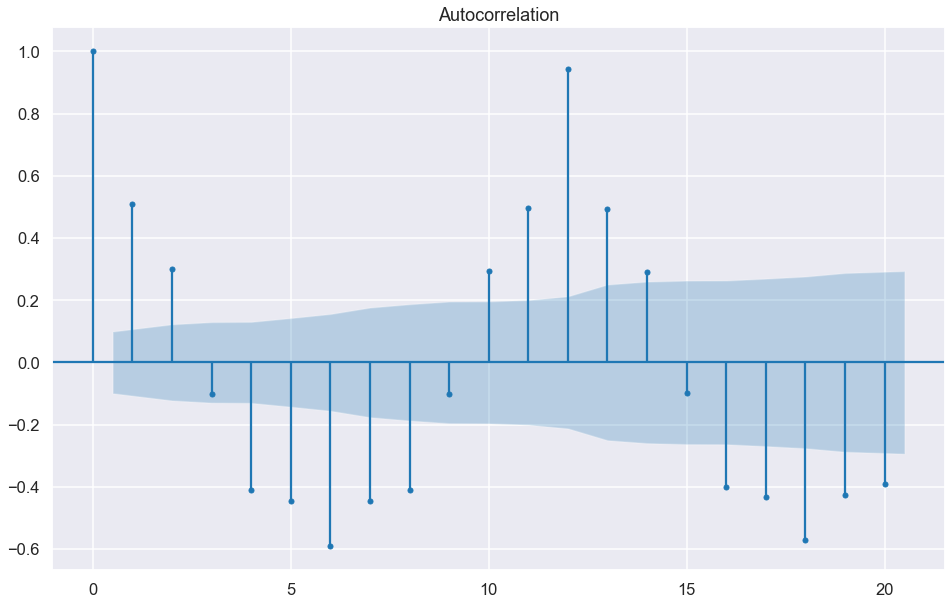

In [147]:
#Plot the acf
solar_acf = plot_acf(log_solar.diff().dropna(), lags=20)

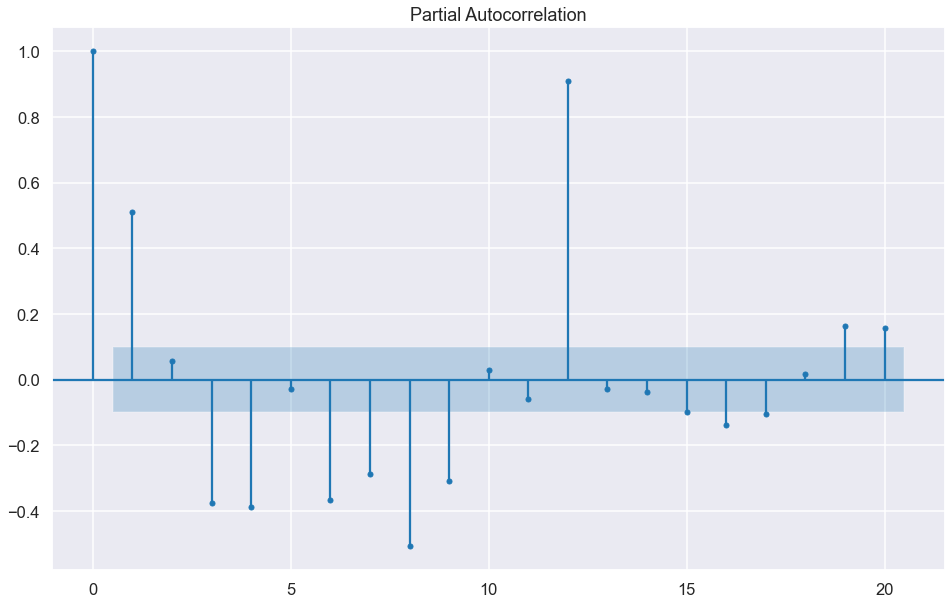

In [148]:
#Plot the pacf
solar_pacf = plot_pacf(log_solar.diff().dropna(), lags=20)

The plots suggest an AR of lag 1 and and MA component of lag 2. 

### Naive Model

In [149]:
#Create a naive model that predicts the mean
solar_naive_pred = [solar_train.mean() for n in range(len(solar_test))]
solar_naive_rmse = round(np.sqrt(mean_squared_error(solar_test, solar_naive_pred)),3)
print(f'The naive RMSE is {solar_naive_rmse}.')

The naive RMSE is 4.833.


### Simple ARIMA Model

In [150]:
#Create an ARIMA model with an AR of 1, an MA of 2 and a first difference.
solar_ARIMA = SARIMAX(
    solar_train,
    order = (1,1,2)
)
solar_ARIMA_fit = solar_ARIMA.fit()
solar_ARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 actual   No. Observations:                  372
Model:               SARIMAX(1, 1, 2)   Log Likelihood                 303.627
Date:                Fri, 22 Oct 2021   AIC                           -599.254
Time:                        06:43:37   BIC                           -583.590
Sample:                    01-01-1989   HQIC                          -593.033
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2575      0.169      1.523      0.128      -0.074       0.589
ma.L1          0.2108      0.145      1.450      0.147      -0.074       0.496
ma.L2          0.5067      0.094      5.387      0.000       0.322       0.691
sigma2         0.0114      0.001     15.701      0.000       0.010       0.013
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               114.85
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             1.22
Prob(H) (two-sided):                  0.92   Kurtosis:                         4.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [151]:
#Score the model and get the predictions
solar_ARIMA_pred, solar_ARIMA_rmse = predict_and_score(solar_ARIMA_fit, solar_test)

The RMSE is 0.738.


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 1152x720 with 0 Axes>

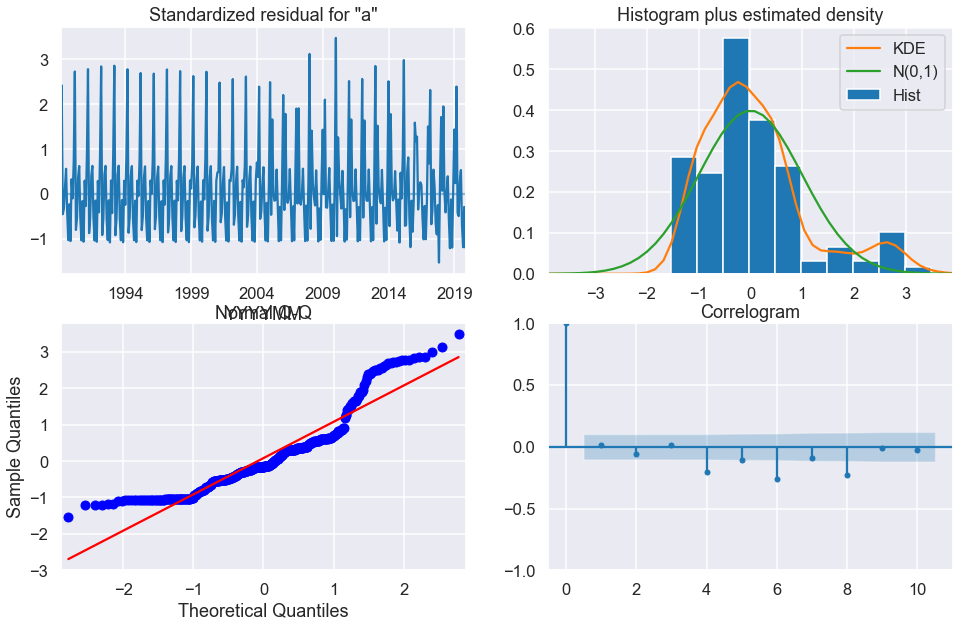

In [152]:
#Get the diagnostics
solar_ARIMA_diagnostic = diagnostic_plot(solar_ARIMA_fit)

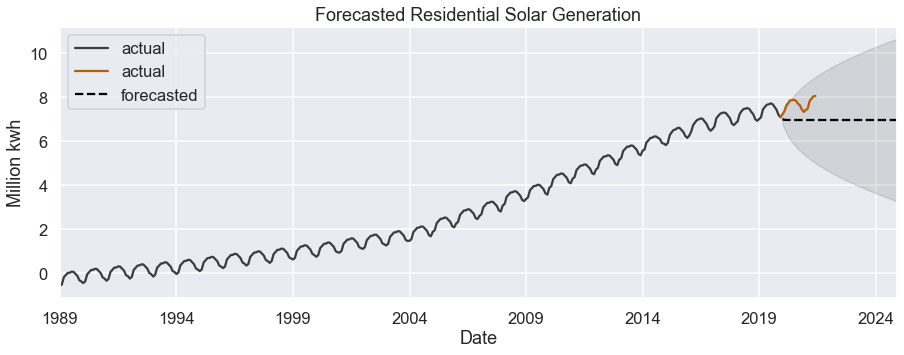

In [153]:
#Plot the predictions
solar_ARIMA_fcast, solar_ARIMA_fcast_plt = plot_forecast(
    solar_train, 
    solar_test, 
    solar_ARIMA_fit, 
    60,
    'Residential Solar Generation',
    'Million kwh')

Although the RMSE has improved over the naive model, the residuals are far from normal and the model does not capture the data well.

### SARIMA Model

In [154]:
#Run a grid search for hyperparameters if the file is not already in the 
#directory
if 'solar_params.joblib' in os.listdir('files'):
    solar_params = joblib.load('files/solar_params.joblib')
else:
    solar_params = grid_search(solar_train, 2, 12)
    joblib.dump(solar_params, 'files/solar_params.joblib')

In [155]:
#Fit the model with the hyperparameters
solar_SARIMA_fit = get_fit(solar_params, solar_train)
solar_SARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:                        actual   No. Observations:                  372
Model:             SARIMAX(2, 2, [1, 2], 12)   Log Likelihood                 374.032
Date:                       Fri, 22 Oct 2021   AIC                           -738.064
Time:                               06:43:41   BIC                           -719.176
Sample:                           01-01-1989   HQIC                          -730.524
                                - 12-01-2019                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.9447      0.139     -6.786      0.000      -1.218      -0.672
ar.S.L24      -0.7022      0.106     -6.640      0.000      -0.909      -0.495
ma.S.L12       0.4982      0.150      3.311      0.001       0.203       0.793
ma.S.L24       0.5941      0.093      6.385      0.000       0.412       0.776
sigma2         0.0056      0.000     16.391      0.000       0.005       0.006
===================================================================================
Ljung-Box (L1) (Q):                 235.72   Jarque-Bera (JB):                63.94
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               7.47   Skew:                             0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [156]:
#Score the model and get the predictions
solar_SARIMA_pred, solar_SARIMA_rmse = predict_and_score(solar_SARIMA_fit, solar_test)

The RMSE is 0.123.


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 1152x720 with 0 Axes>

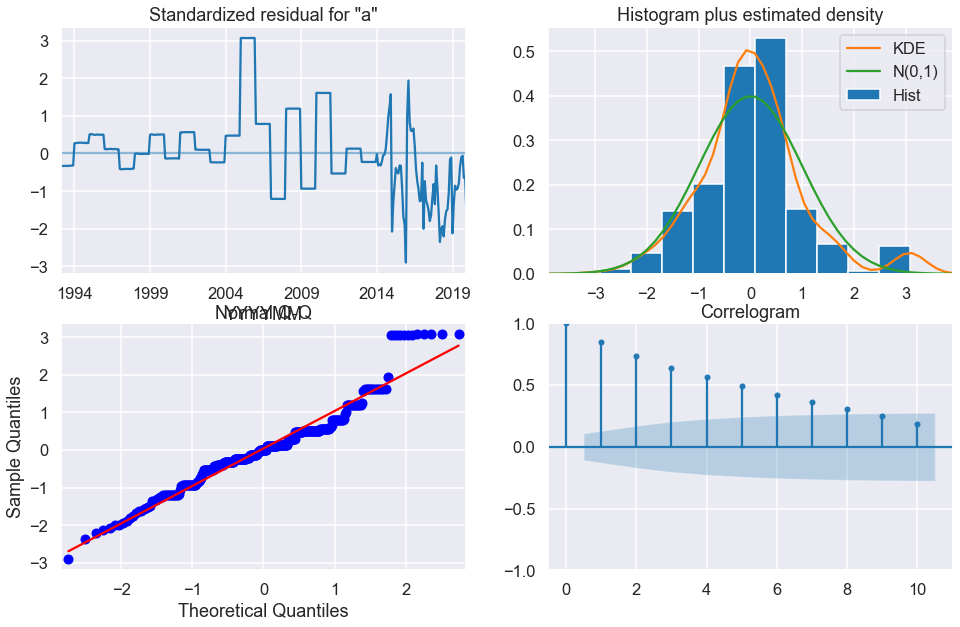

In [157]:
#Plot the diagnostics
solar_SARIMA_diagnostic = diagnostic_plot(solar_SARIMA_fit)

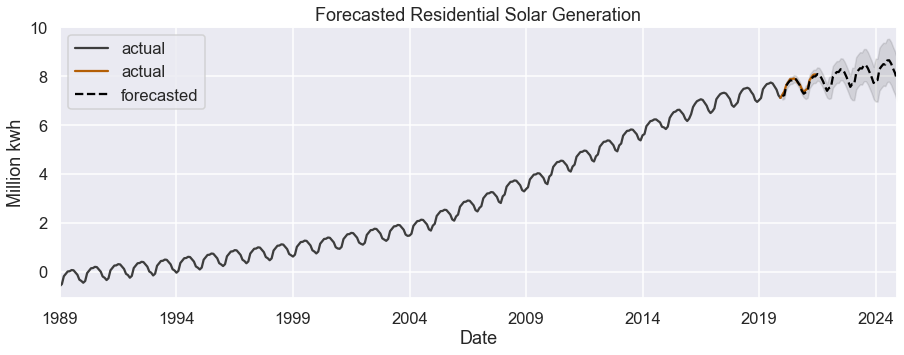

In [158]:
#Plot the forecast
solar_SARIMA_fcast, solar_SARIMA_fcast_plt = plot_forecast(
    solar_train, 
    solar_test, 
    solar_SARIMA_fit, 
    60,
    'Residential Solar Generation',
    'Million kwh')

Although the diagnostics indicate that there are some outliers and that there is information not captured by the model, the RMSE has decreased further and the prediction plot shows that the model is doing an excellent job at predicting the pattern.

The seasonal AR and MA components show that the information from 1 and 2 years ago is predictive of the current value. 

# Data Visualizations

## Reduce Dependence on Imported Electricity

In [159]:
pct_change = energy_demand.pct_change(periods=12)

In [160]:
#Tranform all data into btus
BTU = 34121
demand_train_btu = np.e**(demand_train)/BTU
demand_test_btu = np.e**(demand_test)/BTU
demand_fcast =np.e**( ARt_fit.get_forecast(
        steps=48, 
        dynamic=True).summary_frame())/BTU
by_import = by_source['imported'][:'2008'].sort_index()


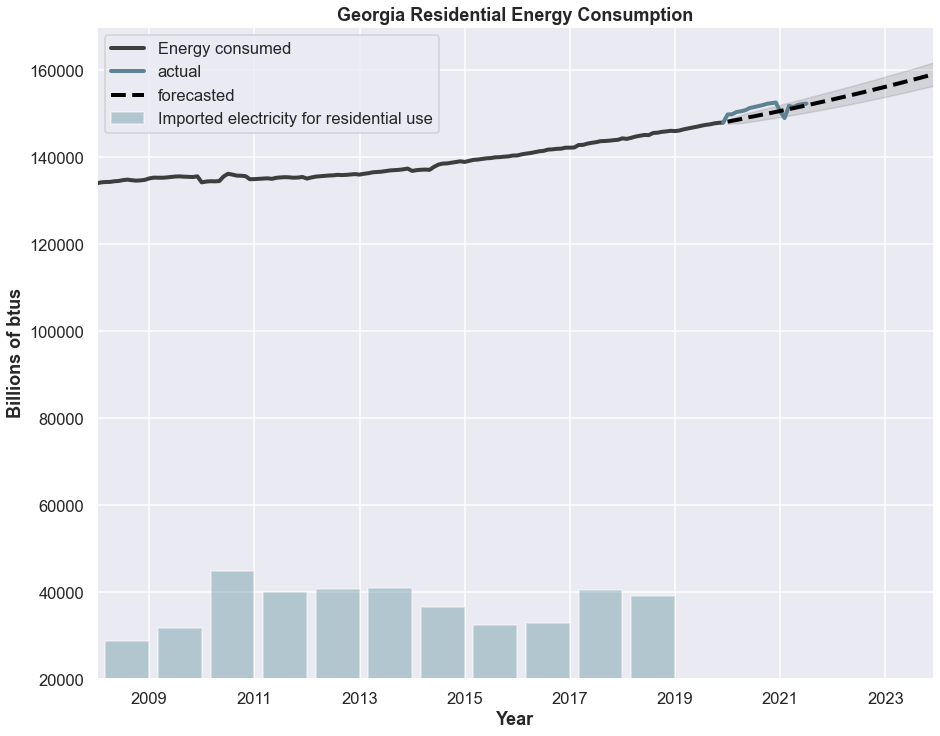

In [161]:
#Plot the data
fig, ax = plt.subplots(figsize=(15, 12))

demand_train_btu.plot(
    ax=ax, 
    color=DARK_NEUTRAL,
    linewidth=4,
    label='Energy consumed'
    )
demand_test_btu.plot(
    ax=ax, 
    color=NEUTRAL,
    linewidth=4,
    label='actual'
    )
demand_fcast['mean'].plot(
    ax=ax, 
    style='k--',
    linewidth=4,
    label='forecasted')
ax.fill_between(
    demand_fcast.index, 
    demand_fcast['mean_ci_lower'], 
    demand_fcast['mean_ci_upper'], 
    color='k', 
    alpha=0.1)
plt.bar(
    x=by_import.index, 
    height=by_import*.17, 
    width=-10, 
    align='edge',
    color=MEDIUM, 
    alpha=.5,
    label = 'Imported electricity for residential use')
plt.xlabel(
    'Year', 
    weight='bold'
)
plt.ylabel(
    'Billions of btus', 
    weight='bold'
)
plt.title(f'Georgia Residential Energy Consumption', weight='bold')
ax.legend(loc=2)
plt.ylim(20_000, 170_000);

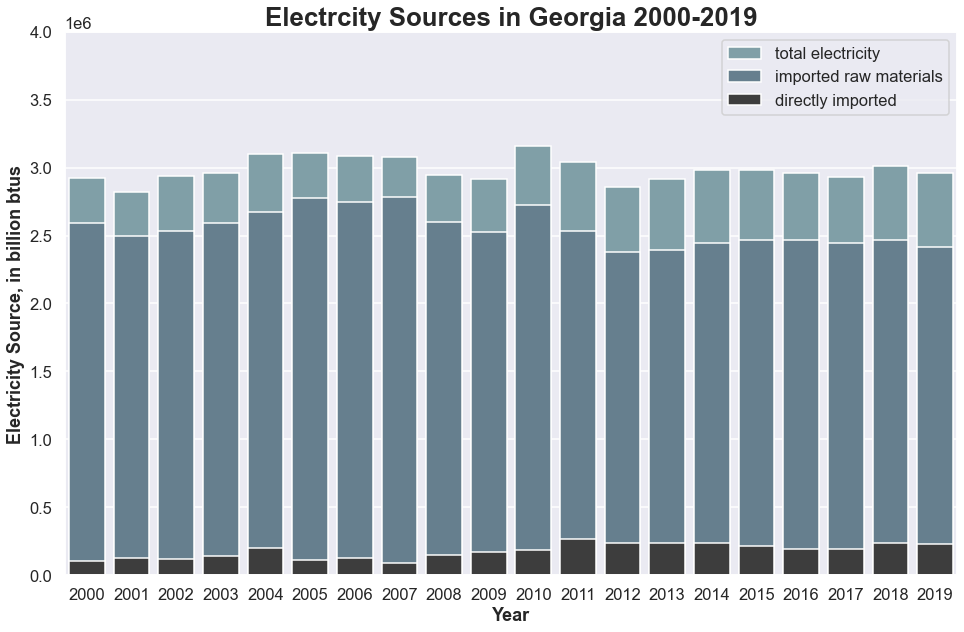

In [162]:
#Plot the source of electricity by year
by_source['imported_materials'] = (
    by_source['total'] - 
    by_source['renewable'] - 
    by_source['imported'])

fig,ax = plt.subplots(figsize=(16,10))
sns.barplot(
    data=by_source[:'2000'], 
    x=by_source[:'2000'].index.year, 
    y='total', 
    color=MEDIUM, 
    label='total electricity'
)
sns.barplot(
    data=by_source[:'2000'], 
    x=by_source[:'2000'].index.year, 
    y='imported_materials', 
    color=NEUTRAL, 
    label='imported raw materials'
)
sns.barplot(
    data=by_source[:'2000'], 
    x=by_source[:'2000'].index.year, 
    y='imported', 
    color=DARK_NEUTRAL, 
    label='directly imported'
)
plt.ylim(0, 4_000_000)
plt.legend()
plt.xlabel(
    'Year', 
    weight='bold'
)
plt.ylabel(
    'Electricity Source, in billion btus', 
    weight='bold'
)
plt.title(
    'Electrcity Sources in Georgia 2000-2019', 
    weight='bold',
    size='x-large'
);

## Mitigate Impact of Rising Natural Gas Prices

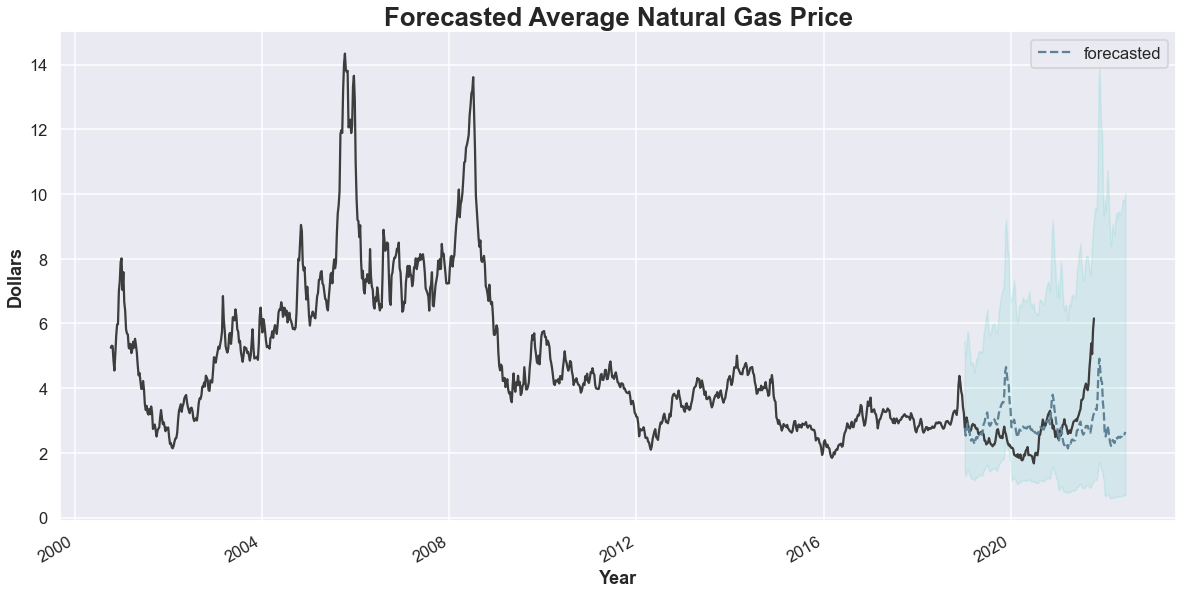

In [163]:
#Un-log the forecast and plot
fig, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(
    data=gas_weekly[350:], 
    x=gas_weekly[350:].index, 
    y='price', 
    color=DARK_NEUTRAL
)

fcast = np.e**(gas_SARIMA_fit.get_forecast(
    steps=180, 
    dynamic=True).summary_frame())

fcast['mean'].plot(
    ax=ax, 
    style='--',
    color=NEUTRAL,
    label='forecasted'
)
plt.legend()
ax.fill_between(
    fcast.index, 
    fcast['mean_ci_lower'], 
    fcast['mean_ci_upper'], 
    color=HIGHLIGHT, 
    alpha=0.1);
plt.xlabel(
    'Year', 
    weight='bold'
)
plt.ylabel(
    'Dollars', 
    weight='bold'
)
plt.title(
    'Forecasted Average Natural Gas Price', 
    weight='bold', 
    size='x-large'
);


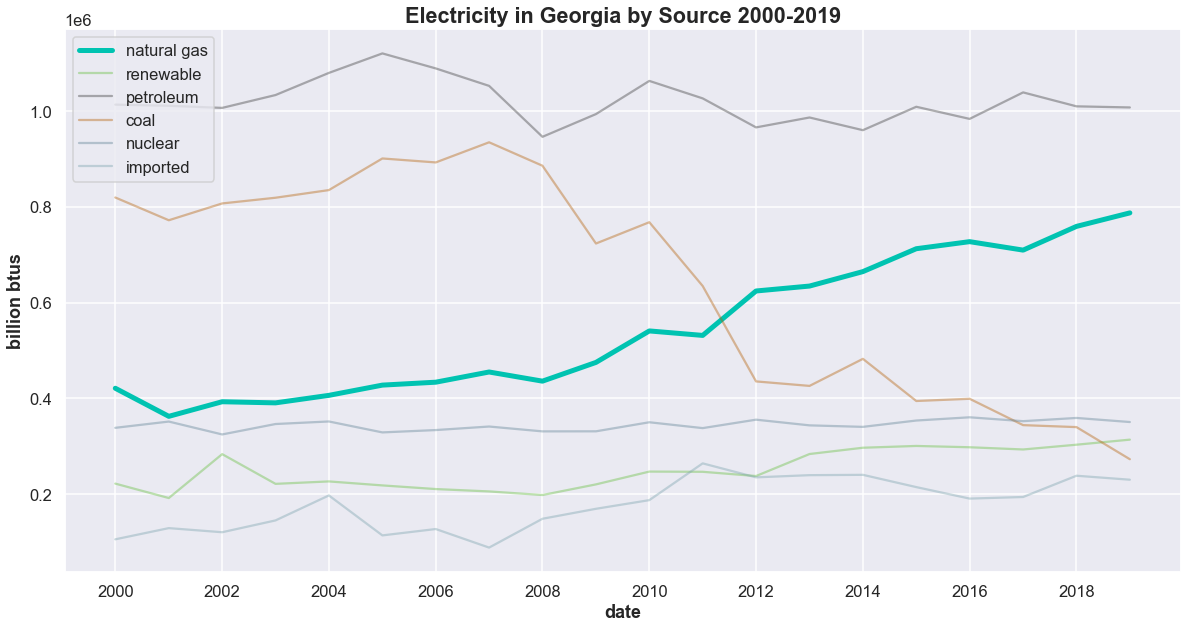

In [164]:
#Plot use of natural gas to generate electricity over time
DATA = by_source[:'2000']
IDX = by_source[:'2000'].index
ALPHA = 0.4

fig,ax=plt.subplots(figsize=(20,10)) 

sns.lineplot(
    data=DATA, 
    x=IDX, 
    y='natural_gas',
    color=HIGHLIGHT,
    linewidth=5,
    label='natural gas'
)
sns.lineplot(
    data=DATA, 
    x=IDX, 
    y='renewable',
    color=GREEN,
    alpha=ALPHA,
    label='renewable'
)
sns.lineplot(
    data=DATA, 
    x=IDX, 
    y='petroleum',
    color=DARK_NEUTRAL,
    alpha=ALPHA,
    label='petroleum'
)
sns.lineplot(
    data=DATA, 
    x=IDX, 
    y='coal',
    color=BRICK,
    alpha=ALPHA,
    label='coal'
)
sns.lineplot(
    data=DATA, 
    x=IDX, 
    y='nuclear',
    color=NEUTRAL,
    alpha=ALPHA,
    label='nuclear'
)
sns.lineplot(
    data=DATA, 
    x=IDX, 
    y='imported',
    color=MEDIUM,
    alpha=ALPHA,
    label='imported'
)
ax.set_ylabel(
    'billion btus', 
    weight='bold'
) 
plt.xlabel(
    'date', 
    weight='bold'
)
plt.title(
    'Electricity in Georgia by Source 2000-2019', 
    weight='bold', 
    size='large'
)
ax.legend(loc=2);

## Decrease Strain on Power Grid During High Demand Periods

In [165]:
overall_mean

57.805474095796676

Overall electricity generation capacity in Georgia is 14,413 mwh (according to GA Power). The Southeast region covers 5 states. 

In [166]:
#Find the cutoffs for high-demand and hot days
demand_above_df = demand_above_df.copy()
demand_above_df['hot'] = demand_above_df['extreme'] >= 32.2
demand_above_df['high_demand'] = (
    demand_above_df['demand'] >= 
    demand_above_df['demand'].quantile(.9)
)

high_demand_avg_temp = round(
    demand_above_df
    [demand_above_df['high_demand']==True]
    ['extreme'].mean() + overall_mean,1
)
lower_demand_avg_temp = round(
    demand_above_df
    [demand_above_df['high_demand']!=True]
    ['extreme'].mean() + overall_mean,1
)

percent_hot = round(demand_above_df['hot'].sum()/climate.shape[0]*100,1)
high_demand_avg_temp, lower_demand_avg_temp, percent_hot

(93.6, 85.4, 13.7)

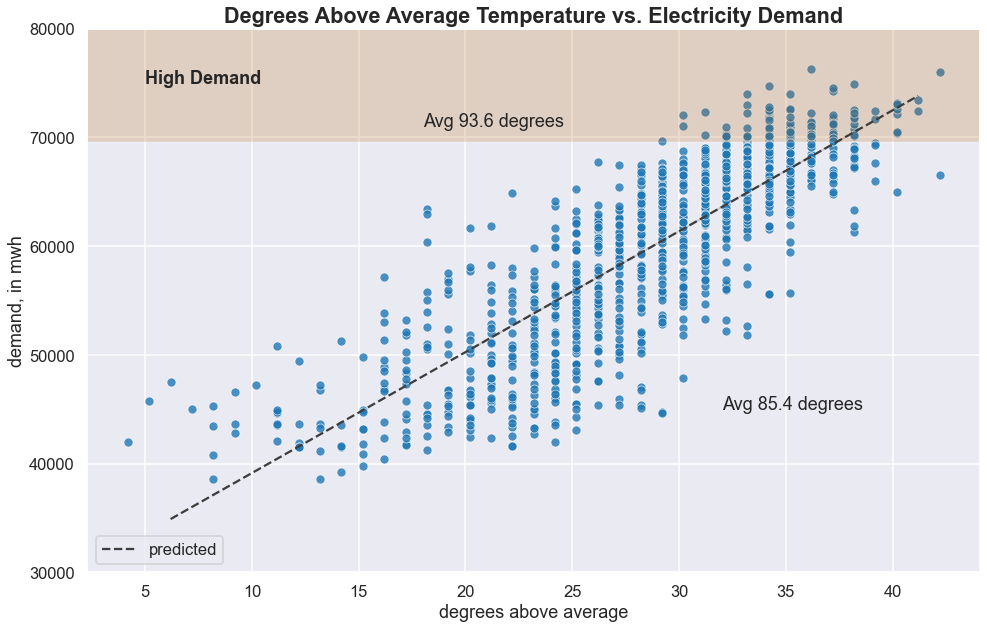

In [167]:
#Plot the temperature vs demand
fig,ax = plt.subplots(figsize=(16,10))
sns.lineplot(
    x=X_test_above['extreme'], 
    y=pred_test_above, 
    color=DARK_NEUTRAL, 
    label='predicted', 
    linestyle='--'
)
sns.scatterplot(
    data=demand_above_df, 
    x='extreme', y='demand',  
    palette=NEUTRAL, 
    alpha=0.8,
    legend=False
)
ax.axhspan(
    demand_above_df['demand'].quantile(.9), 
    80_000, 
    facecolor=BRICK, 
    alpha=0.2)
plt.ylim(30_000,80_000
        )
plt.xlabel('degrees above average')
plt.ylabel('demand, in mwh')
plt.title(
    'Degrees Above Average Temperature vs. Electricity Demand', 
    weight='bold', 
    size='large'
)
plt.text(5, 75_000, 'High Demand', weight='bold')
plt.text(18,71_000, f'Avg {high_demand_avg_temp} degrees')
plt.text(32,45_000, f'Avg {lower_demand_avg_temp} degrees');

In [168]:
#Find the number of days over 90 degrees in the past 6 years
demand_temp.index = pd.to_datetime(demand_temp.index)
demand_temp['year'] = demand_temp.index.year
num_hot_days = []
for yr in demand_temp['year'].unique():
    days = (demand_temp[str(yr)]['max_temp'] > 90).sum()
    num_hot_days.append((yr, days))

num_hot_days

[(2016, 79), (2017, 21), (2018, 45), (2019, 81), (2020, 38), (2021, 19)]

In [169]:
#Get the temperature averages by month
avg_monthly = climate.copy()
avg_monthly.index = pd.to_datetime(avg_monthly.index)
avg_monthly['month'] = avg_monthly.index.month
avg_monthly = avg_monthly.groupby('month').mean()
avg_monthly.columns = ['avg', 'max', 'min']
us_solar['month'] = us_solar.index.month
solar_monthly = us_solar.groupby('month').sum()

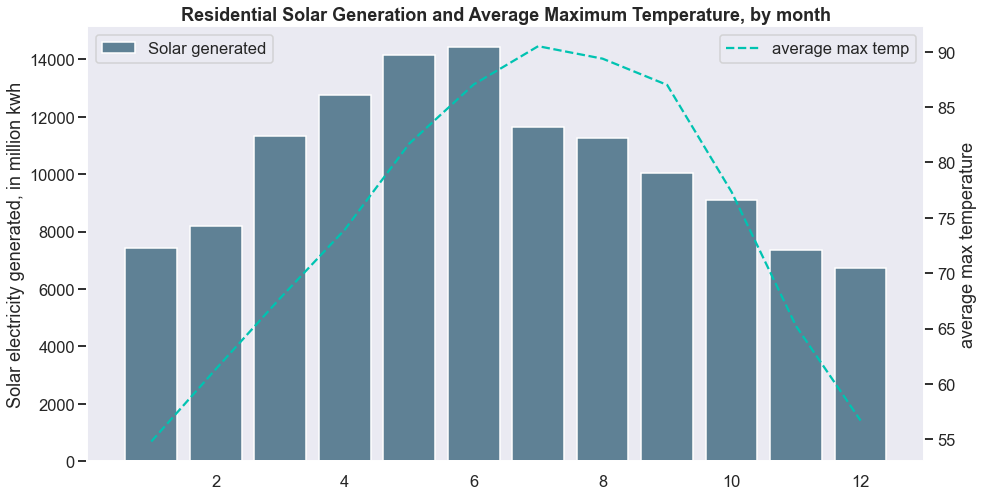

In [170]:
#Plot the amount of solar generated by month of the year
fig,ax = plt.subplots(figsize=(15,8))
ax.bar(
    x=solar_monthly.index, 
    height=solar_monthly['actual'], 
    color=NEUTRAL,
    label='Solar generated'
)
plt.legend(loc=2)
ax2=ax.twinx()
avg_monthly['max'].plot(
    color=HIGHLIGHT, 
    linestyle='--',
    label='average max temp'
)
ax.set_ylabel('Solar electricity generated, in million kwh')
ax2.set_ylabel('average max temperature')
plt.title(
    'Residential Solar Generation and Average Maximum Temperature, by month',
    weight='bold'
) 
ax.grid(False)
ax2.grid(False)
plt.legend();

## Stay Competitive With U.S. Market

In [204]:
#Plot the relationship between solar customers, capacity and energy sold back
net_metering_2020['GA'] = net_metering_2020['state'] == 'GA'

net_metering_nocal = net_metering_2020[net_metering_2020['state'] != 'CA']
fig = px.scatter(
    net_metering_nocal,
    x="residential_solar_capacity", 
    y="residential_solar_customers",
    size="energy_sold", 
    hover_name="state",
    color='GA', 
    template='seaborn',
    log_x=True, 
    size_max=100,
    title='Solar Capacity, Customers and Energy Sold Back by State',
    labels={ "GA": 
            'Georgia?', 
            "residential_solar_capacity": 
            'Solar capacity, million kwh (log-scale)',  
            "residential_solar_customers": 
            "Number Solar Customers"
            },
    color_discrete_map={ 
                True: HIGHLIGHT, False: NEUTRAL},
    hover_data= {'GA':False,
                'residential_solar_capacity':':.2f',
                'residential_solar_customers':':.2f',
                'energy_sold':':.2f'})
fig.add_annotation( 
    text="Georgia", x=1.41, y=2613, arrowhead=1, showarrow=True)

fig.add_shape(type="circle",
    xref="x", yref="y",
    x0=1, y0=1, x1=3, y1=3,
    line_color="LightSeaGreen",
)

fig.show()


In [172]:
#Convert to millon kwh/1000 people for GA and US solar generation
future_solar = us_solar.copy()
future_solar = pd.concat(
    [us_solar['2014':], 
     np.e**(solar_SARIMA_fcast['2021-07-01':])], 
    axis=0
)
future_solar['ga'] = pd.DataFrame(ga_solar)[:-1]

future_solar.drop(['mean_se','month'], axis=1, inplace=True)
future_solar.columns = ([
    'actual_us',
    'predicted_us', 
    'lower_ci',
    'upper_ci',
    'actual_ga'
])

# In million kwh
us_pop = 329_500_000
ga_pop = 10_600_000

for col in future_solar.columns[:4]:
    future_solar[col] = future_solar[col] * 1_000/ us_pop
    
future_solar['actual_ga'] = future_solar['actual_ga'] * 1_000/ ga_pop

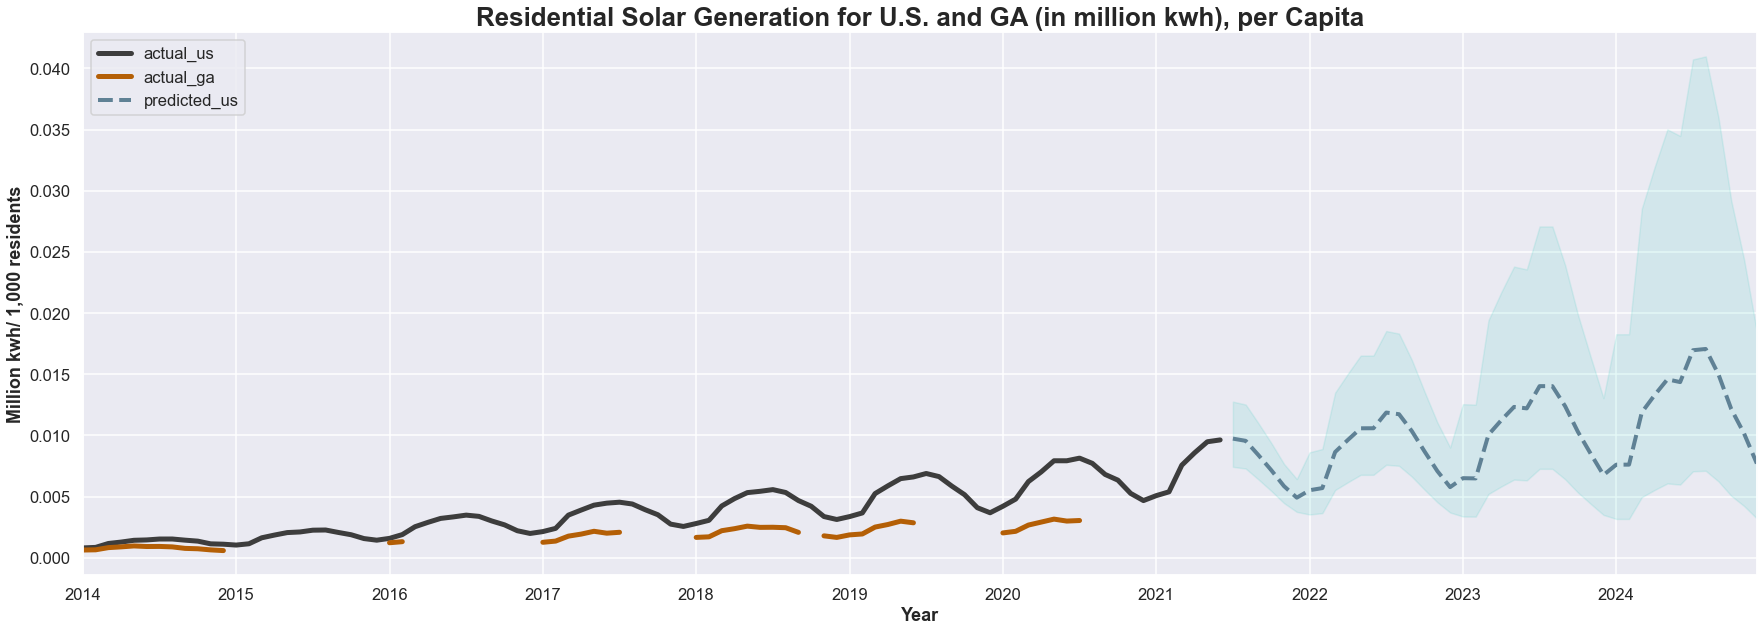

In [203]:
#Plot the data
fig,ax = plt.subplots(figsize=(30,10))
future_solar['actual_us'].plot(
    ax=ax, 
    color=DARK_NEUTRAL, 
    lw=5
)
future_solar['actual_ga'].plot(
    ax=ax, 
    color=BRICK, 
    lw=5
)
future_solar['predicted_us'].plot(
    ax=ax, 
    color=NEUTRAL, 
    linestyle='dashed', 
    lw=4
)

ax.fill_between(
    future_solar.index, 
    future_solar['lower_ci'], 
    future_solar['upper_ci'], 
    color=HIGHLIGHT, 
    alpha=0.1
)
plt.title(
    'Residential Solar Generation for U.S. and GA (in million kwh), per Capita',
    weight='bold', 
    size='x-large'
)
plt.xlabel(
    'Year', 
    weight='bold'
)
plt.ylabel(
    'Million kwh/ 1,000 residents', 
    weight='bold'
)
ax.legend(loc=2); 

# Conclusions

By eliminating the cap on the number of residential customers that can benefit from the net-metering program, Georgia will encourage more homeowners to install PV systems. 

## Georgia faces increased dependence on imported electricity

### Model Evaluation

The best model was an AR model with a first difference, a lag of 5 and a linear trend component. Although it failed to pick up on the temporary fluctuations on residential energy demand during Covid, it generalizes well and has an RMSE of 0.01 billion btus (the naive model had an RMSE of 0.085). 

### What the Data Say

The AR model predicts a 5% increase in residential energy demand from 2021 to 2023. The last year that data were available about energy sources was 2019, and at that point, 8% of electricity was imported and that amount has overall been increasing since 1995. Additionally, since Georgia does not have any coal, natural gas, uranium or petroleum resources, the raw materials for these electricity sources also have to be imported. 

### How an Increase in Residential Solar Can Help

The population of Georgia is increasing and with it, so is the demand for electricity. Since renewable sources (including solar) are the only methods which do not rely on the import of fuel sources, increasing that sector reduces Georgia's dependence on other state's for its electricity needs. 

## An Increase in Natural Gas Prices Leads to Greater Electricity Costs

### Model Evaluation

The best SARIMA model had an order of (0,0,0) and a seasonal order of (2,2,2,52). This shows that it finding a pattern between the prices two years ago (104 weeks) and the current price. The RMSE was 0.291, which is not a great improvement from the naive model of 0.425. The confidence intervals are very broad, showing that the model does not have much certainty in its predictions.

The best LSTM has two bidirectional layers and two dense layers, one with regularization. The RMSE of 0.07 on the rolling predictions was much better than the SARIMA model, but the plot shows that it is not doing an effective job of capturing the patterns in the data.

### What the Data Say

Since none of the models were accurate at forecasting, it is a sign that gas prices are dependent on exogenous variables, rather than being autoregressive. 

### How an Increase in Residential Solar Can Help

Natural gas prices fluctuate quite a bit, from a low of \\$1.41 to a high of \\$14.74 in the last 27 years (standard deviation of \\$2.24). In addition, Georgia's use of natural gas to produce electricity has increased more than 124\% in that same period. In order to keep electricity costs low, Georgia should shift to other sources, including solar. 

## Extreme High Temperatures Strain the Electrical Grid

### Model Evaluation

The model is a simple OLS model with a single predictor (temperature). The RMSE values were very close between the train and test sets (4,674 and 4,871 mwh respectively), showing that the model is not overfitting. 

The R2 of the test data is 0.69, indicating that 69% of the residential electricity demand can be explained by the number of degrees over average of the outside temperature. 

The intercept of 26,540 indicates that on a day with an average temperature of 57.8 degrees, the electricity demand in the Southeast region is 28,110 mwh. The coefficient of 1,157 indicates that for every degree above normal, there is an additional demand on the grid of 1,157 mwh.

The data fit the assumptions for linear regression with a Durbin-Watson score of just under 2 , showing no autocorrelation and indicating that the residuals are homoscedastic. The kurtosis value of just over 3 shows slightly heavier tails than a normal distribution.

### What the Data Say

The average temperature during the top 10% of electricity demand is 93.6 degrees. Those temperatures are not unusual for Georgia.

In [201]:
for year in num_hot_days:
    print(f'-In {year[0]} there were {year[1]} days over 90 degrees.')

-In 2016 there were 79 days over 90 degrees.
-In 2017 there were 21 days over 90 degrees.
-In 2018 there were 45 days over 90 degrees.
-In 2019 there were 81 days over 90 degrees.
-In 2020 there were 38 days over 90 degrees.
-In 2021 there were 19 days over 90 degrees.


Whenever the demand on the grid is high, there is a risk of rolling blackouts or grid collapse, both of which cause hardship on residents and cost the state money in repairs and imported electricity. 

### How an Increase in Residential Solar Can Help

When solar is generated at the source, it does not rely on the grid to power a residence. On sunny days, a residential PV system can generate enough power to provide electricity for other homes. Cobb County EMC, which has net metering, states that up to 30% of their electricity comes from solar on sunny days. If residential solar is increased, the overall demand on the grid (especially on sunny days in the spring and summer), will decrease. 

## Georgia is Falling Behind the U.S. in Energy 

### Model Evaluation

The best model was a SARIMA model with an order of (0,0,0) and a seasonal order of (2,2,2,12). This indicates that the model is predicting from the values and errors two years (24 months) ago. The RMSE is 0.123, which is greatly improved from the naive model's RMSE of 4.833.

The residuals are relatively normal with the exception of some outliers. The correlogram suggests that there is information that the model is not capturing, but the forecast plot seems to describe the data well.

### What the Data Say

When looking at the per capita production of residential solar electricity, it is clear that Georgia is lagging behind the U.S. In looking at the individual states, there is a clear correlation between the number of solar customers, the residential solar capacity and the energy sold back to the grid via net-metering programs. Georgia is towards the bottom in all three areas.

### How an Increase in Residential Solar Can Help

With energy prices generally rising and an increased concern for protecting the environment, there will likely be increased pressure at the federal level to keep up with the changing energy landscape. Increasing residential solar production is one step Georgia can take in this direction.

# Summary of Conclusions
*** 

**Remove the cap on net metering to encourage more residential PV solar systems. Increasing the amount of residential solar in Georgia will:**

- Increase independence from imported fuel sources by increasing renewable energy sources (including solar)
- Lower costs associated with natural gas by increasing energy from other sources (including solar)
- Reduce risk of grid collapse by reducing the strain on the grid, especially during periods of above-average temperatures
- Stay competitive with energy changes by instituting policies that encourage growth and innovation


# Future Work

- Research impact of different approaches of net-metering programs on customer participation and energy sold back to the power company
- Add exogenous variables to improve model to predict natural gas prices
- Obtain more recent data from Georgia Power to provide a better picture of the current energy situation.